<a href="https://colab.research.google.com/github/OtavioBosa/xp-posgraducao/blob/main/Tratamento_e_Processamento_dos_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install translate

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
from translate import Translator
import sql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


BASE DE DADOS <br>
[Link Github](https://raw.githubusercontent.com/OtavioBosa/xp-posgraducao/Sprint_1-1/BaseDados.csv)

In [2]:
# Carregando o dataset
dataset = 'https://raw.githubusercontent.com/OtavioBosa/xp-posgraducao/Sprint_1-1/BaseDados.csv'
df = pd.read_csv(dataset, sep=',')

In [65]:
#Visualizando a Estrutura do Arquivo
df

Ano  Mes  Dia  Total       Data
Data                                        
2001-01-01  2001    1    1      0 2001-01-01
2001-01-02  2001    1    2      5 2001-01-02
2001-01-03  2001    1    3     15 2001-01-03
2001-01-04  2001    1    4      3 2001-01-04
2001-01-05  2001    1    5      0 2001-01-05
...          ...  ...  ...    ...        ...
2022-12-27  2022   12   27      0 2022-12-27
2022-12-28  2022   12   28      0 2022-12-28
2022-12-29  2022   12   29      0 2022-12-29
2022-12-30  2022   12   30      0 2022-12-30
2022-12-31  2022   12   31      0 2022-12-31

[8035 rows x 5 columns]

In [64]:
#Analisando as Colunas do Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8035 entries, 2001-01-01 to 2022-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Ano     8035 non-null   int64         
 1   Mes     8035 non-null   int64         
 2   Dia     8035 non-null   int64         
 3   Total   8035 non-null   int64         
 4   Data    8035 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(4)
memory usage: 376.6 KB


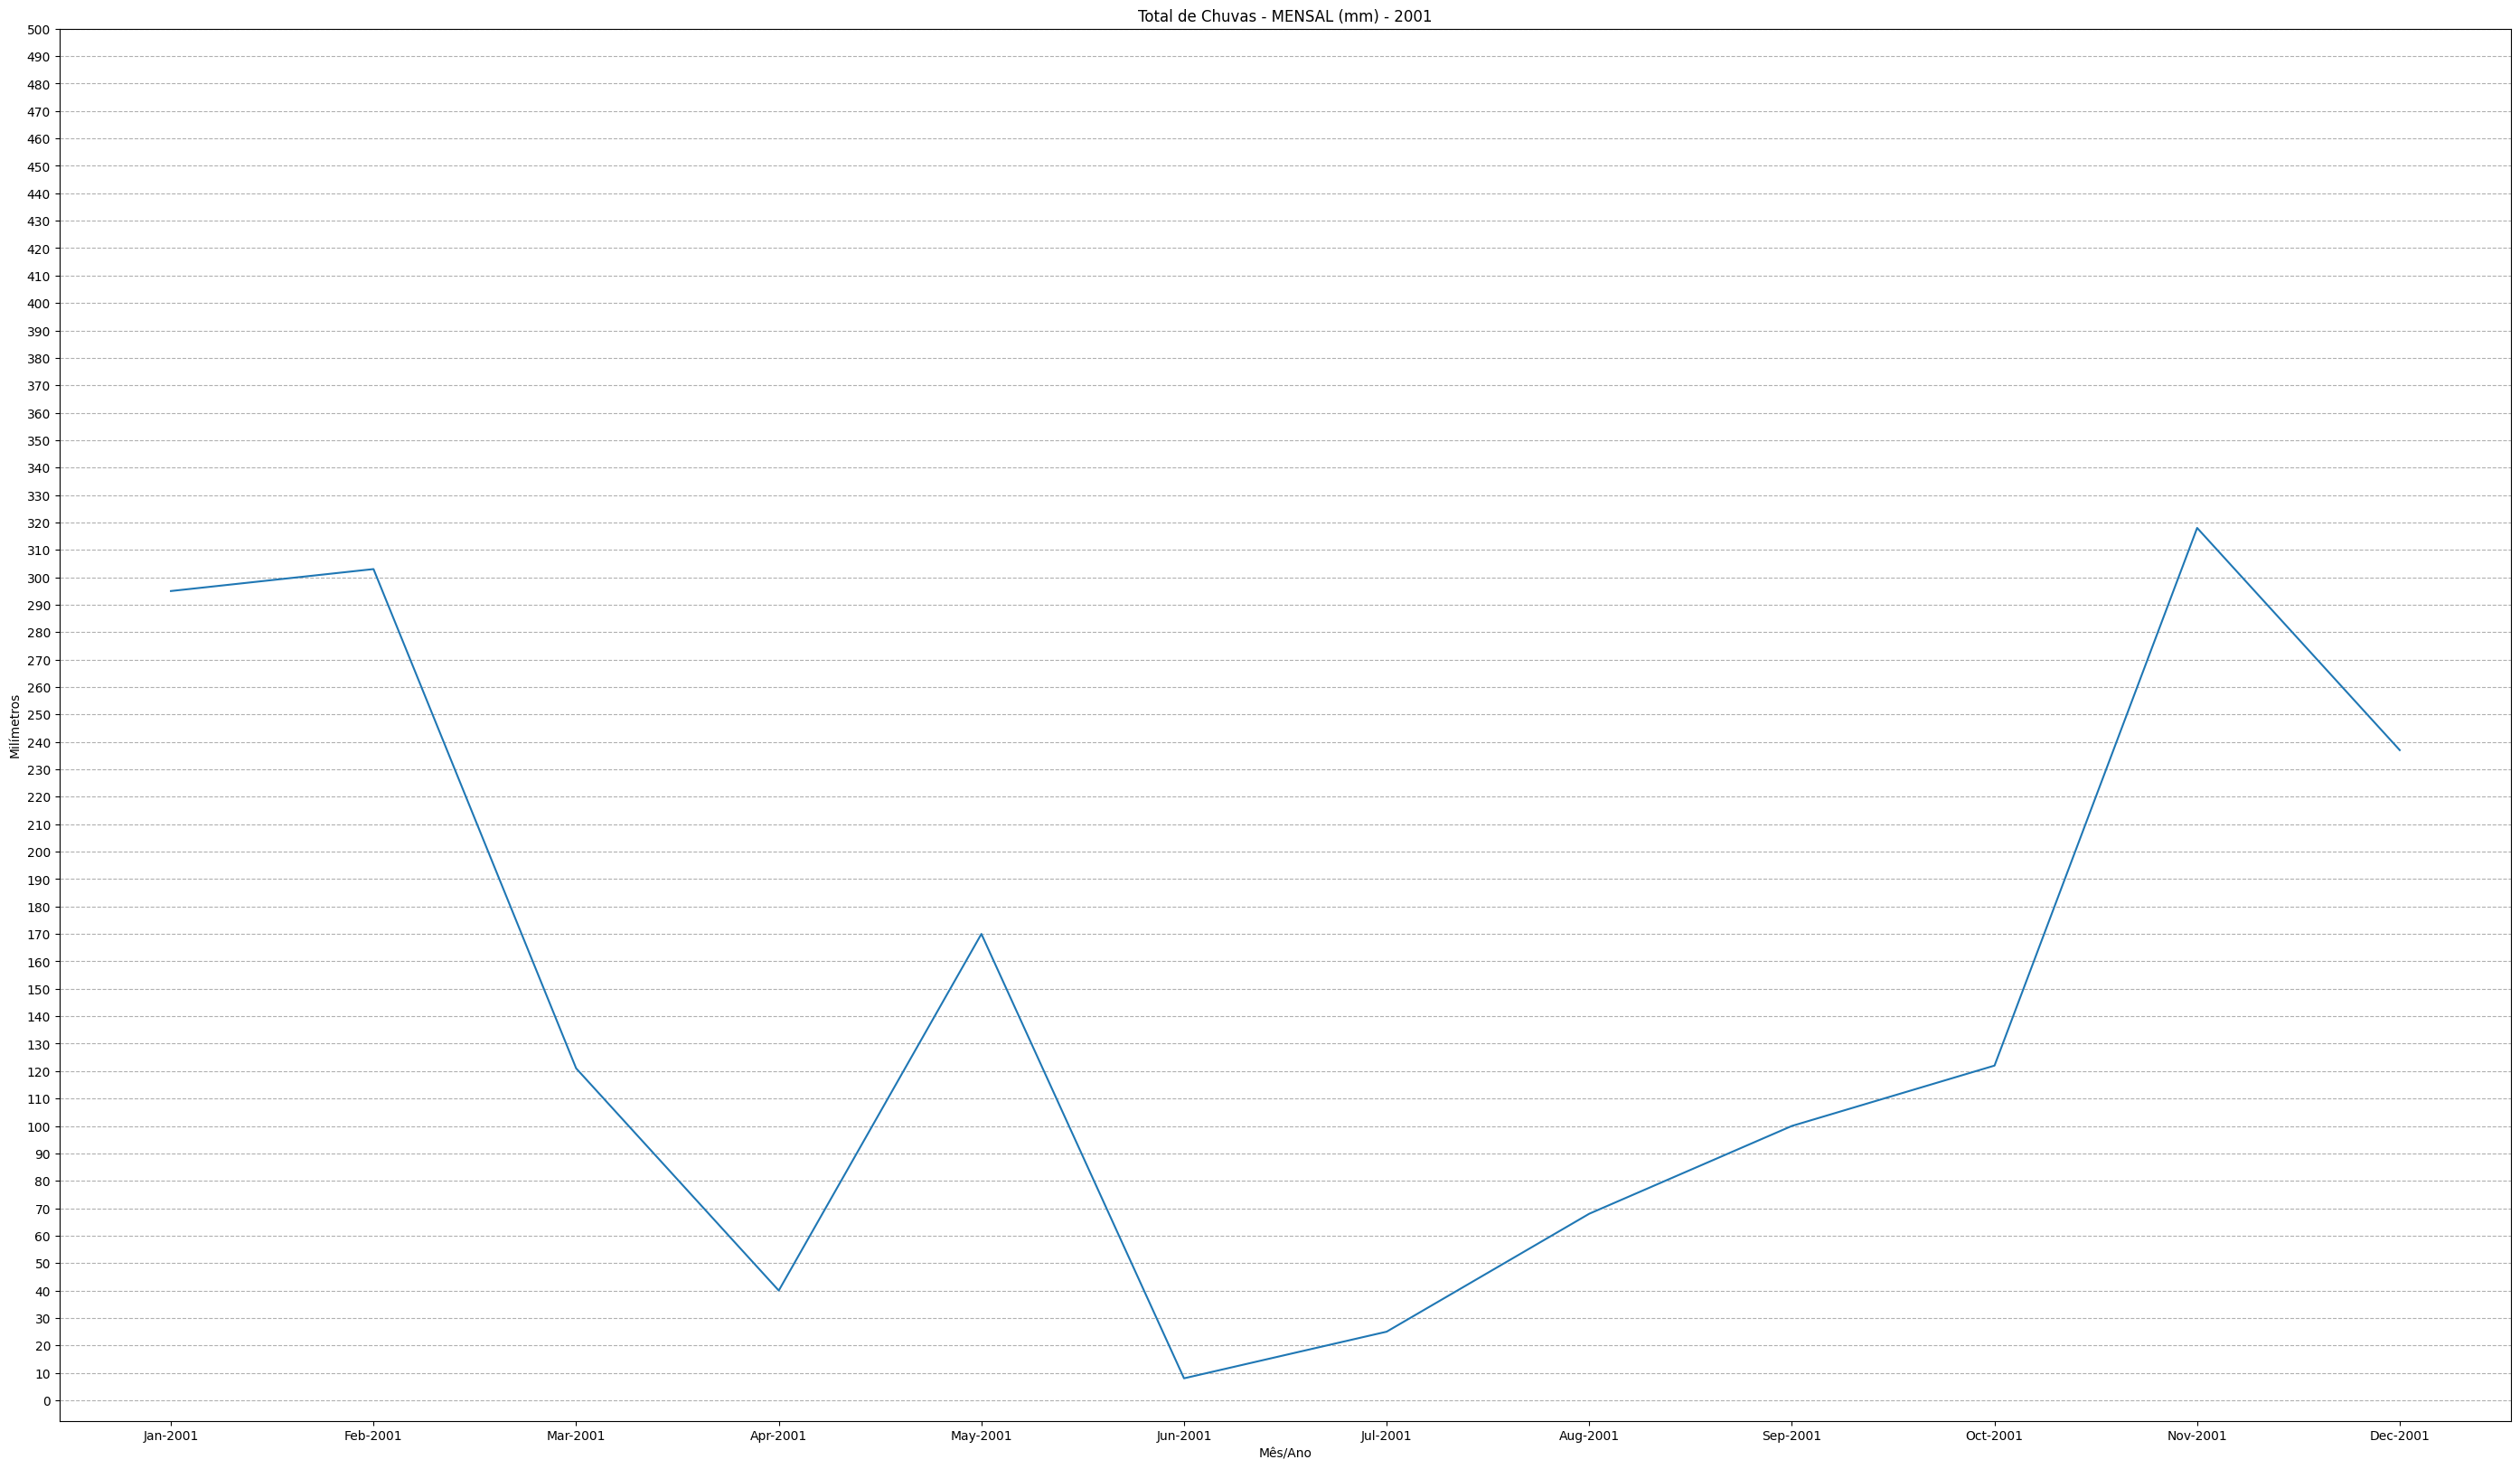

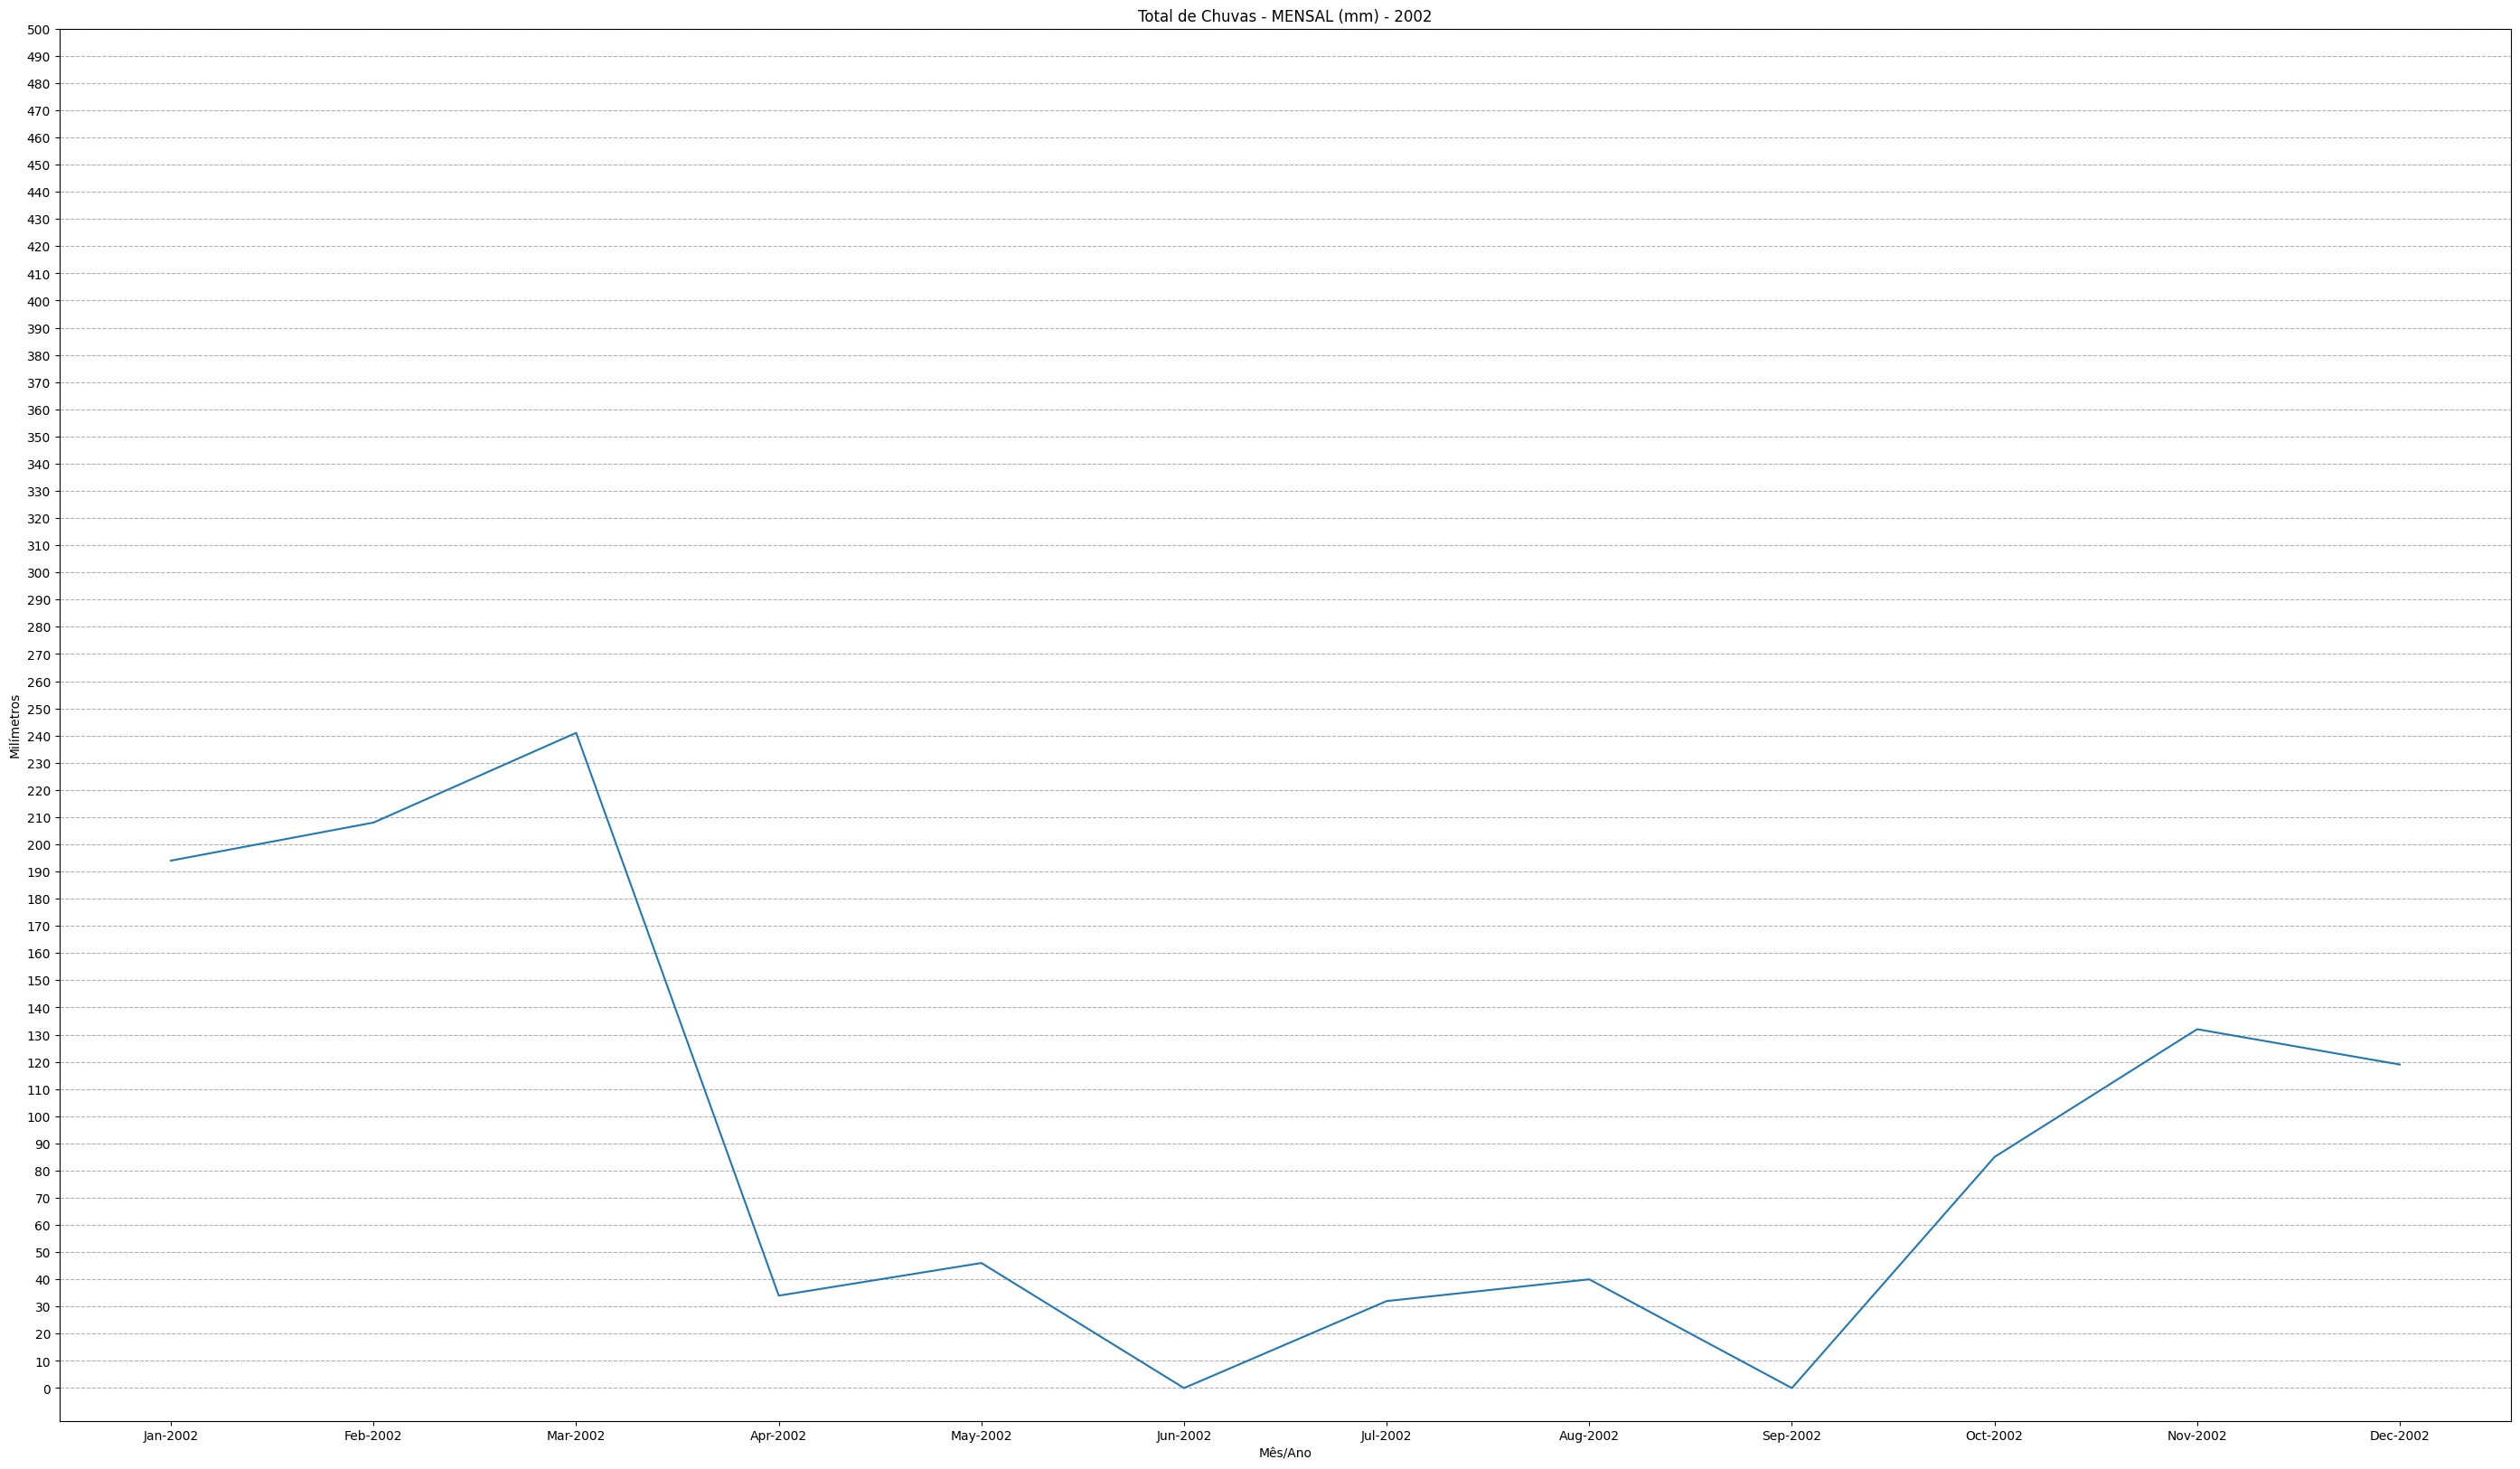

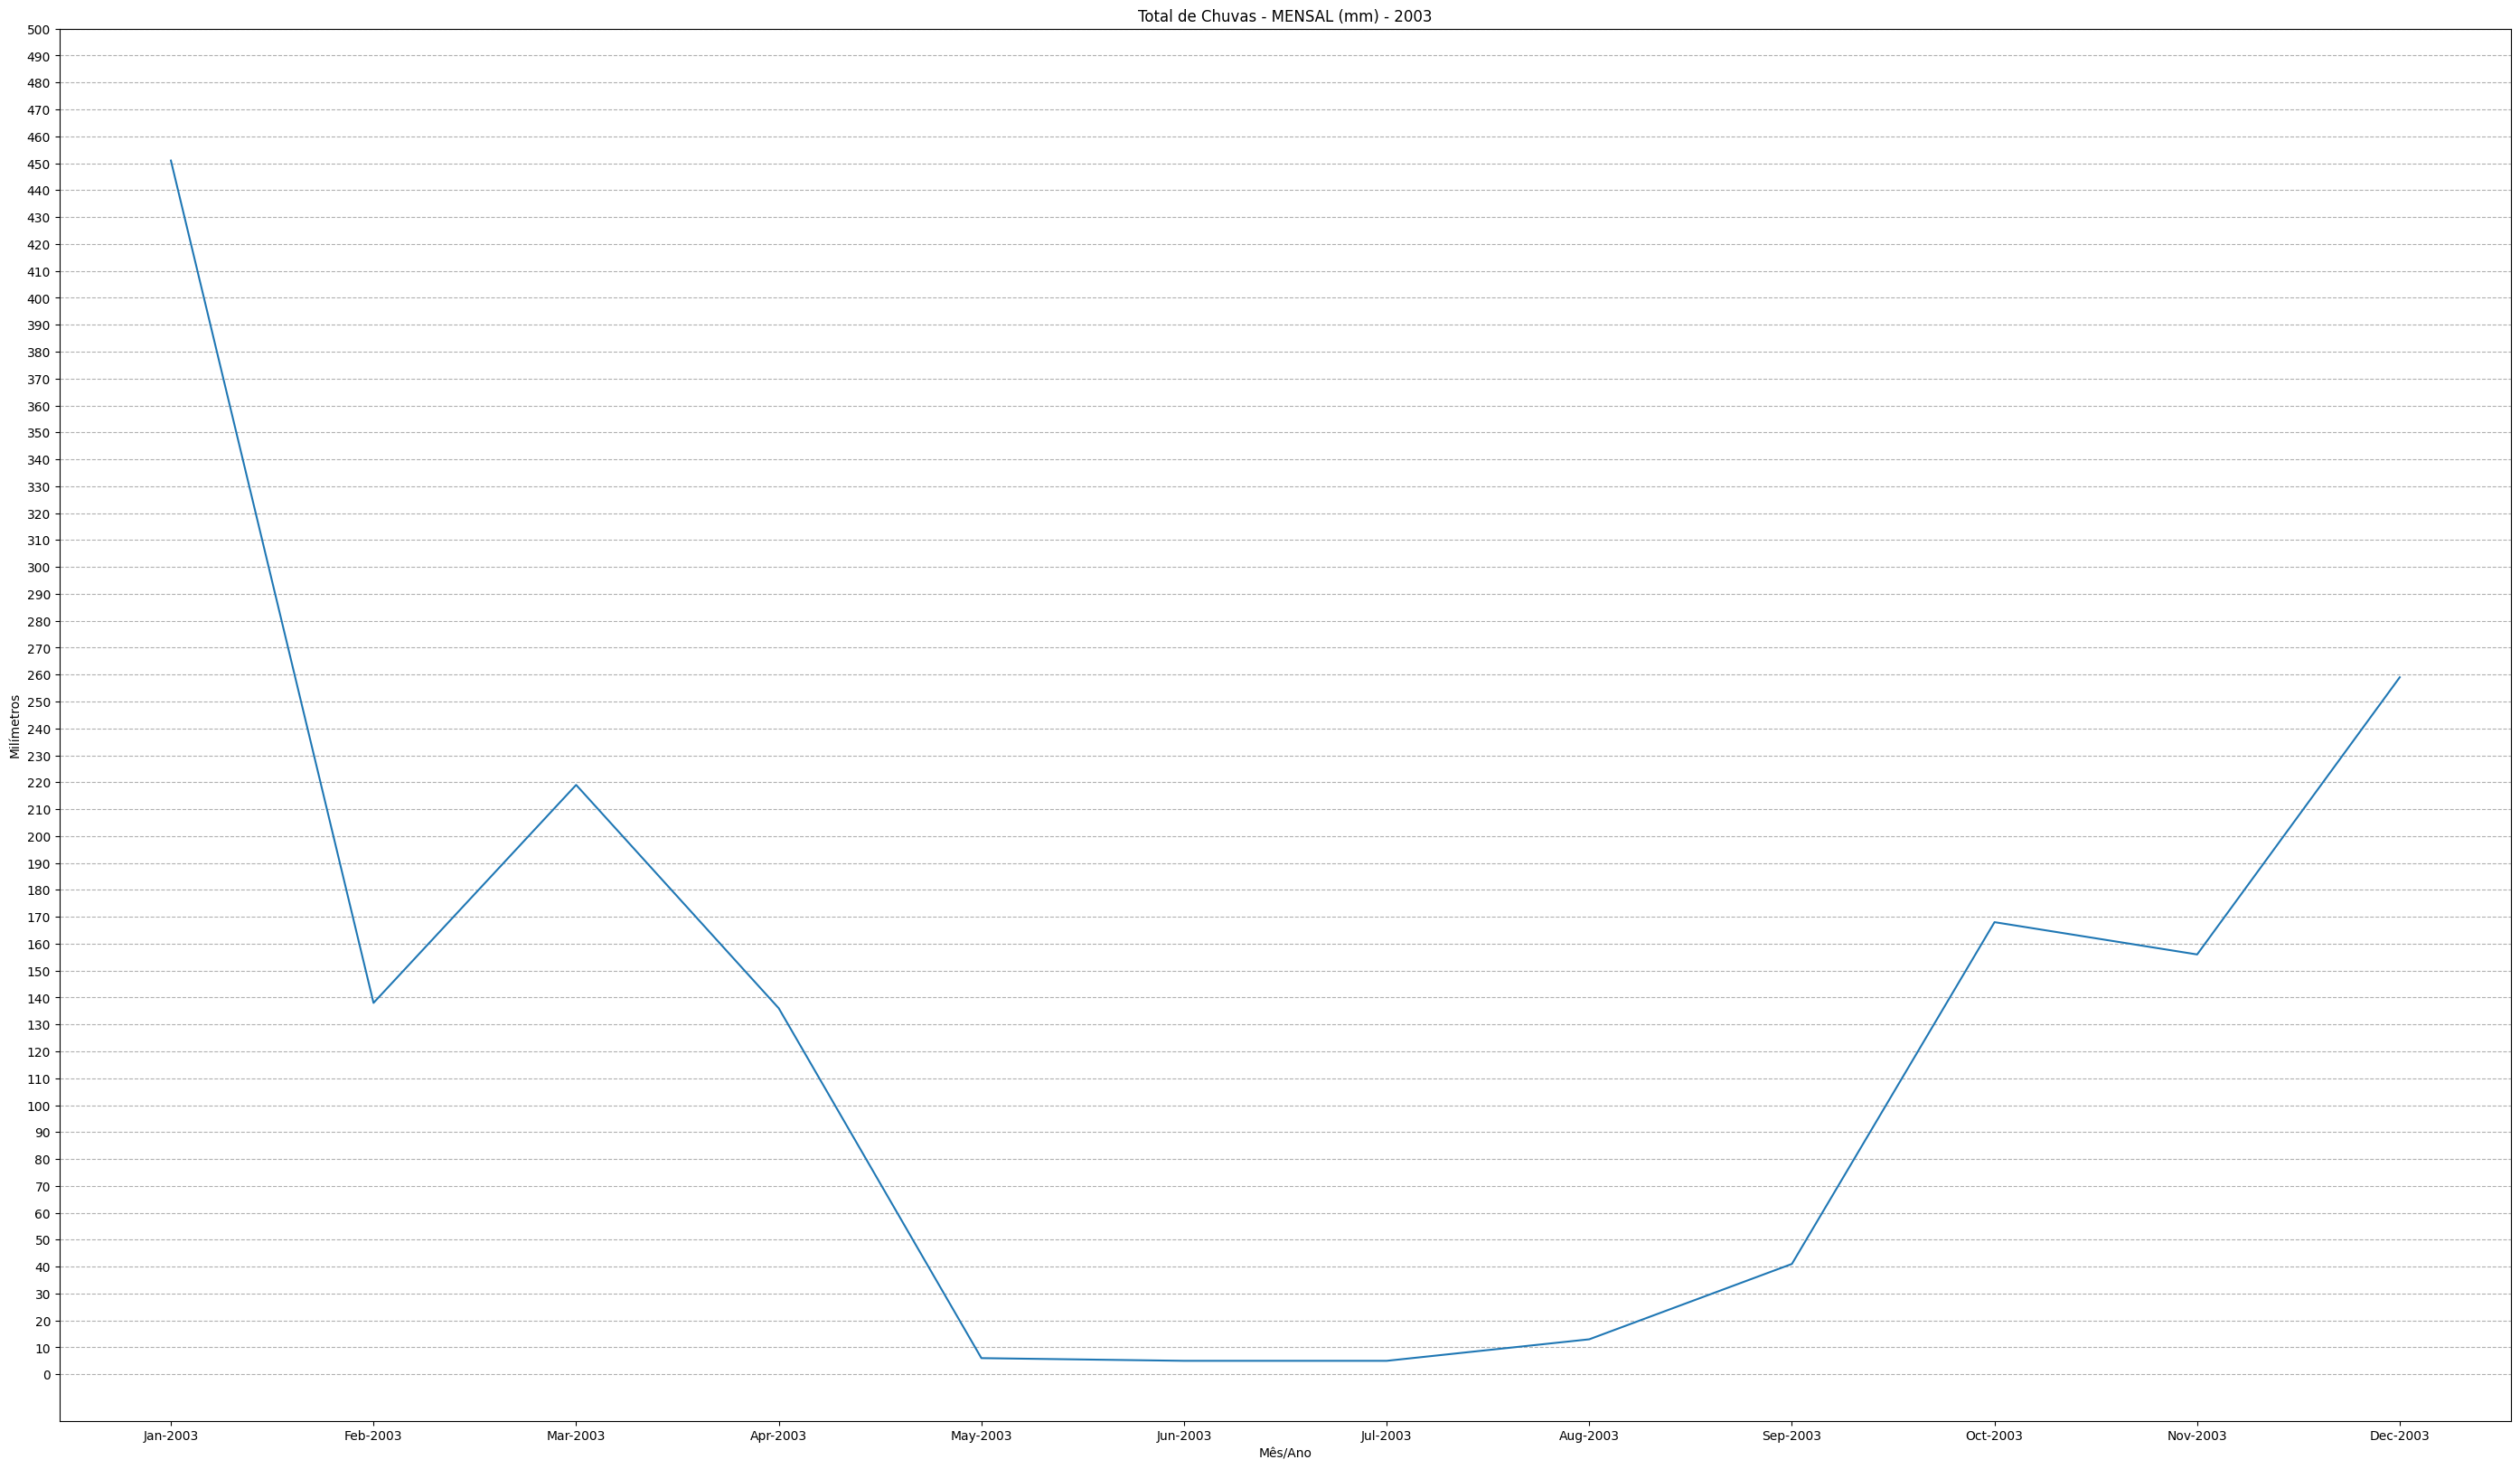

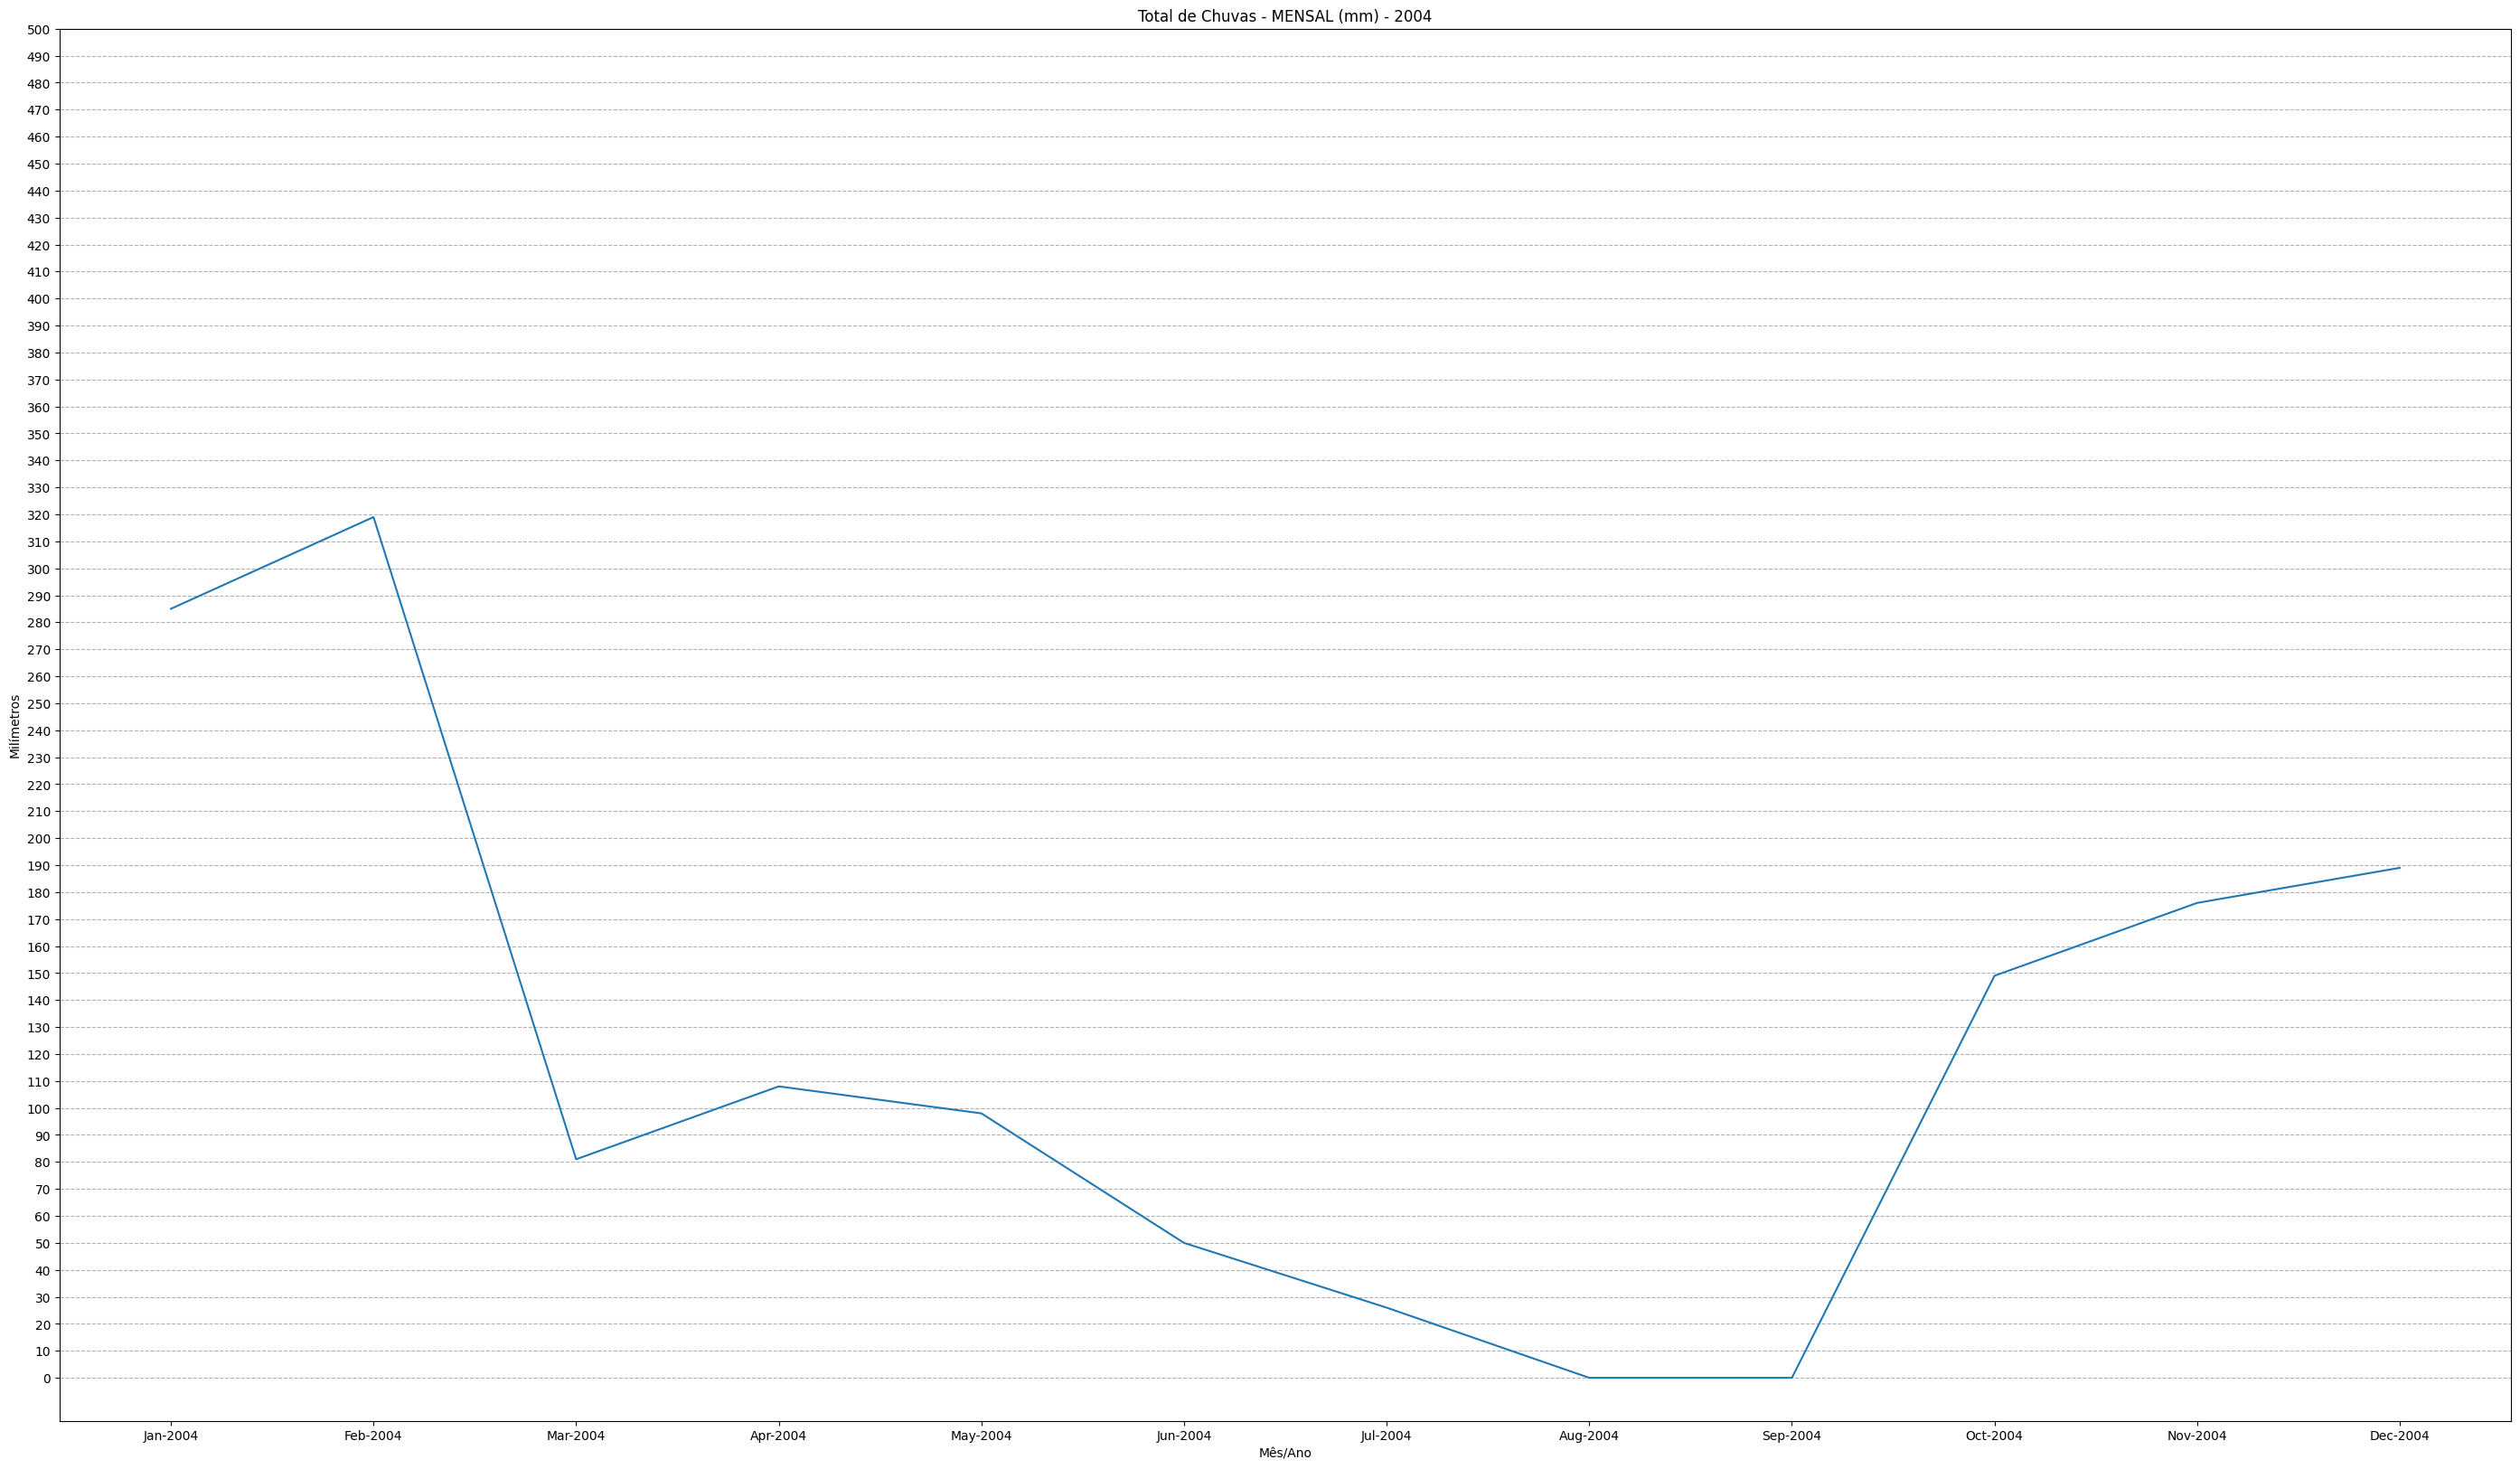

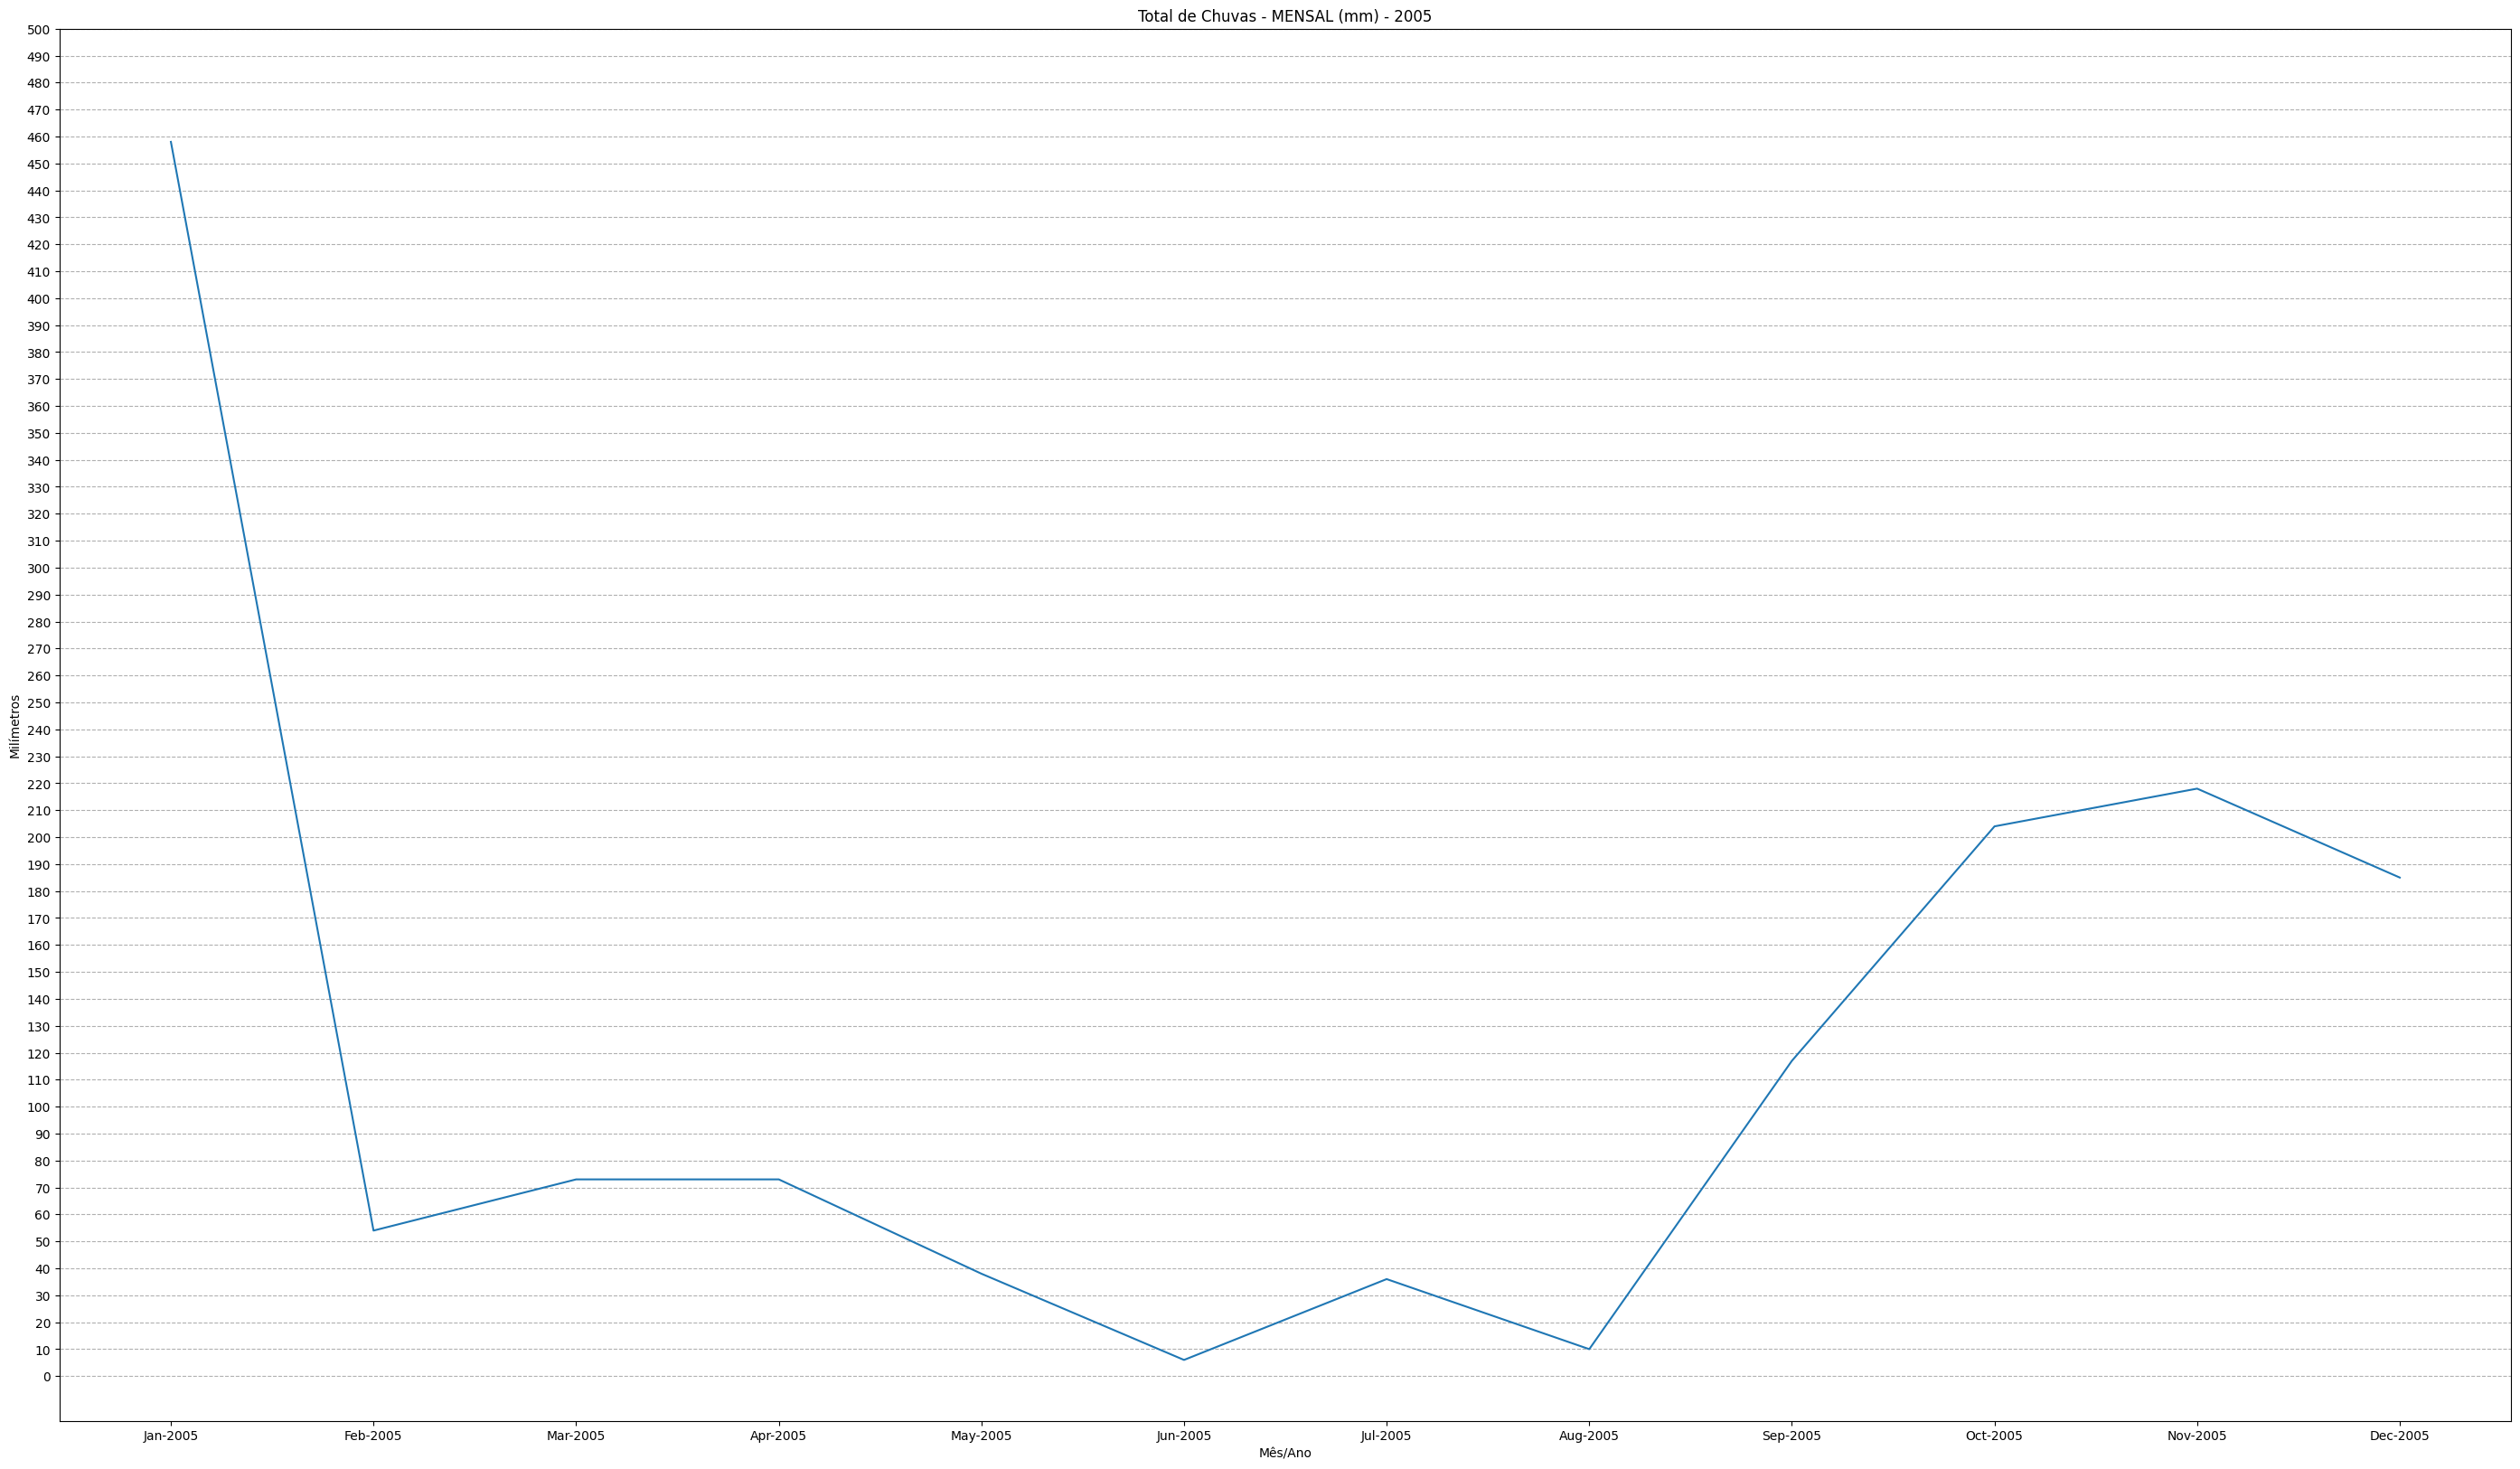

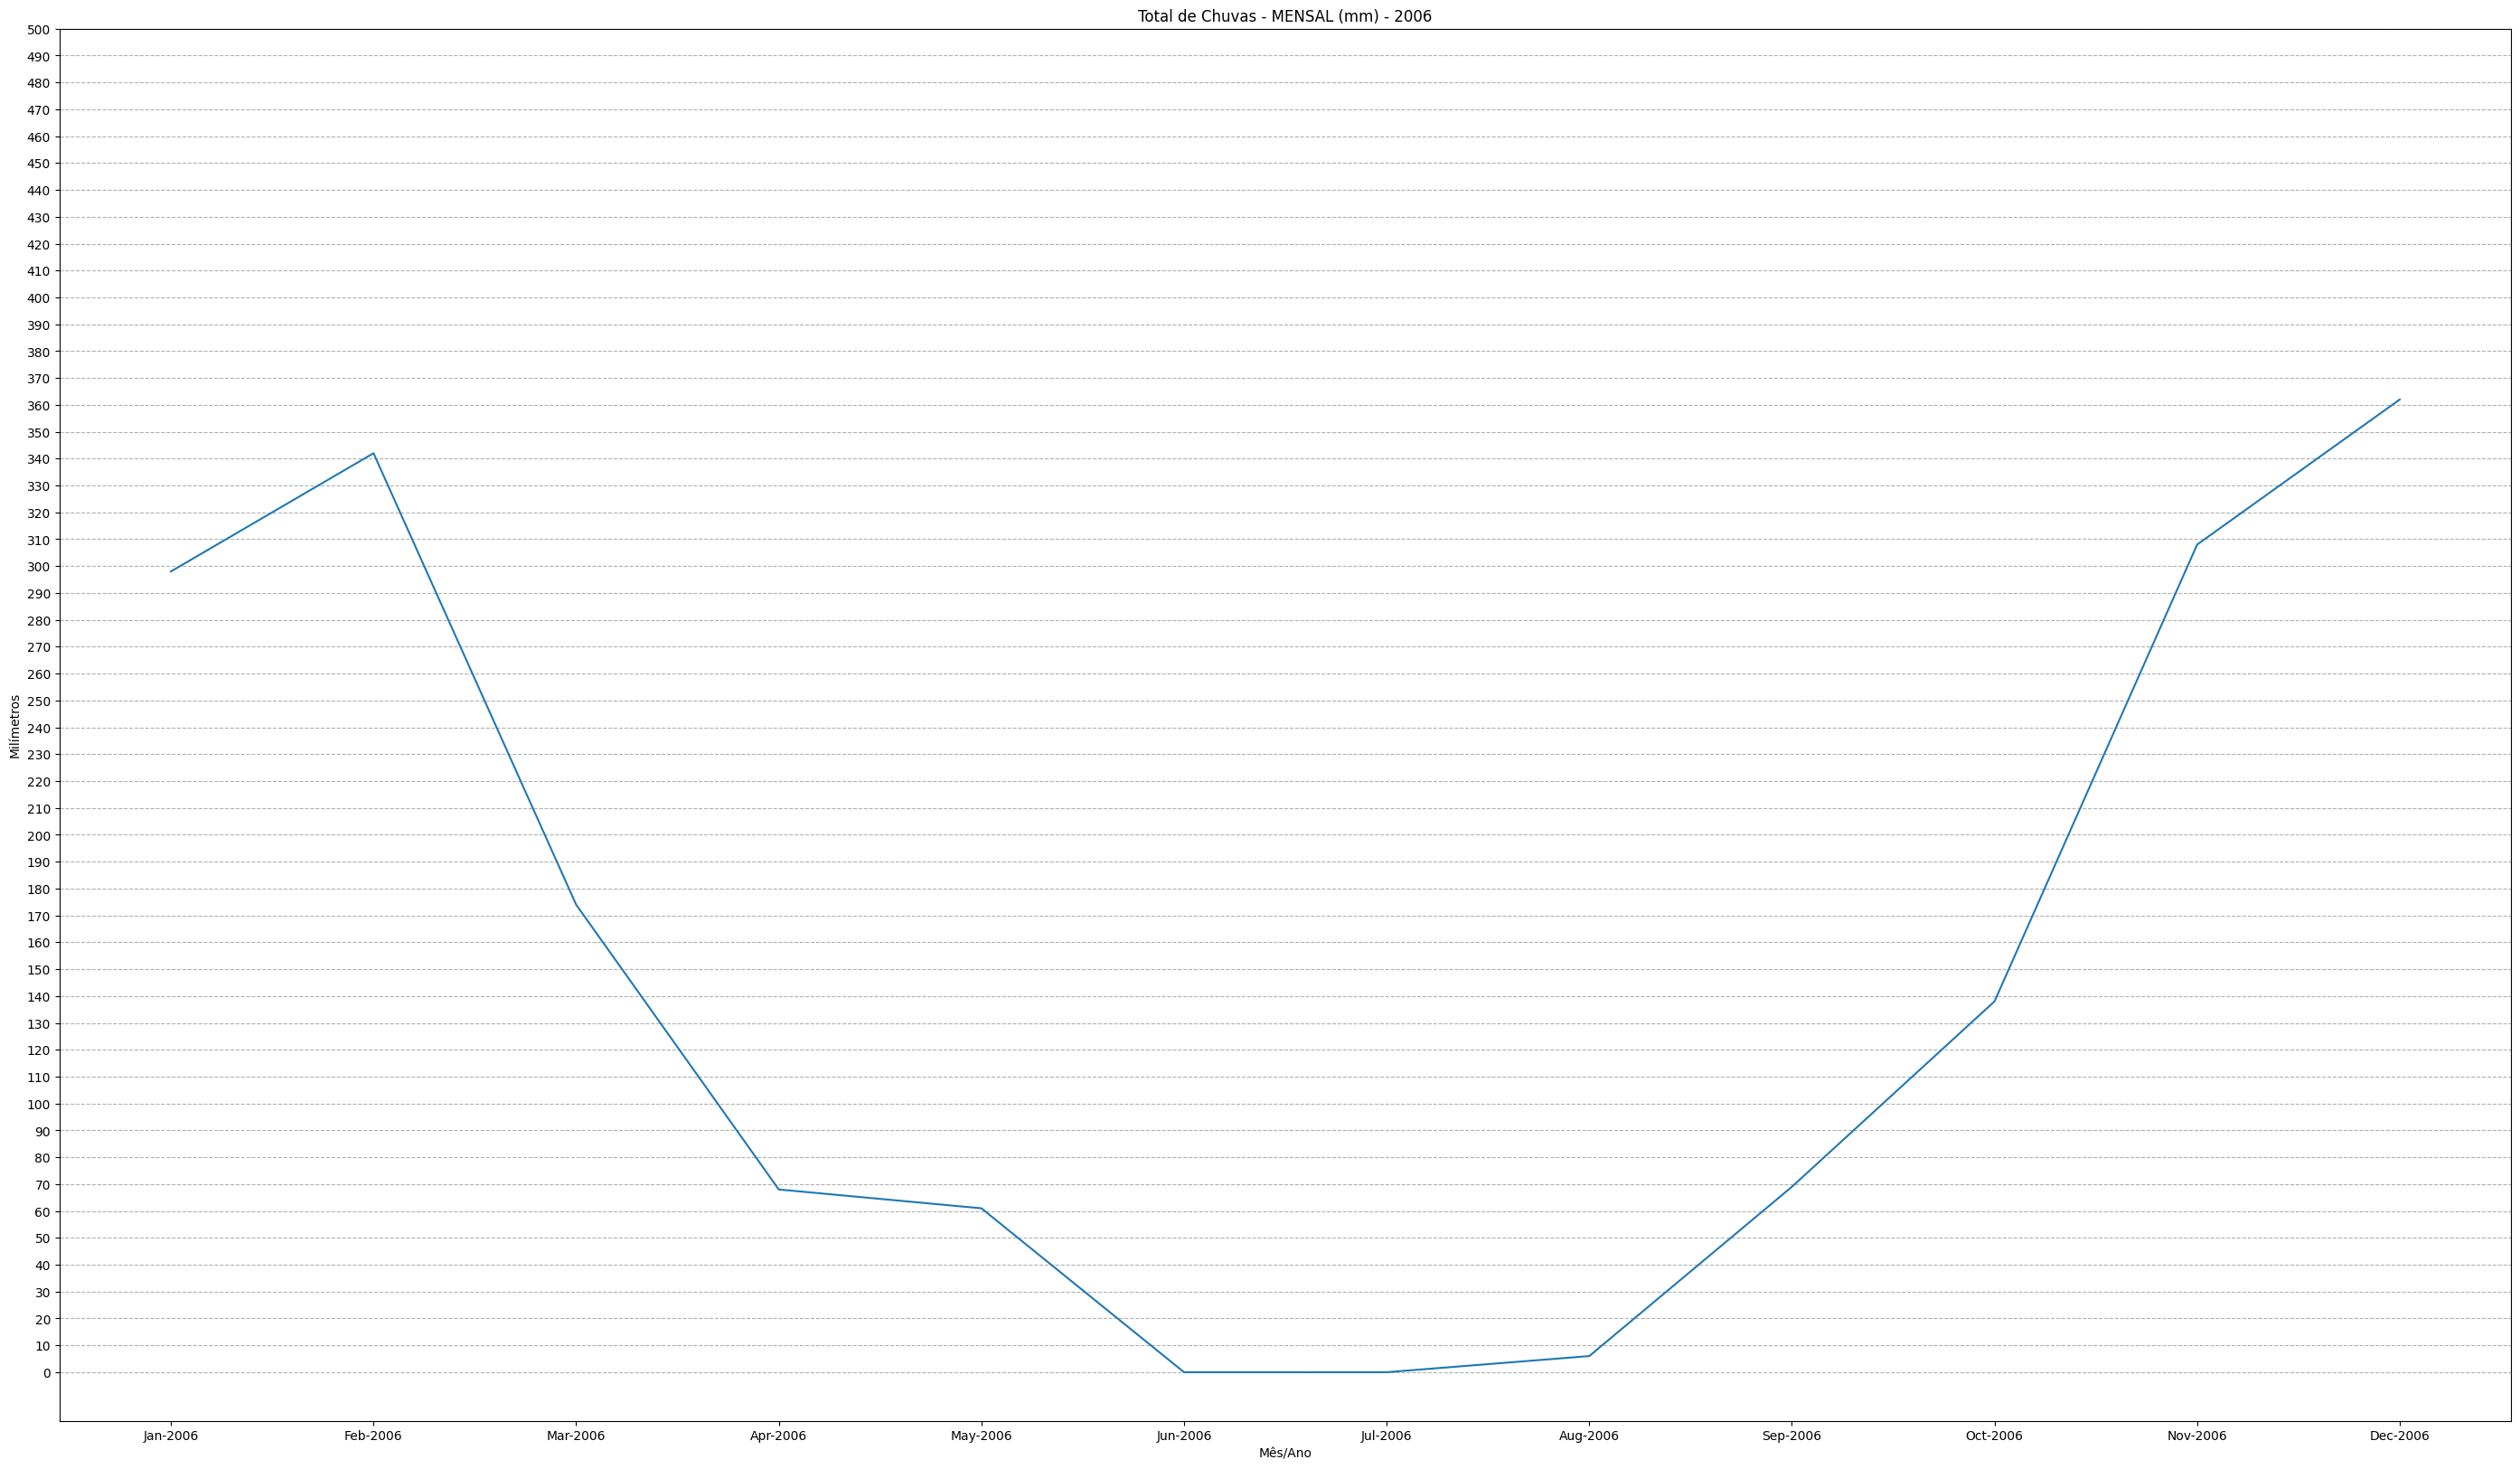

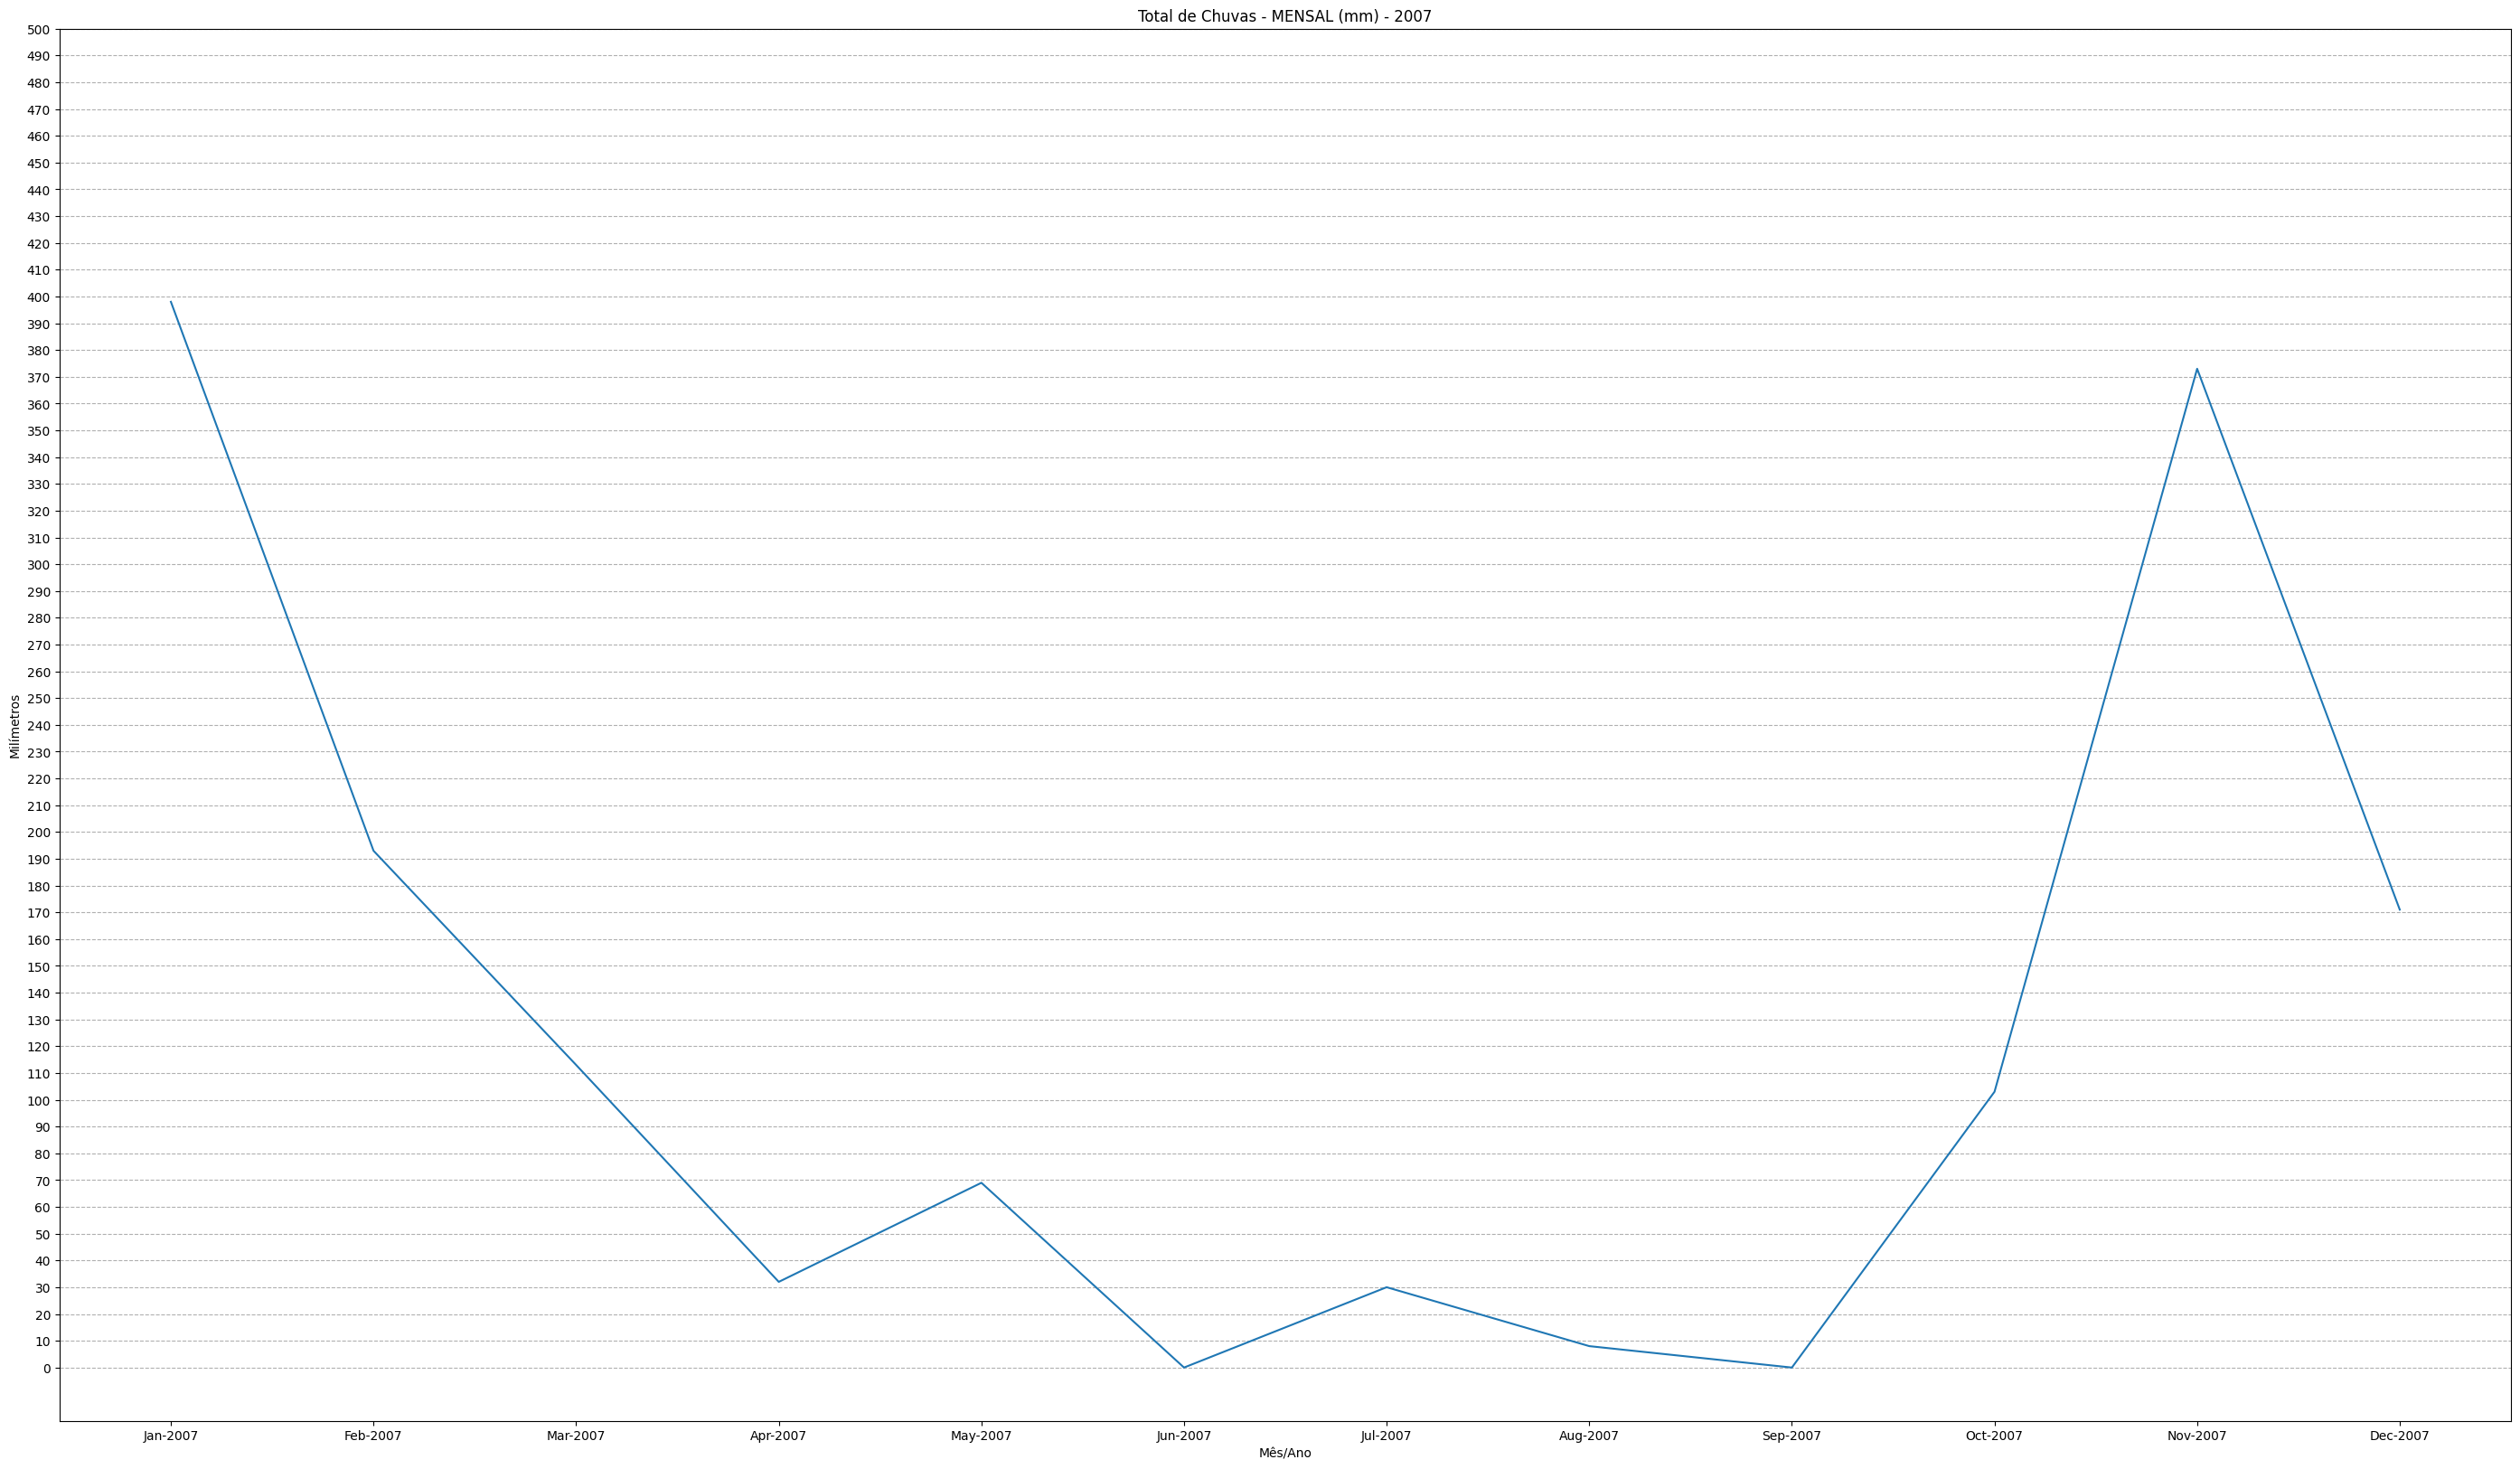

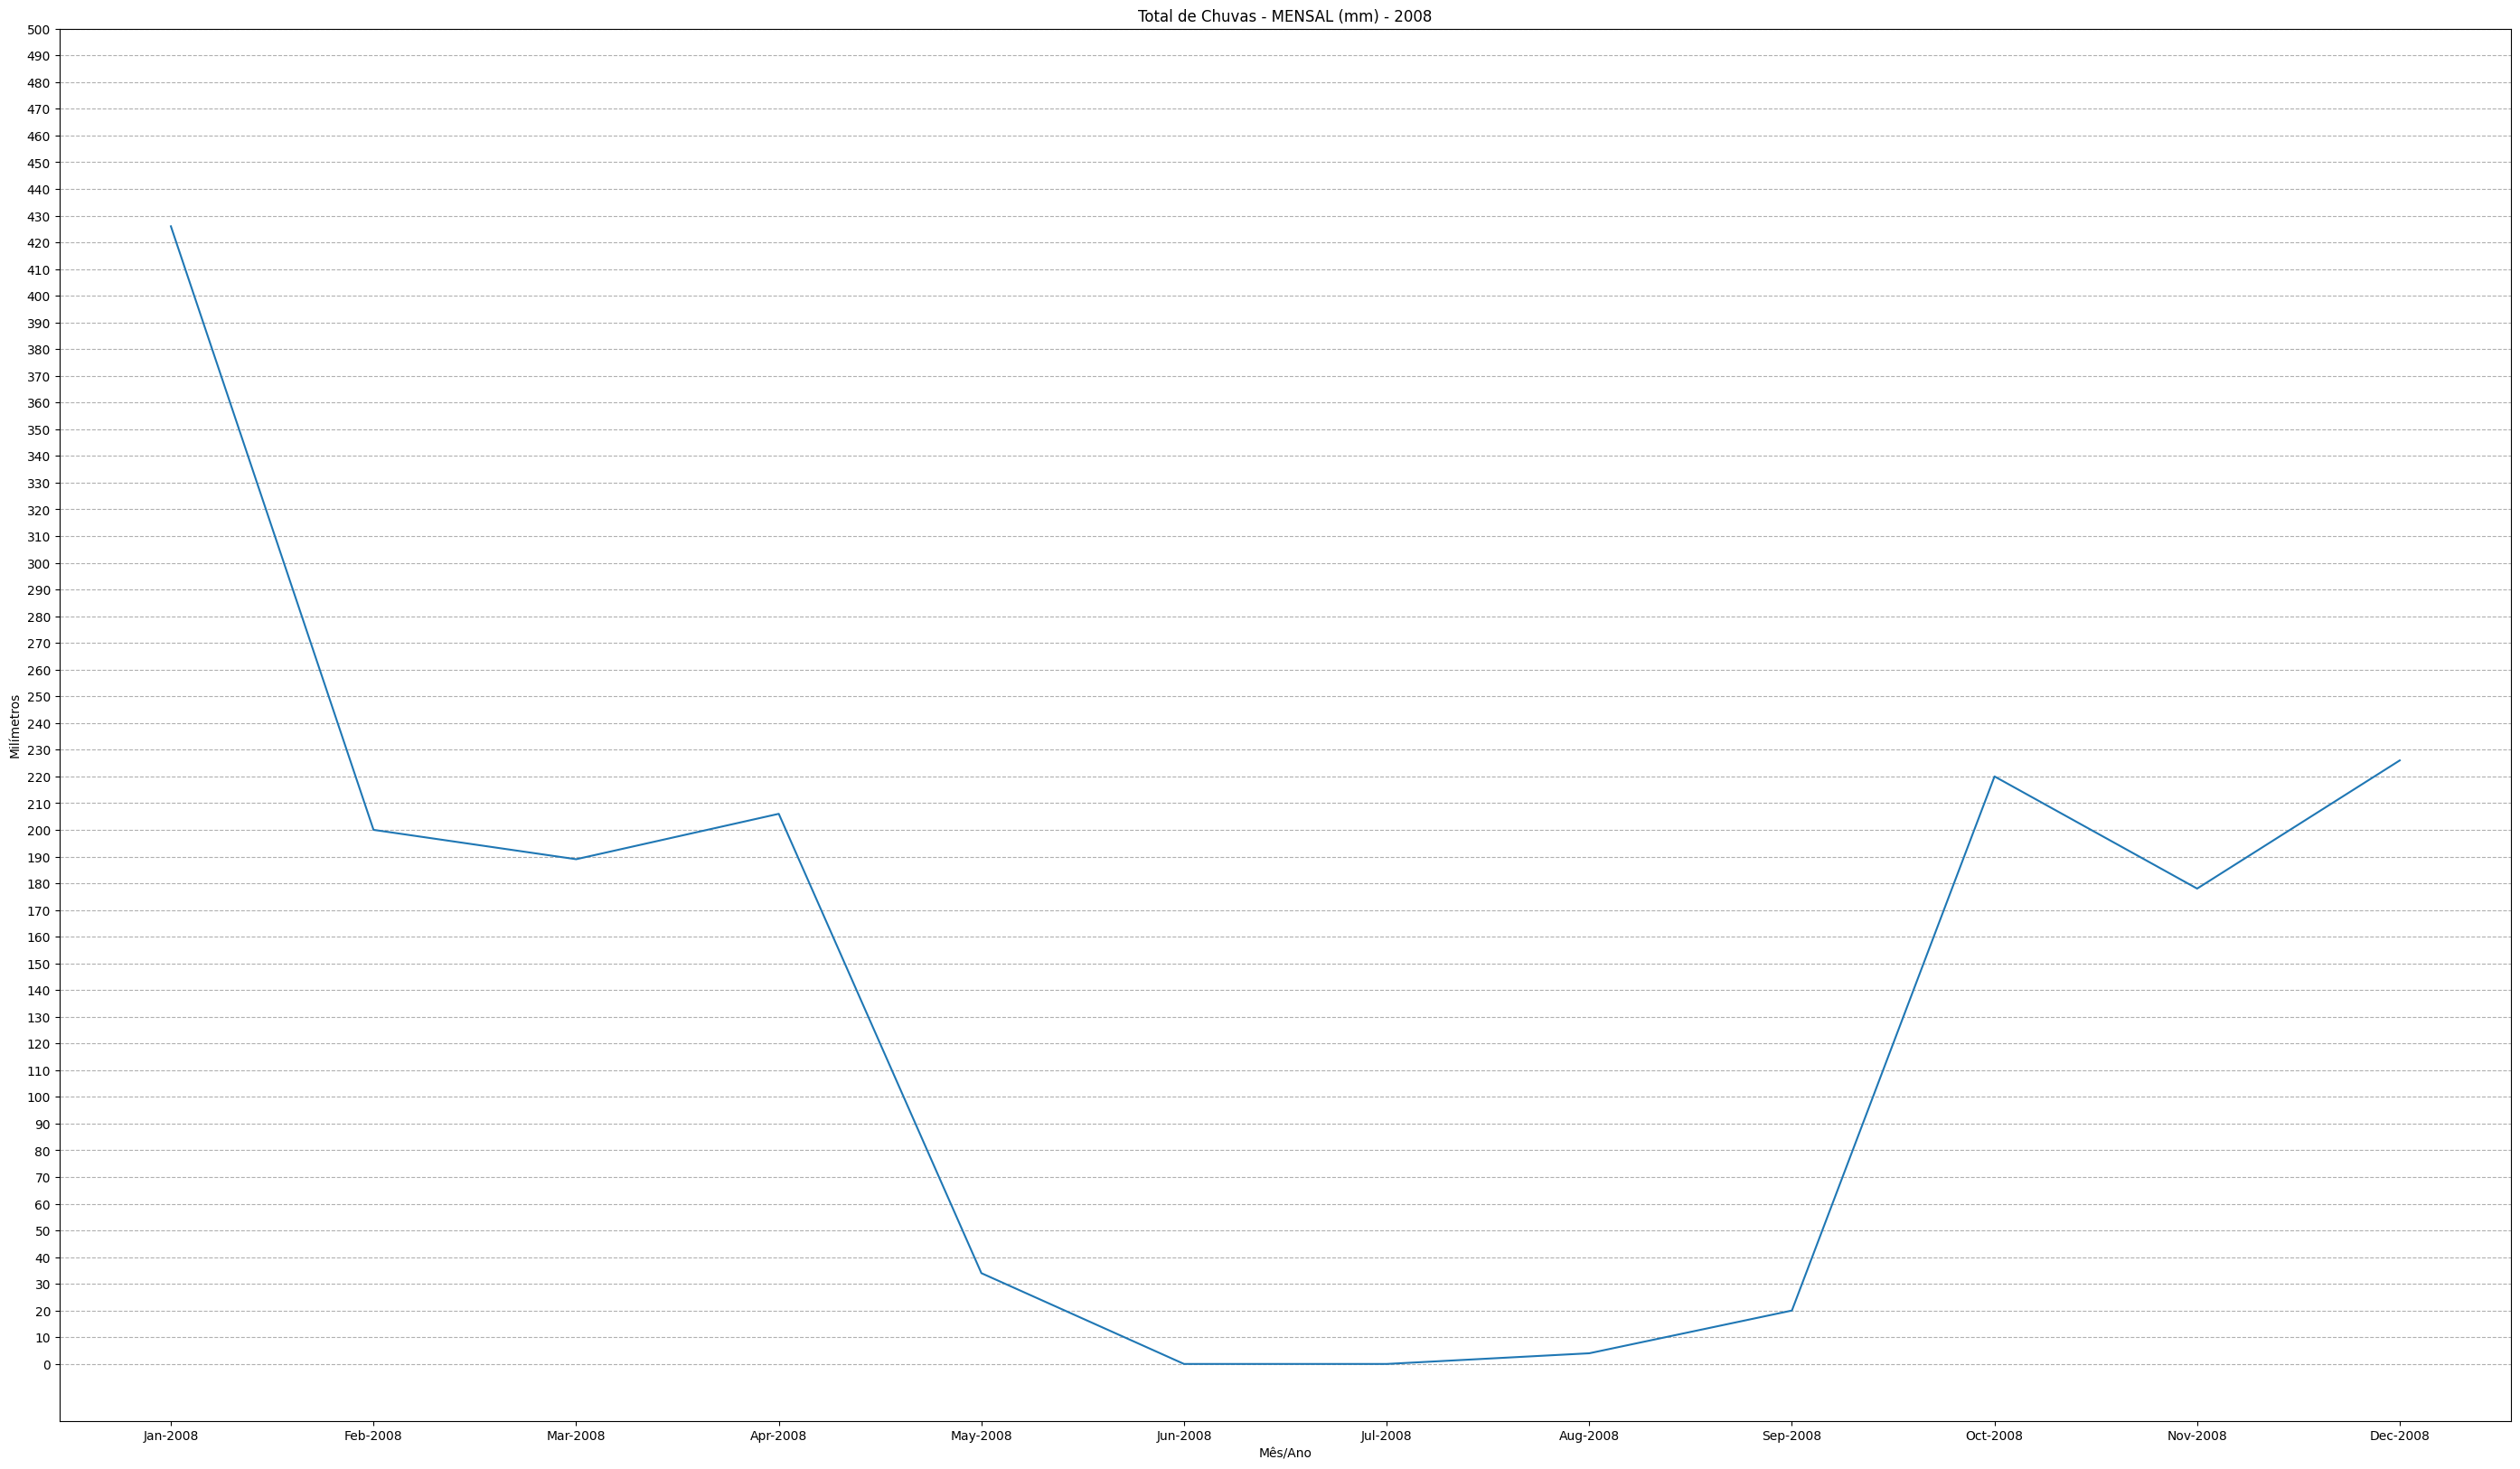

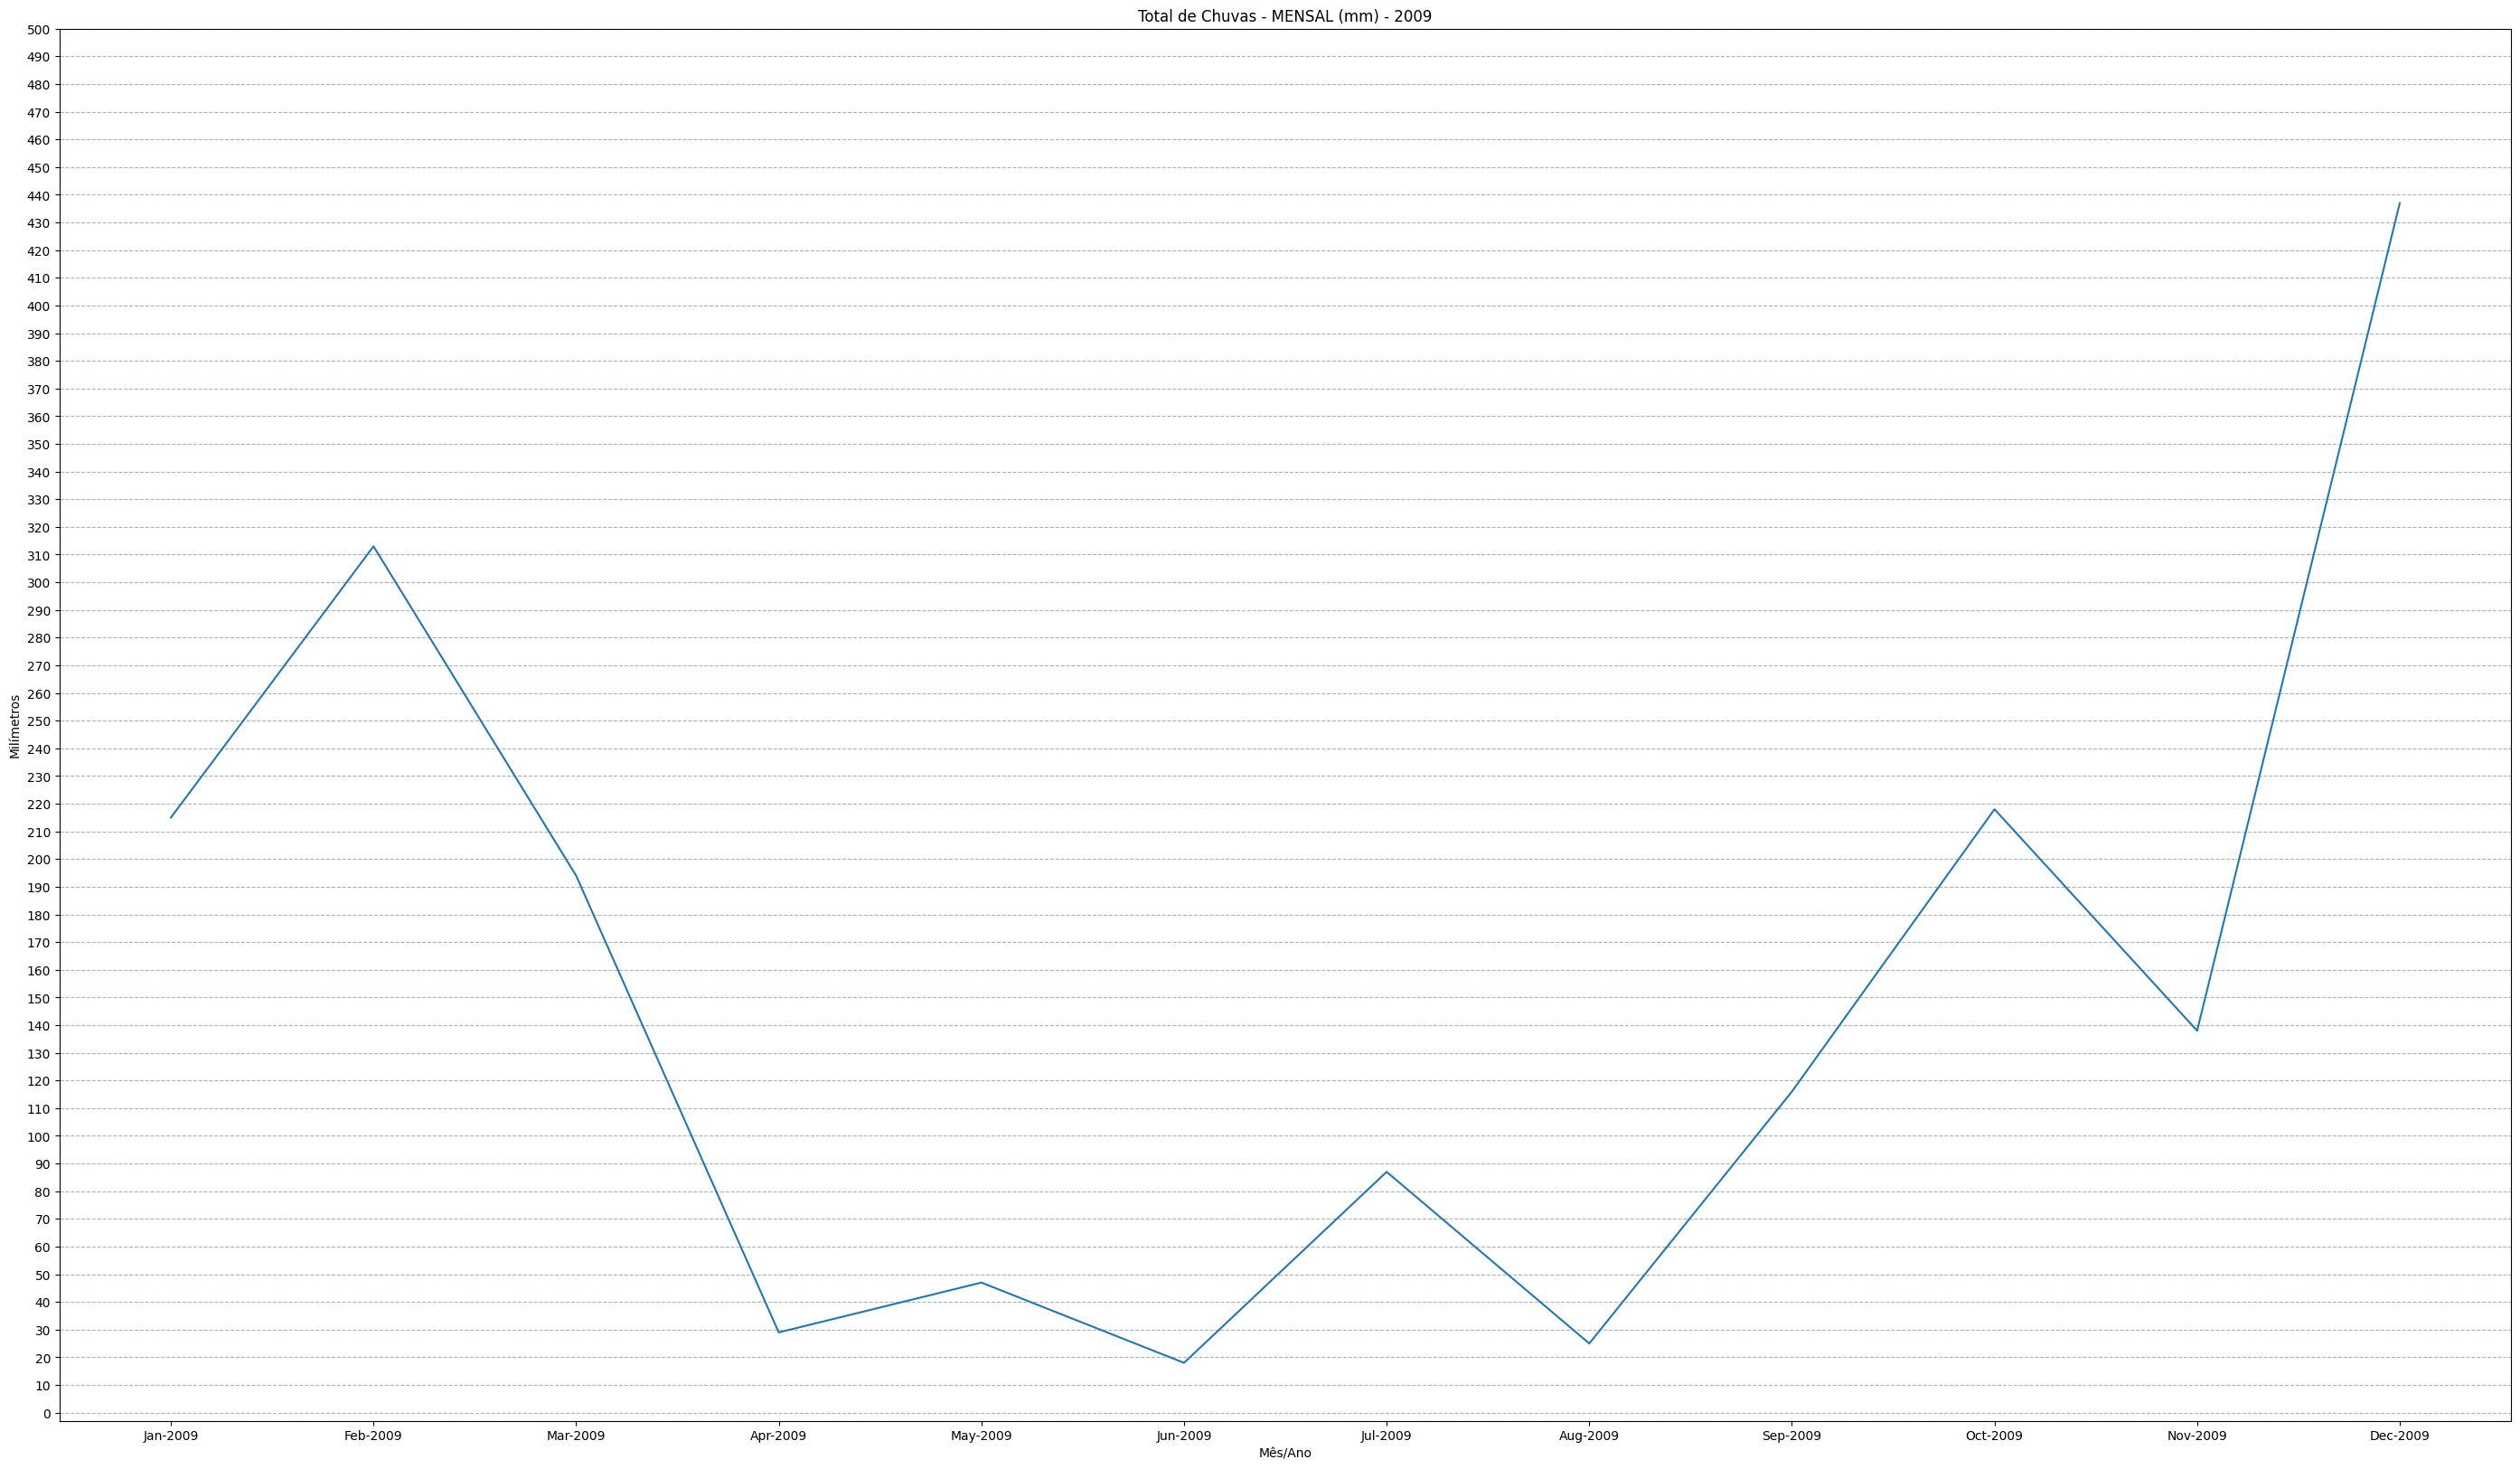

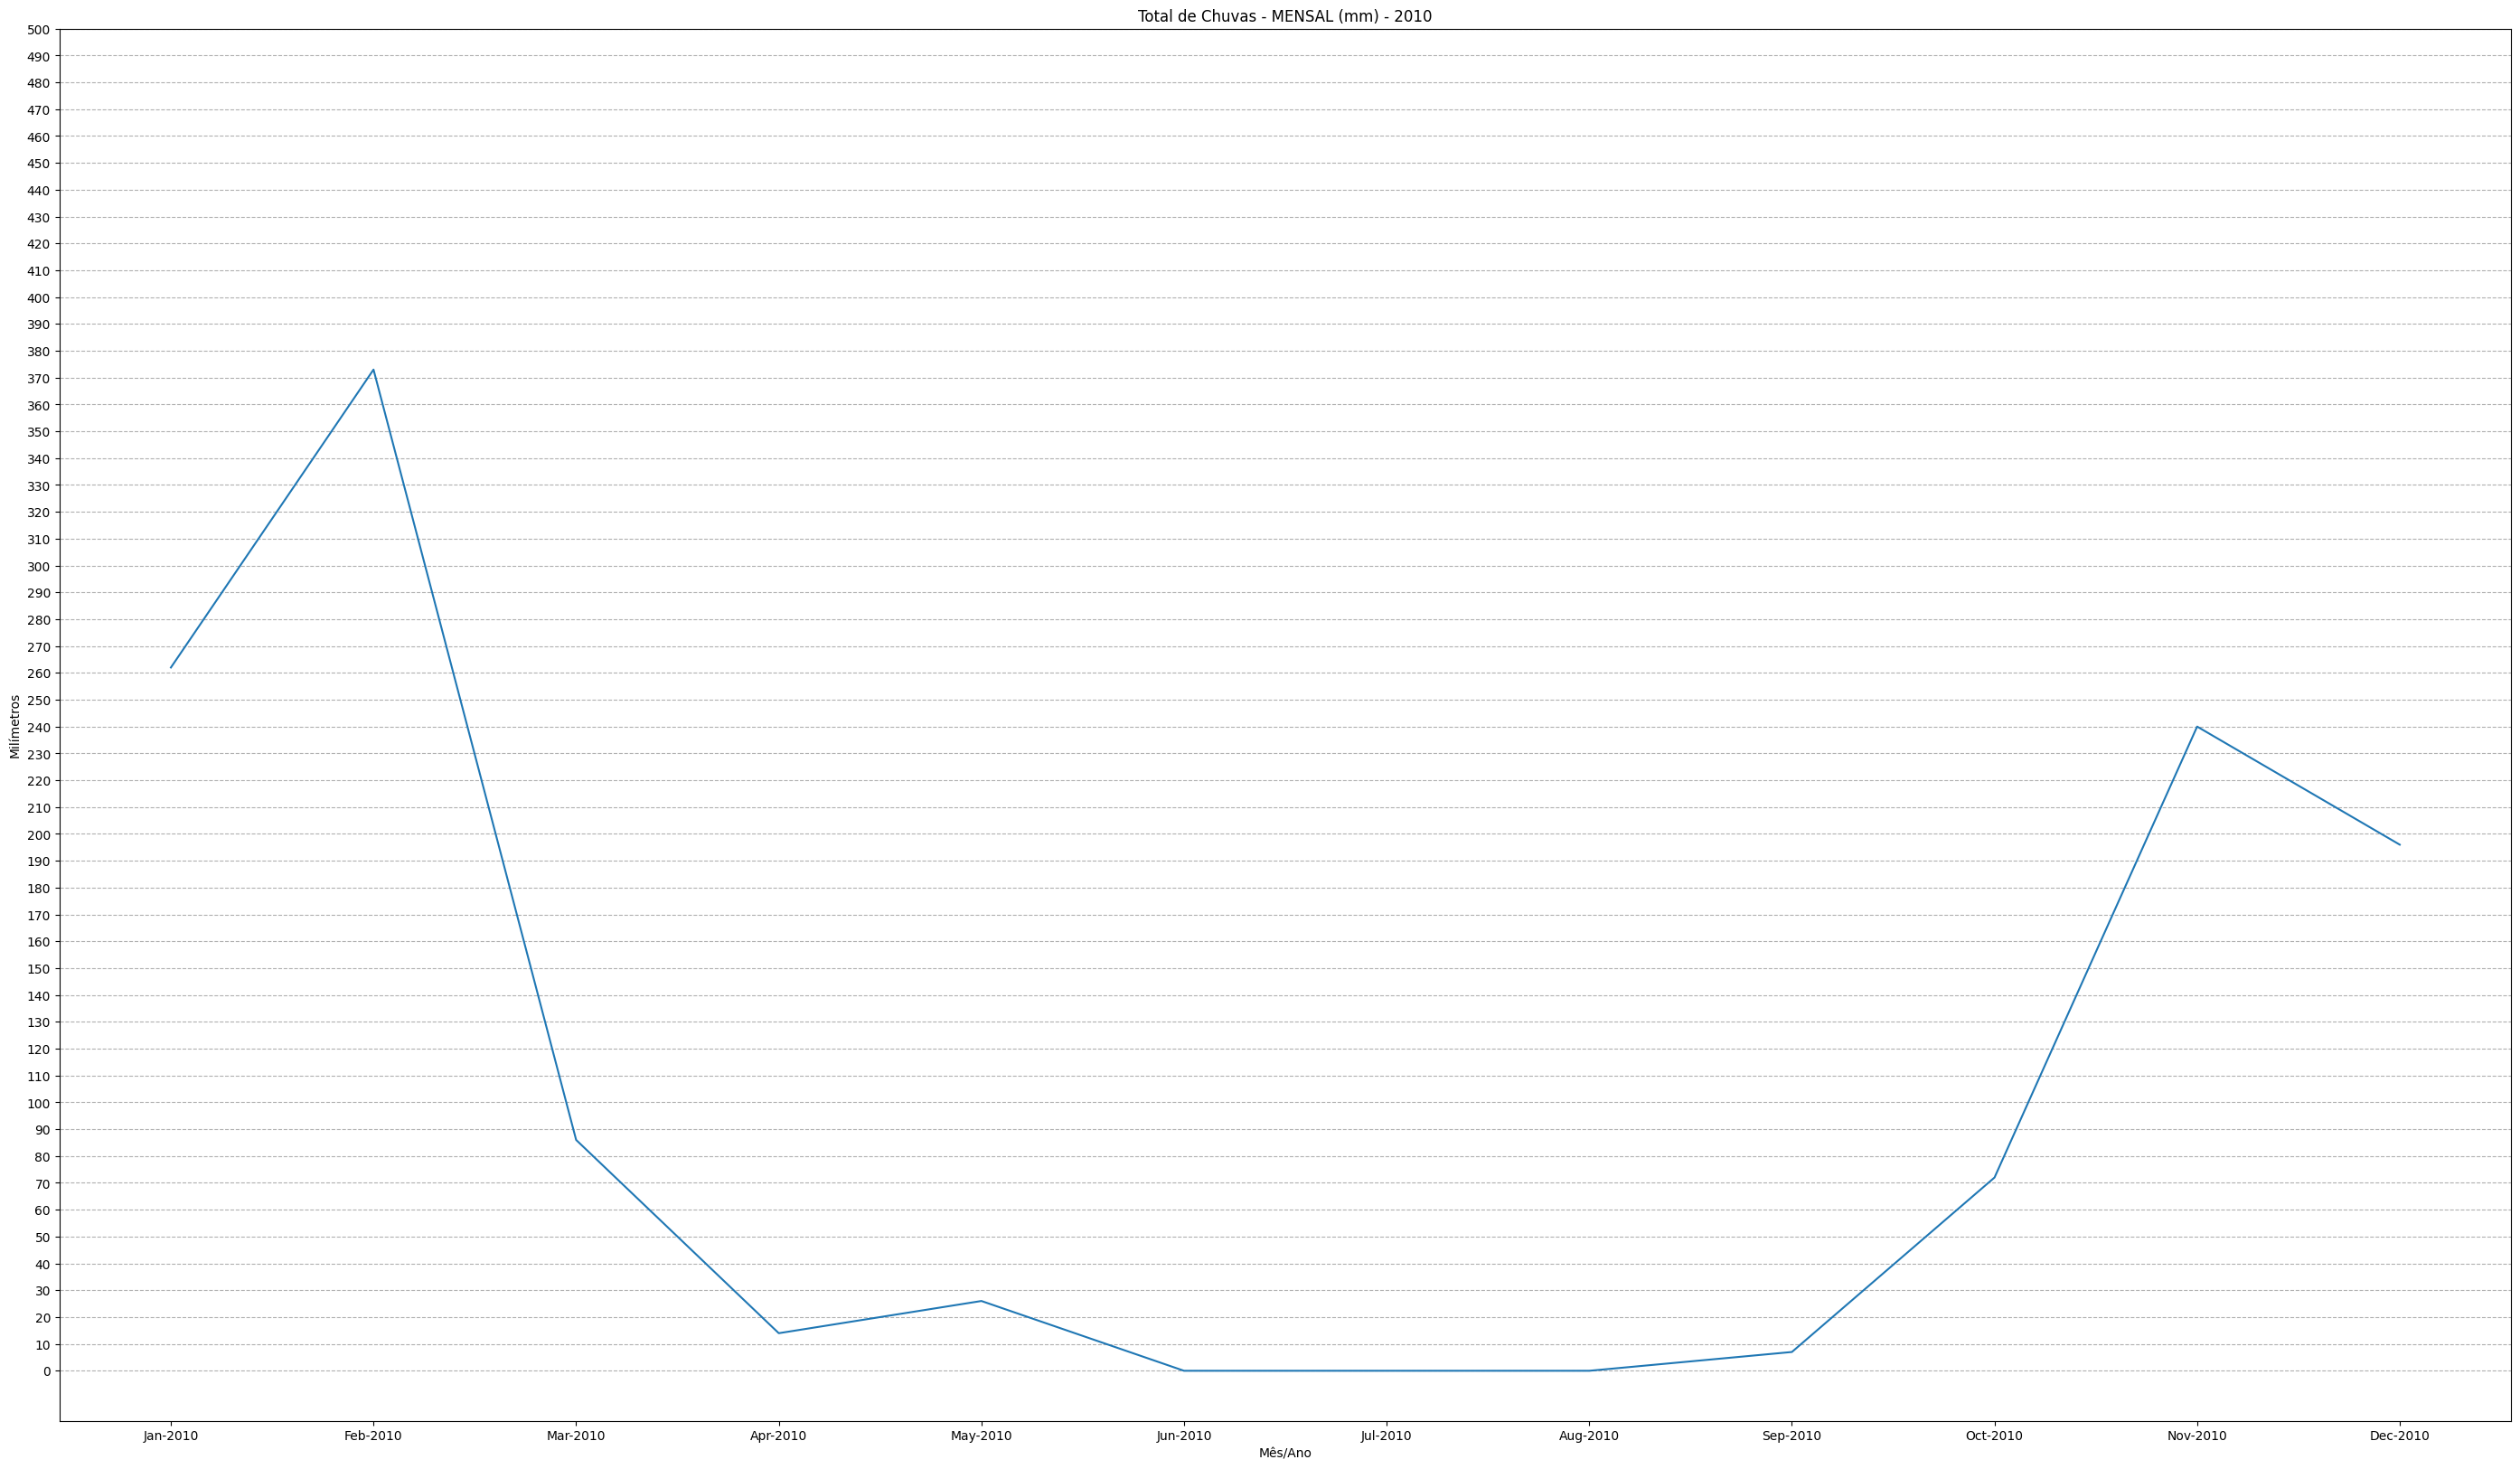

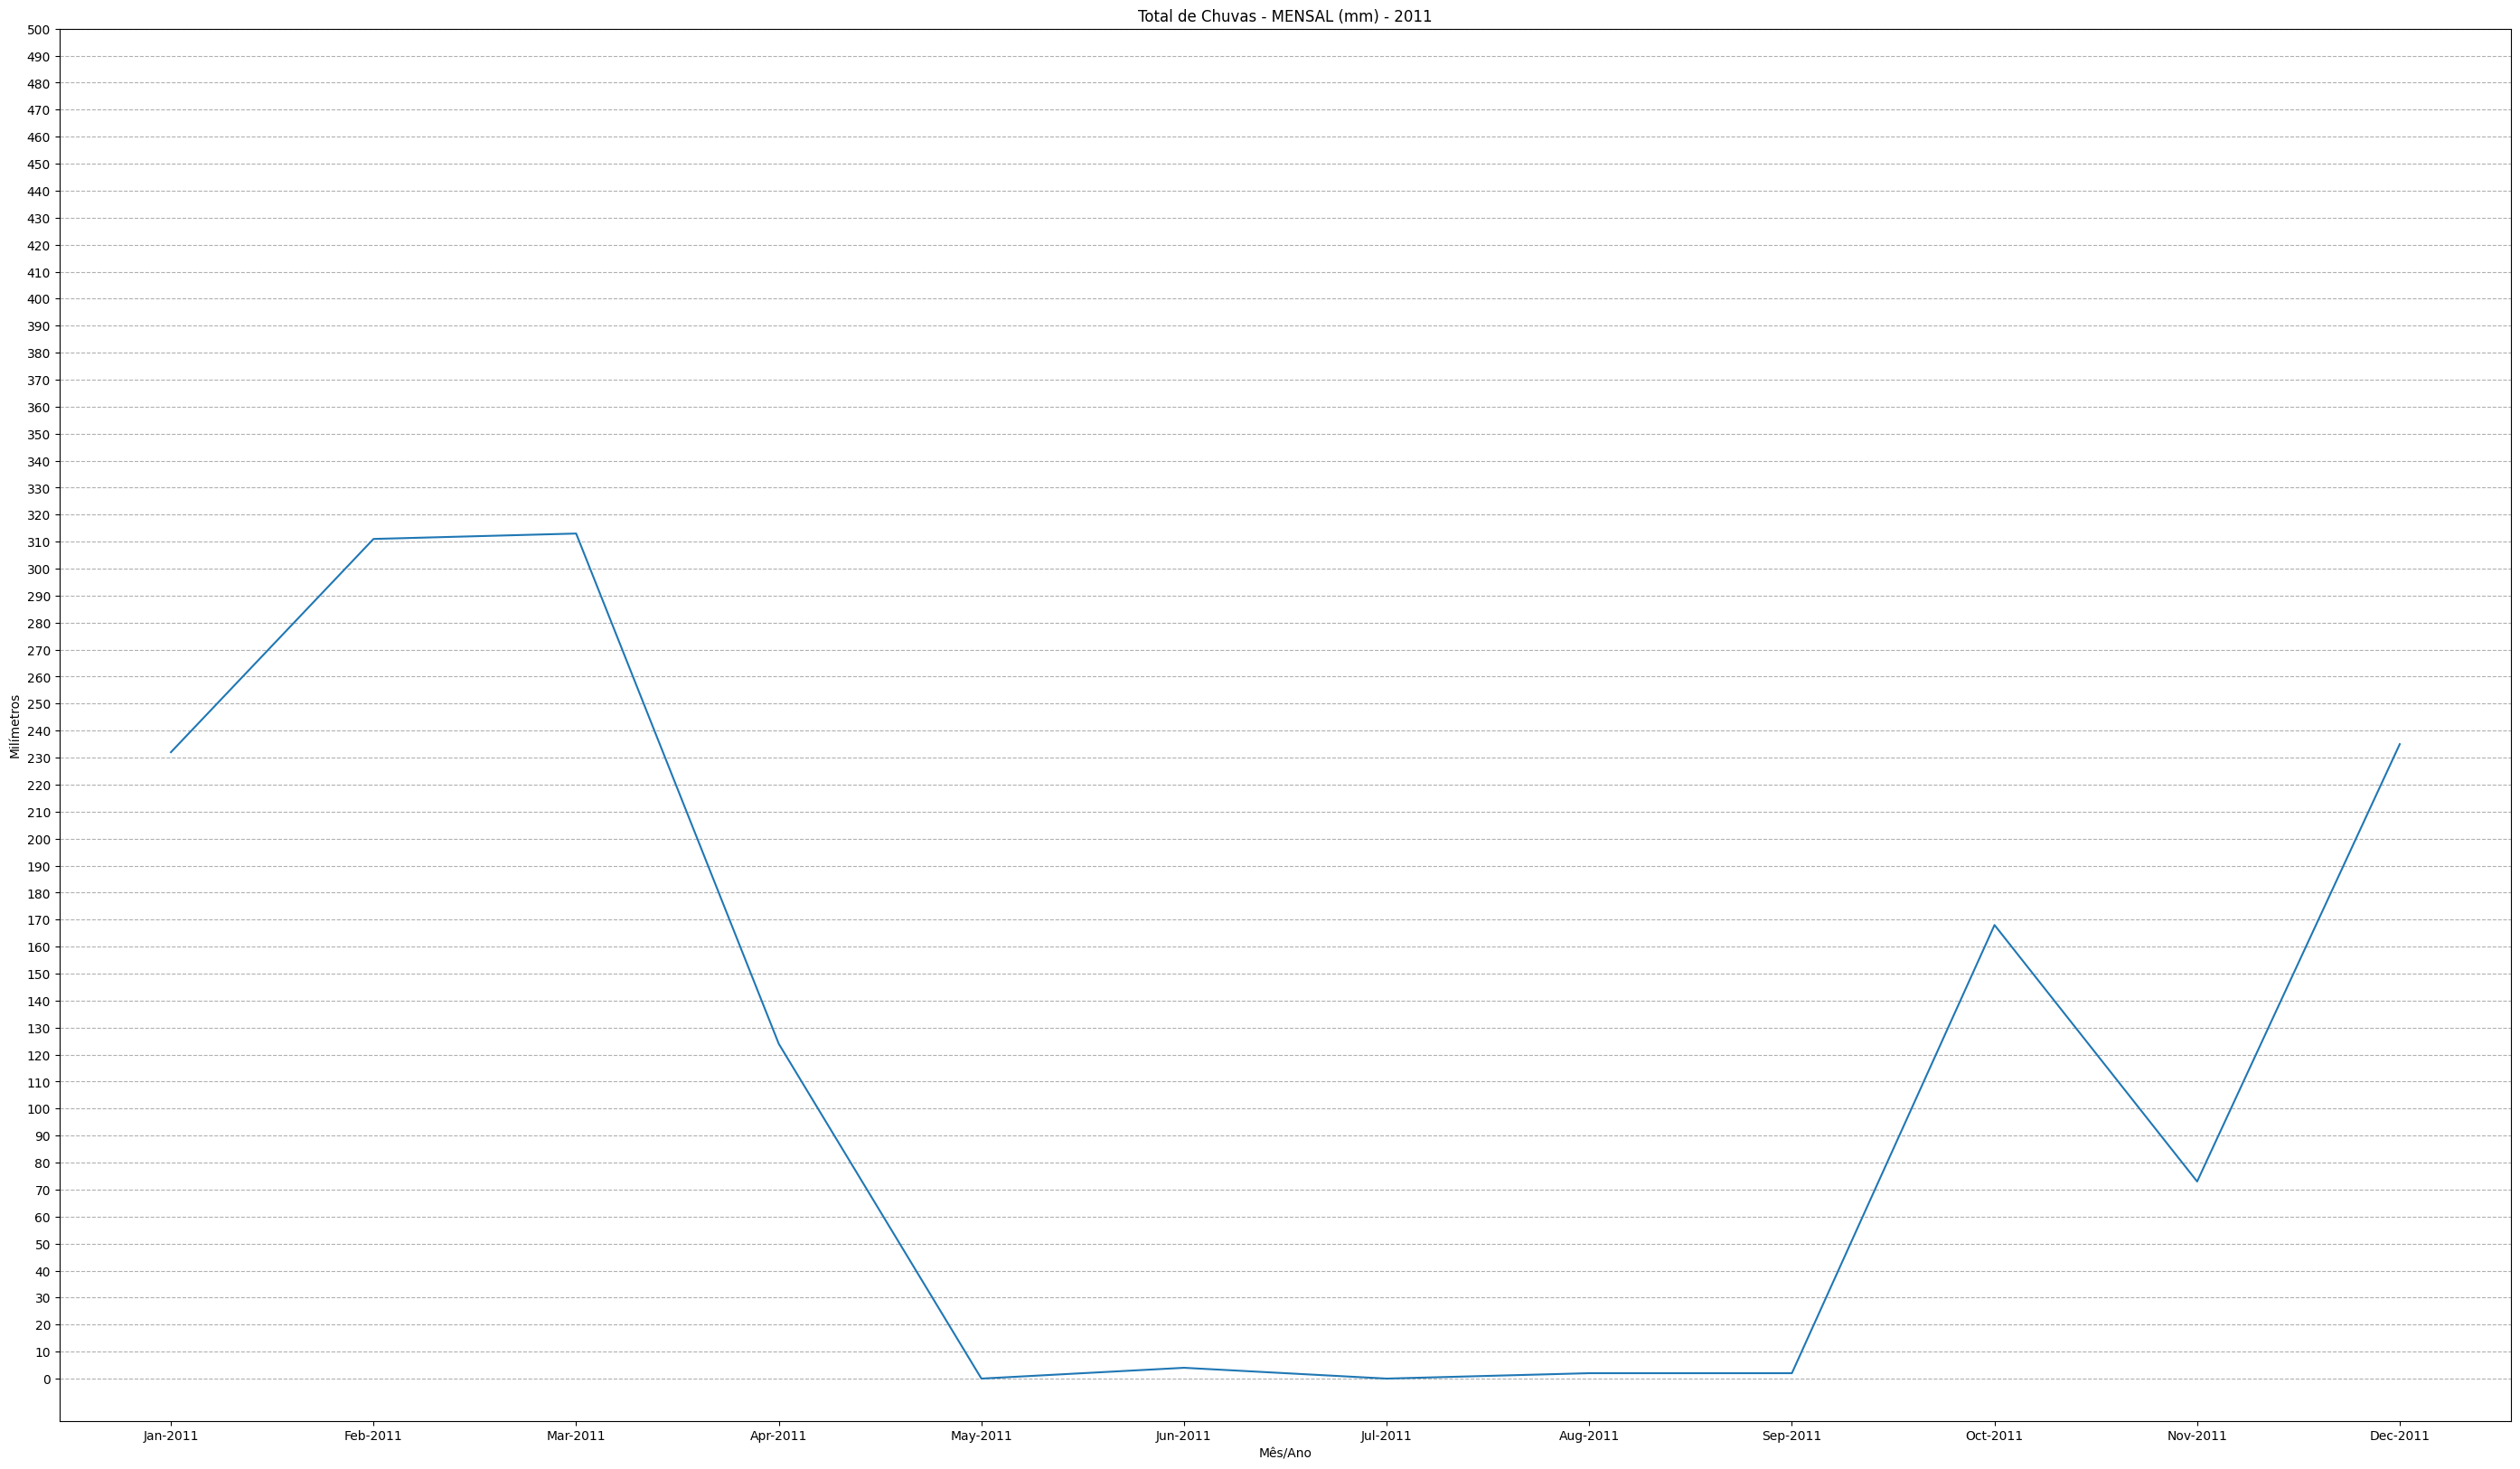

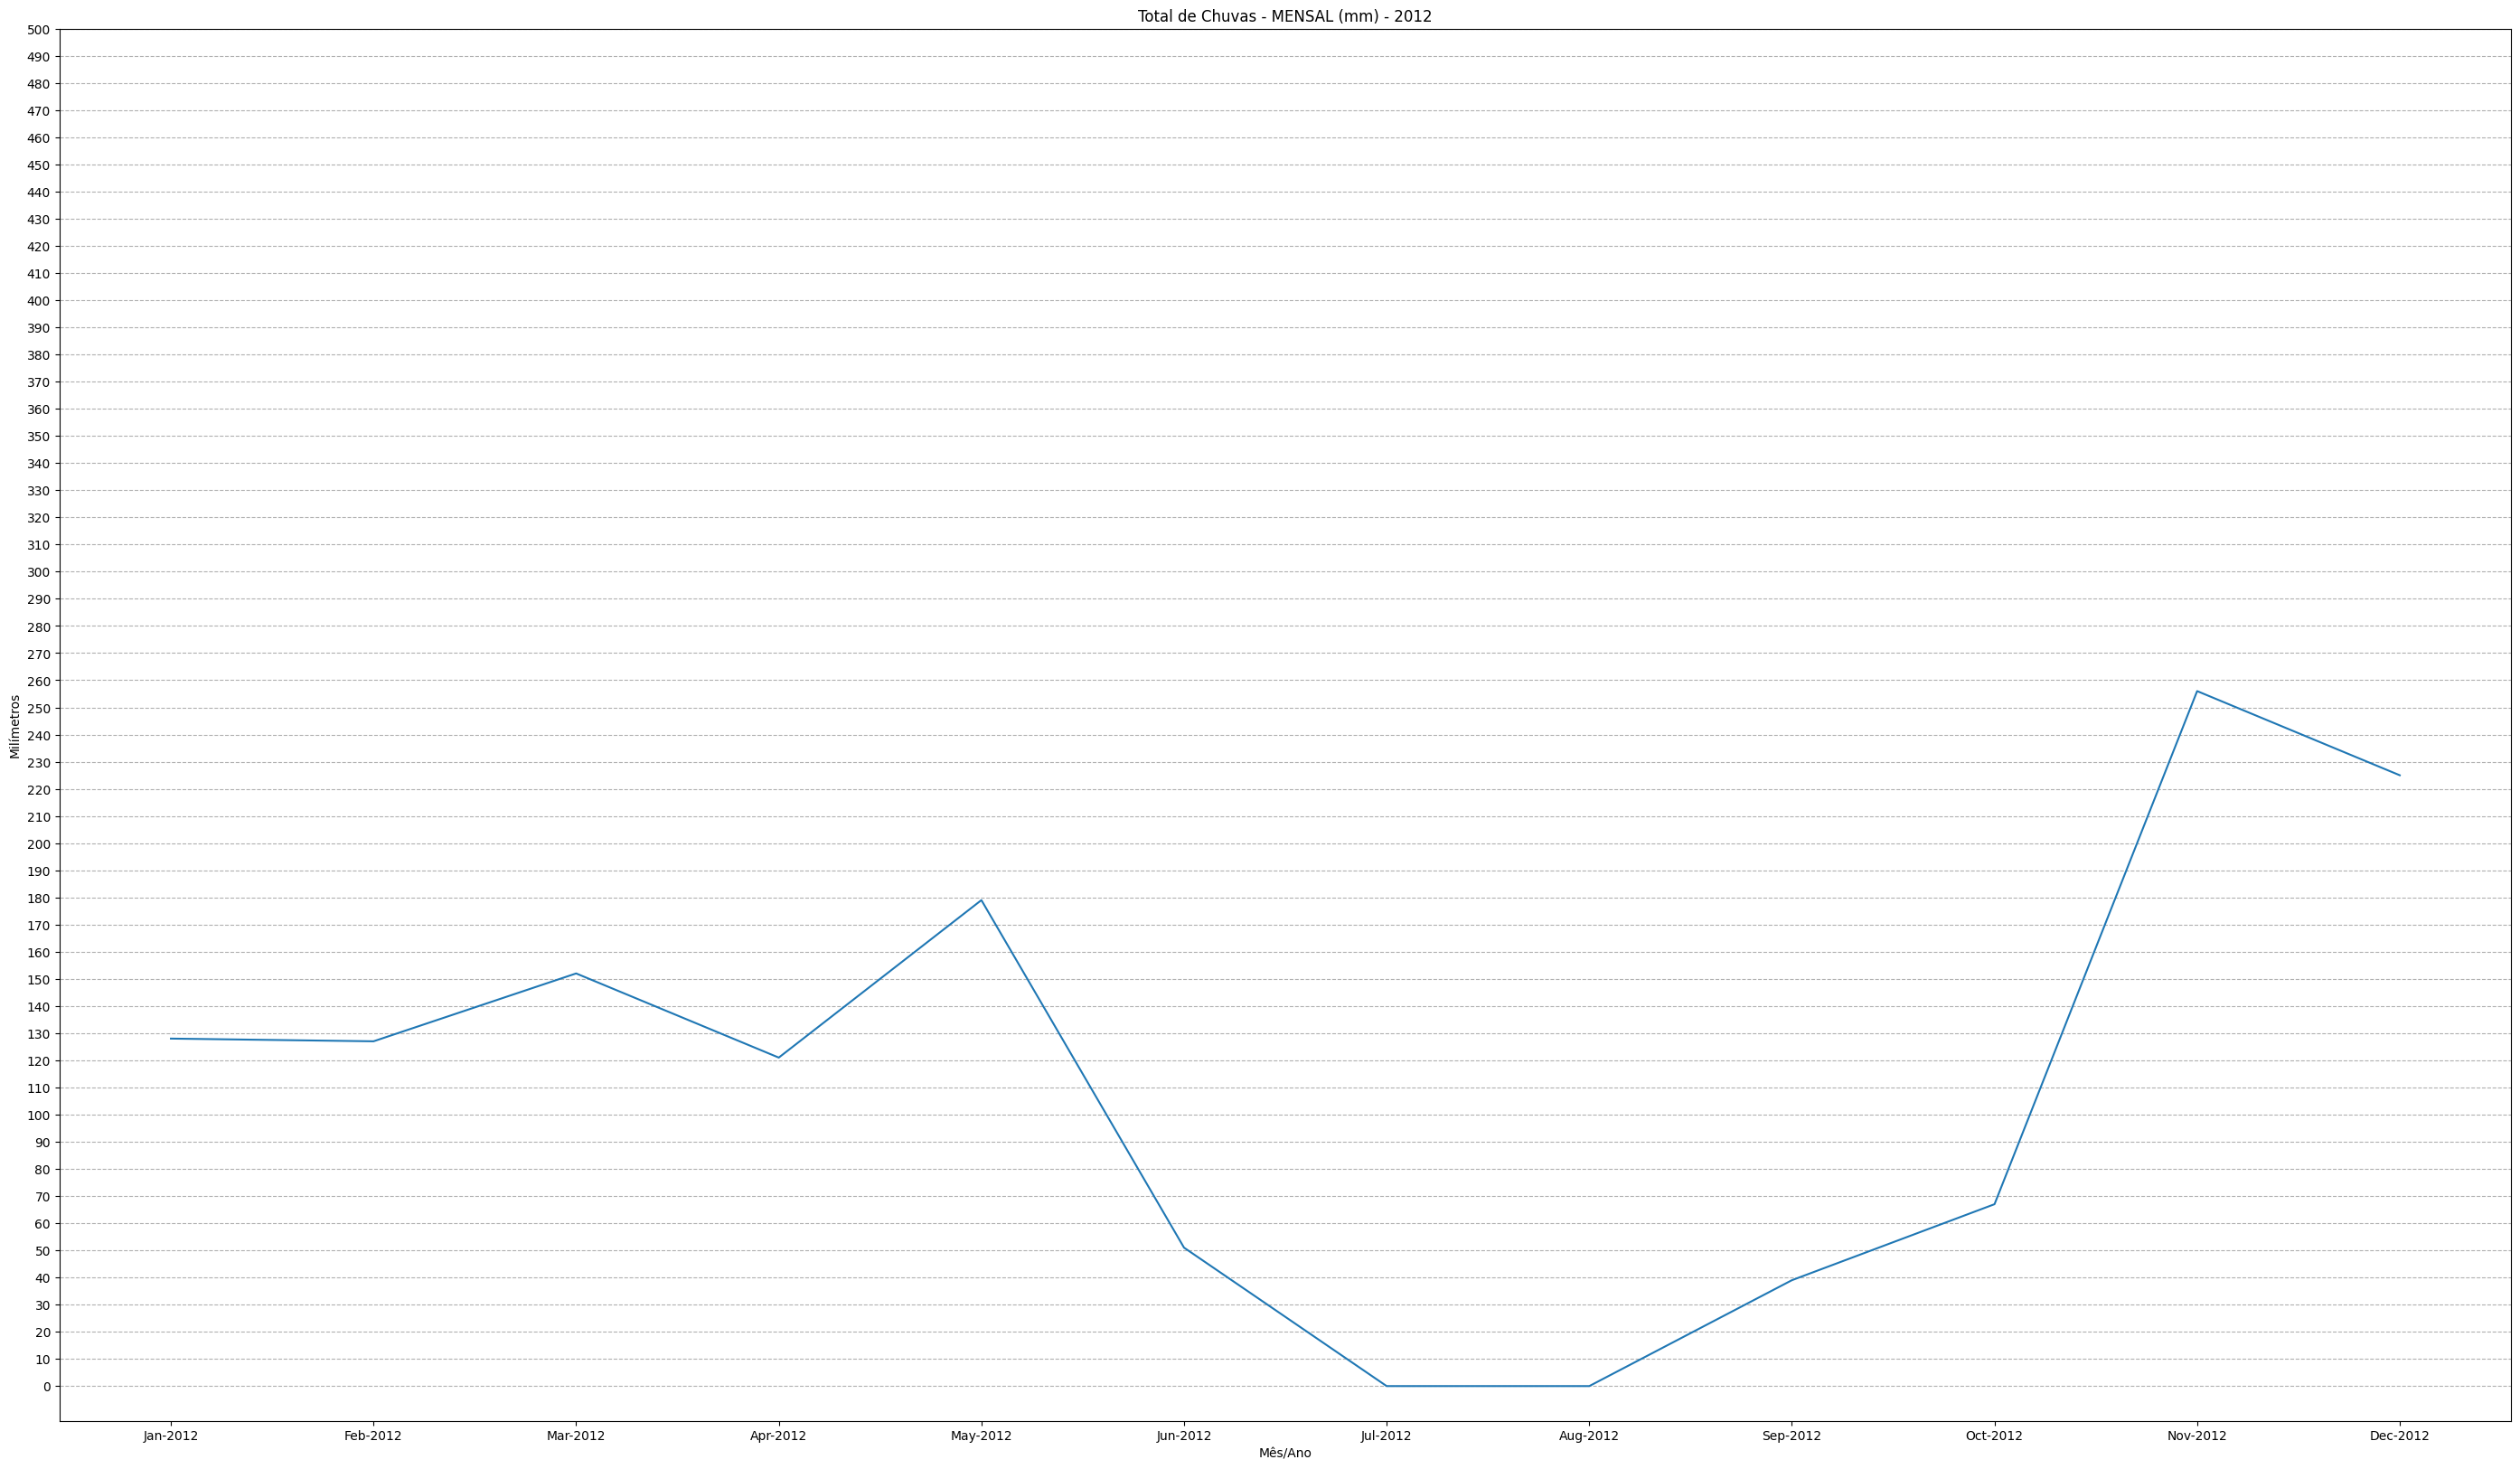

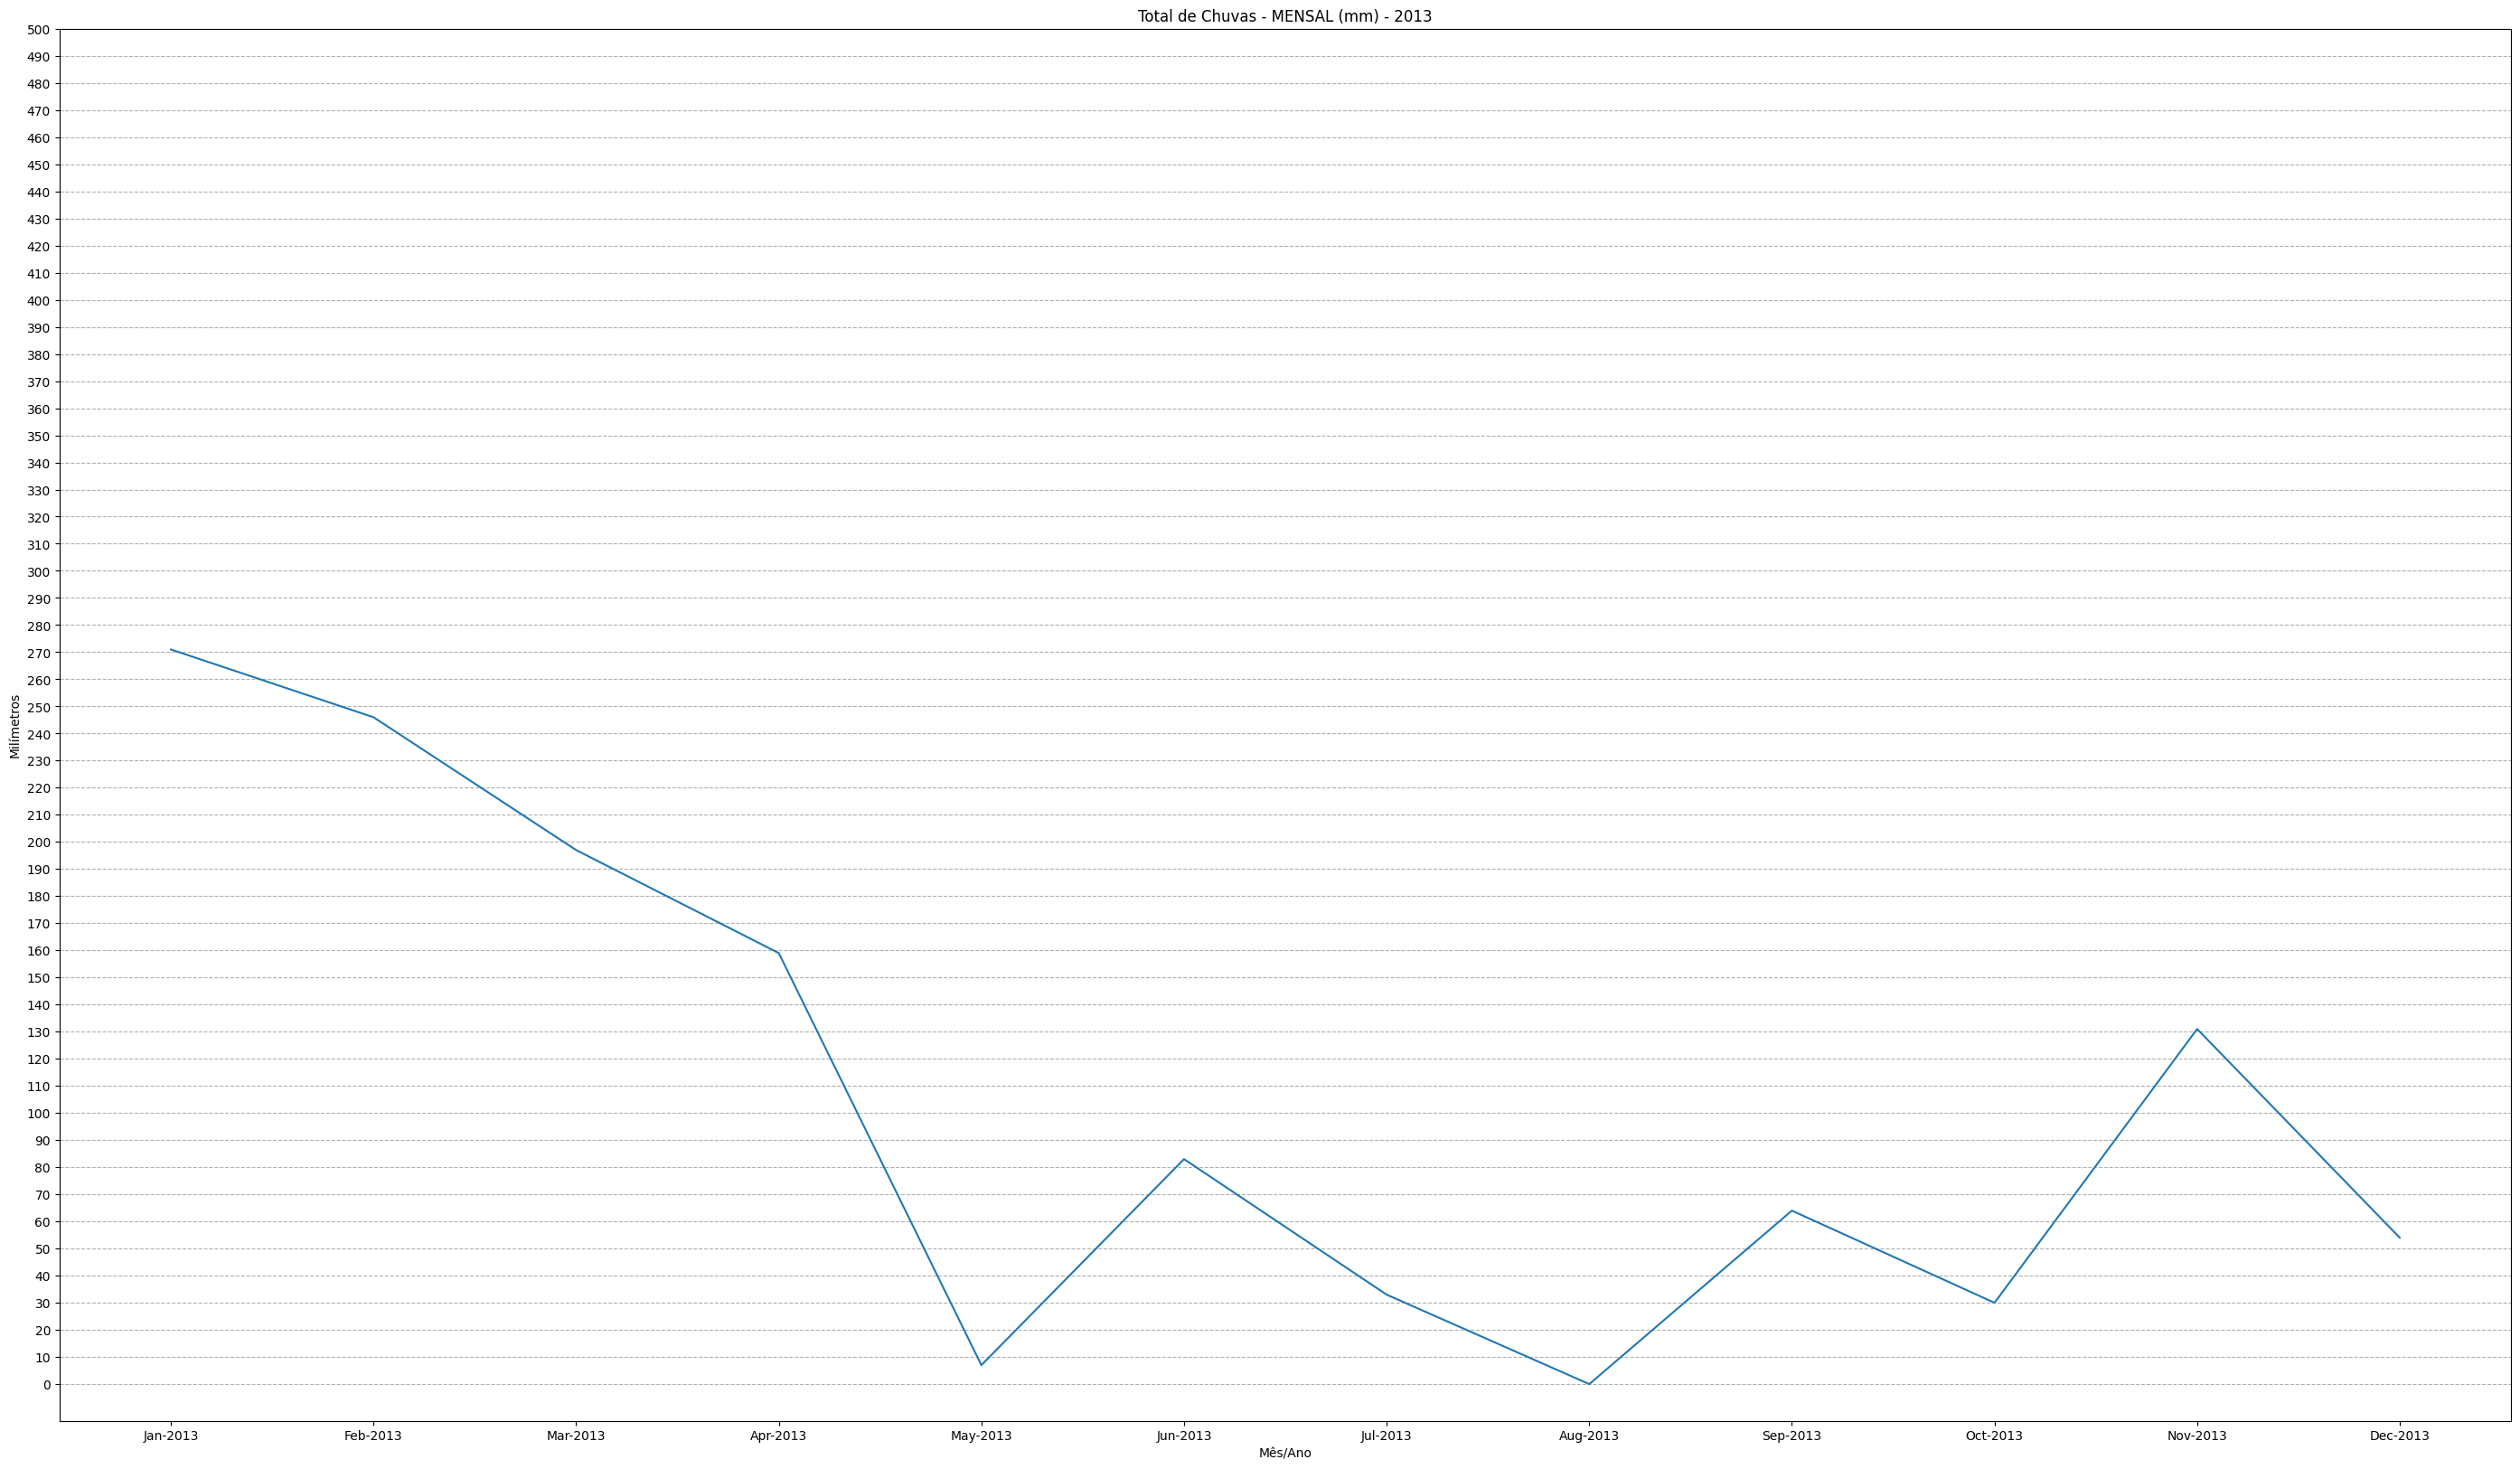

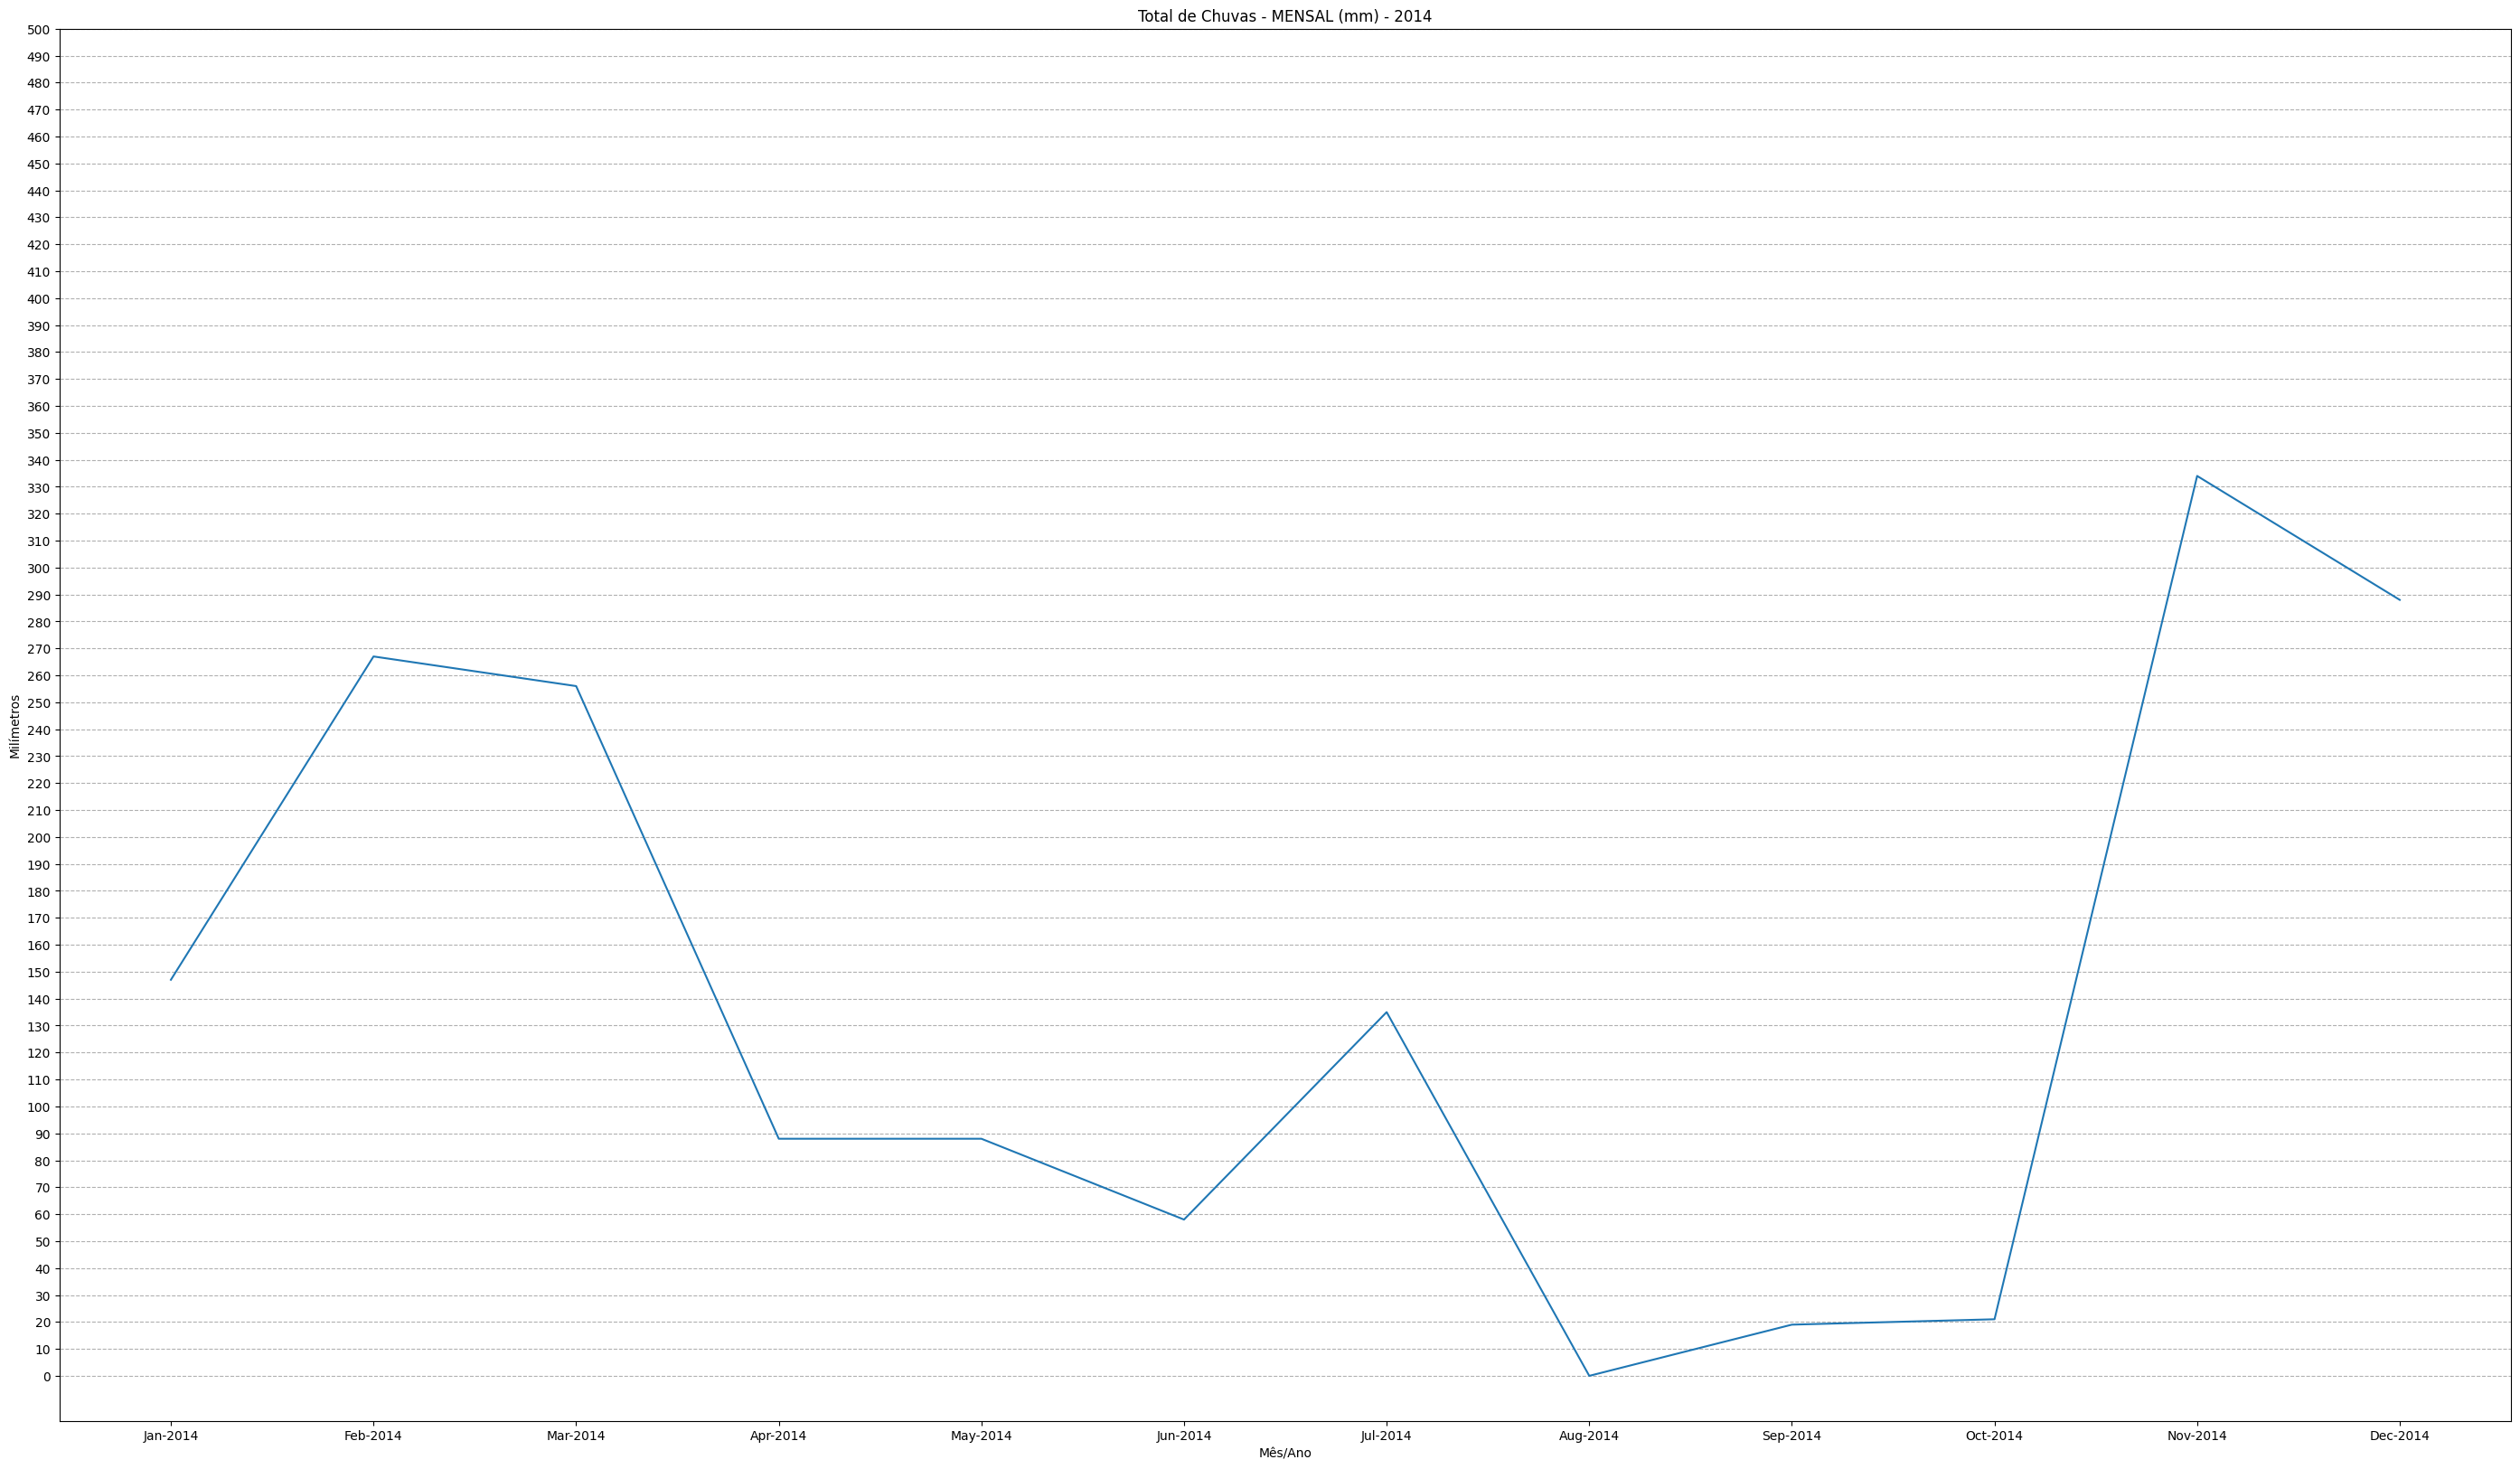

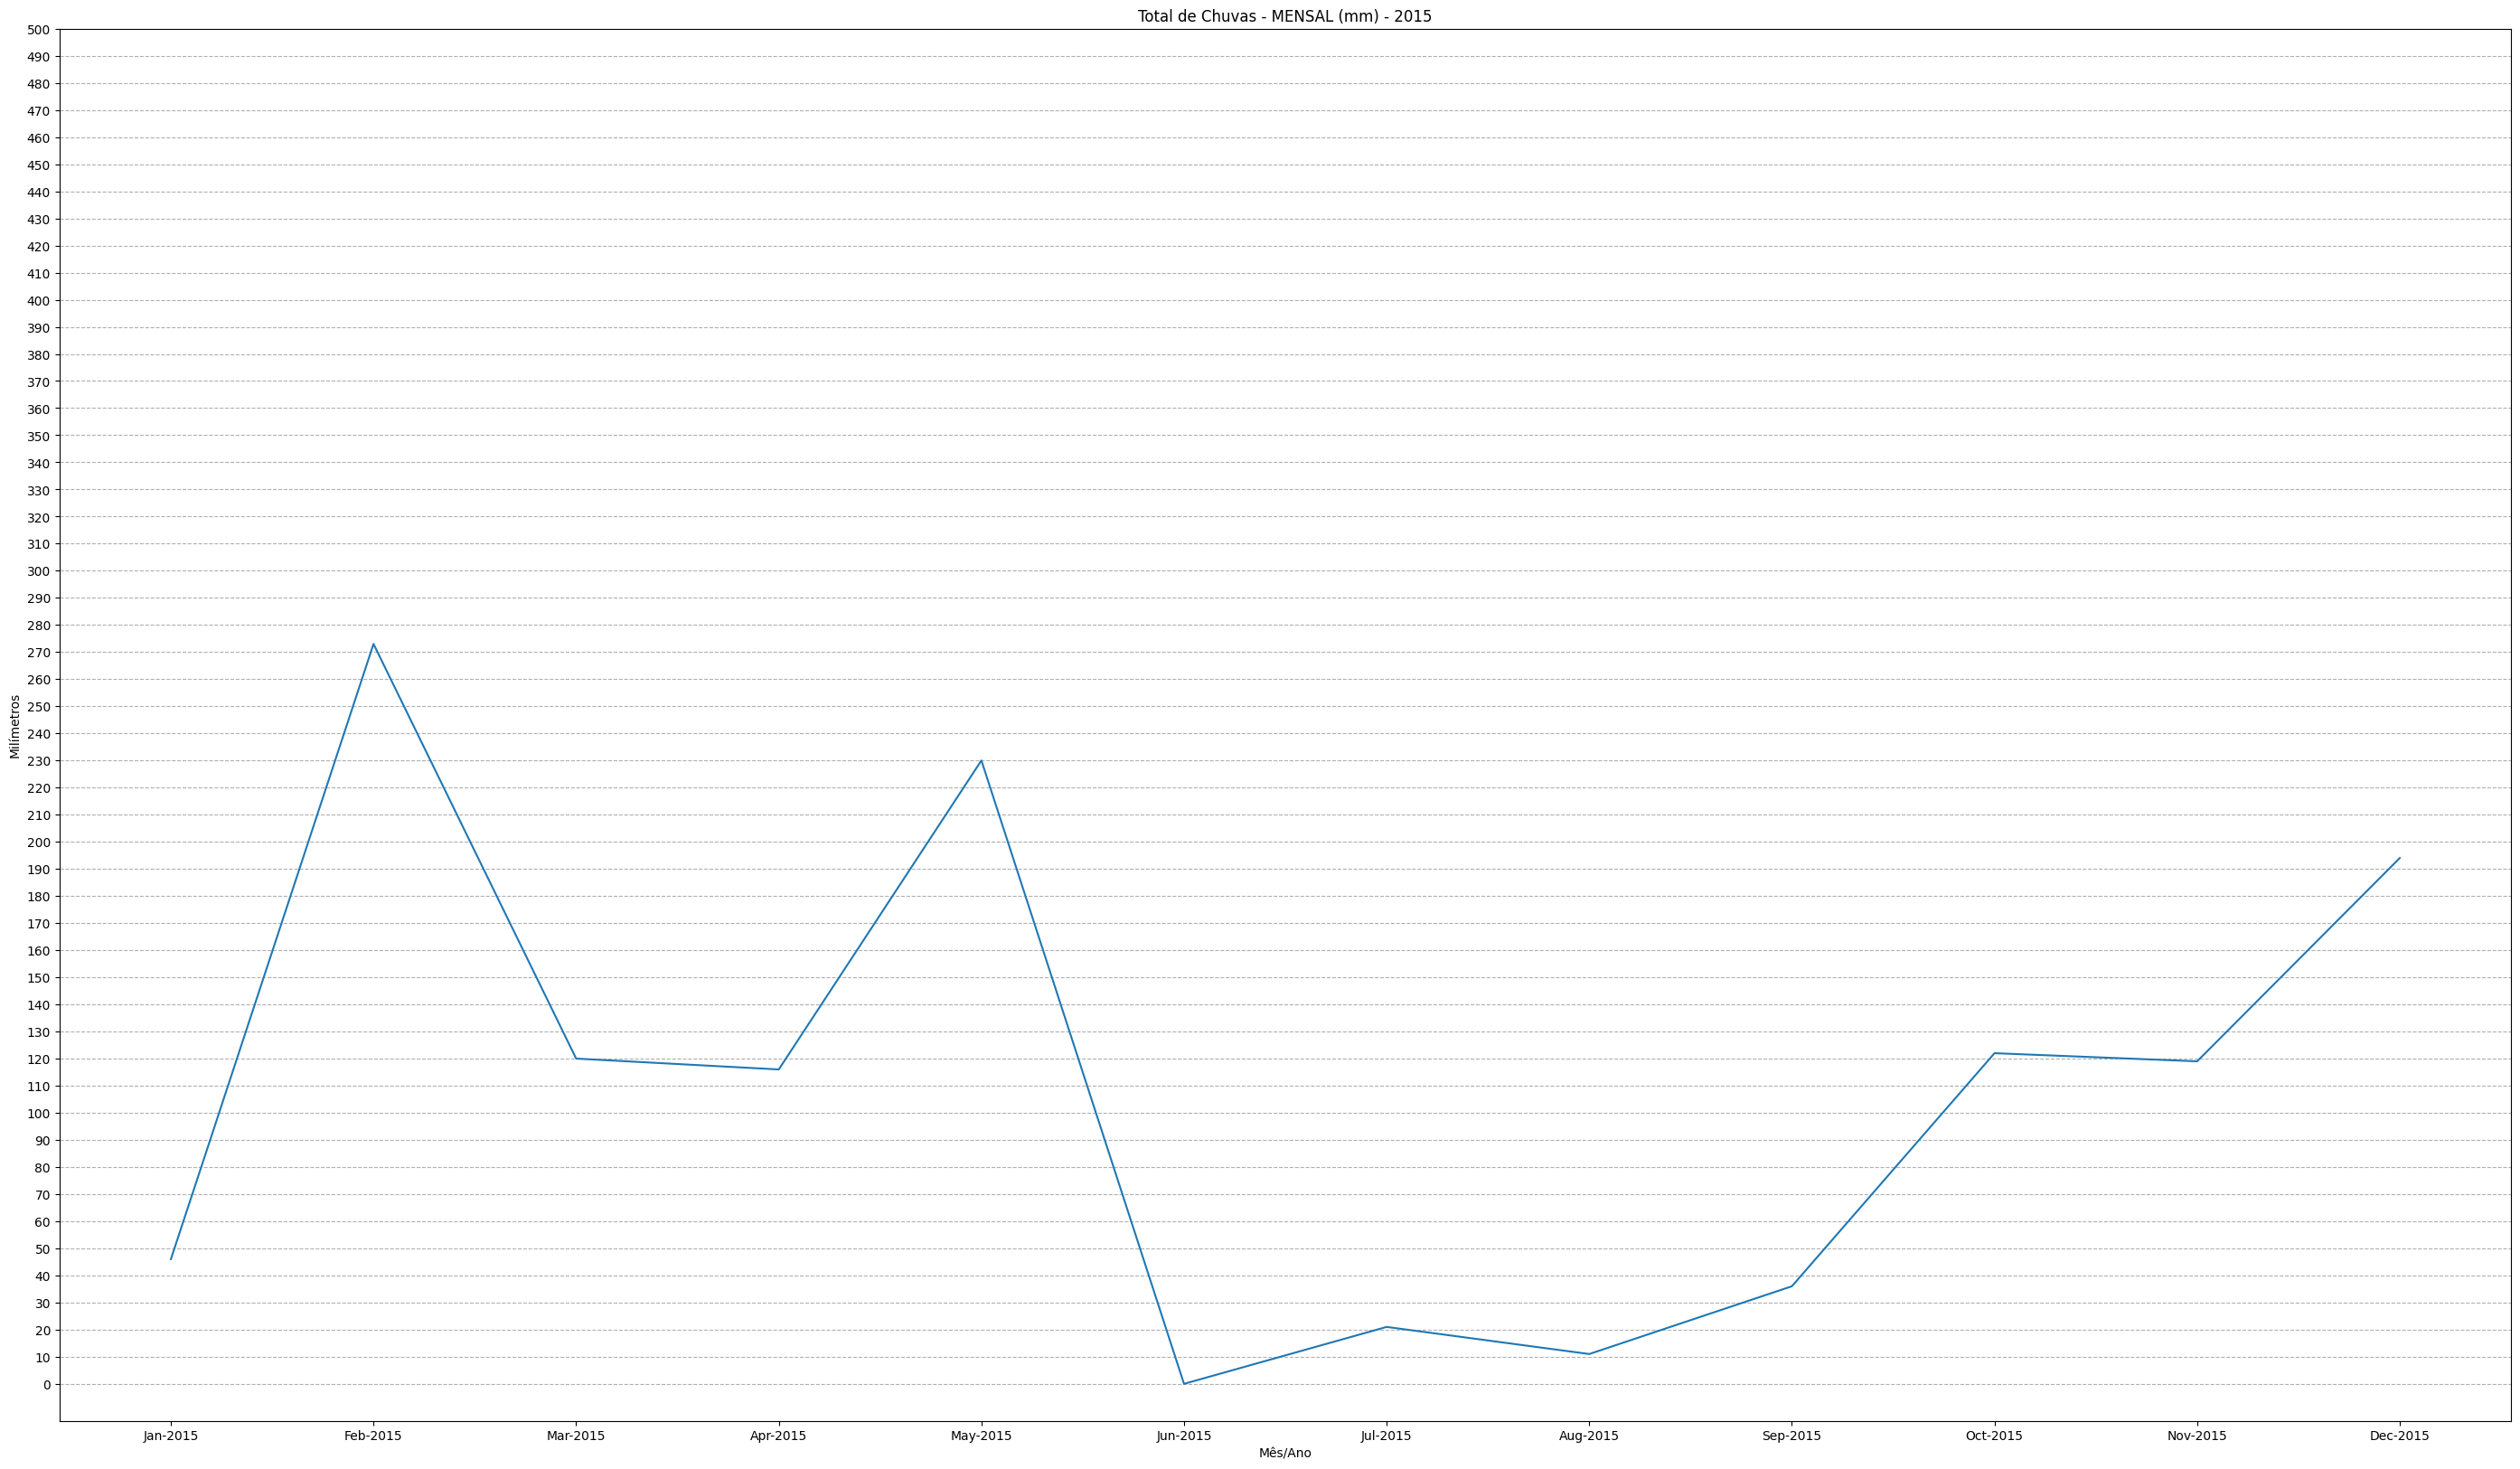

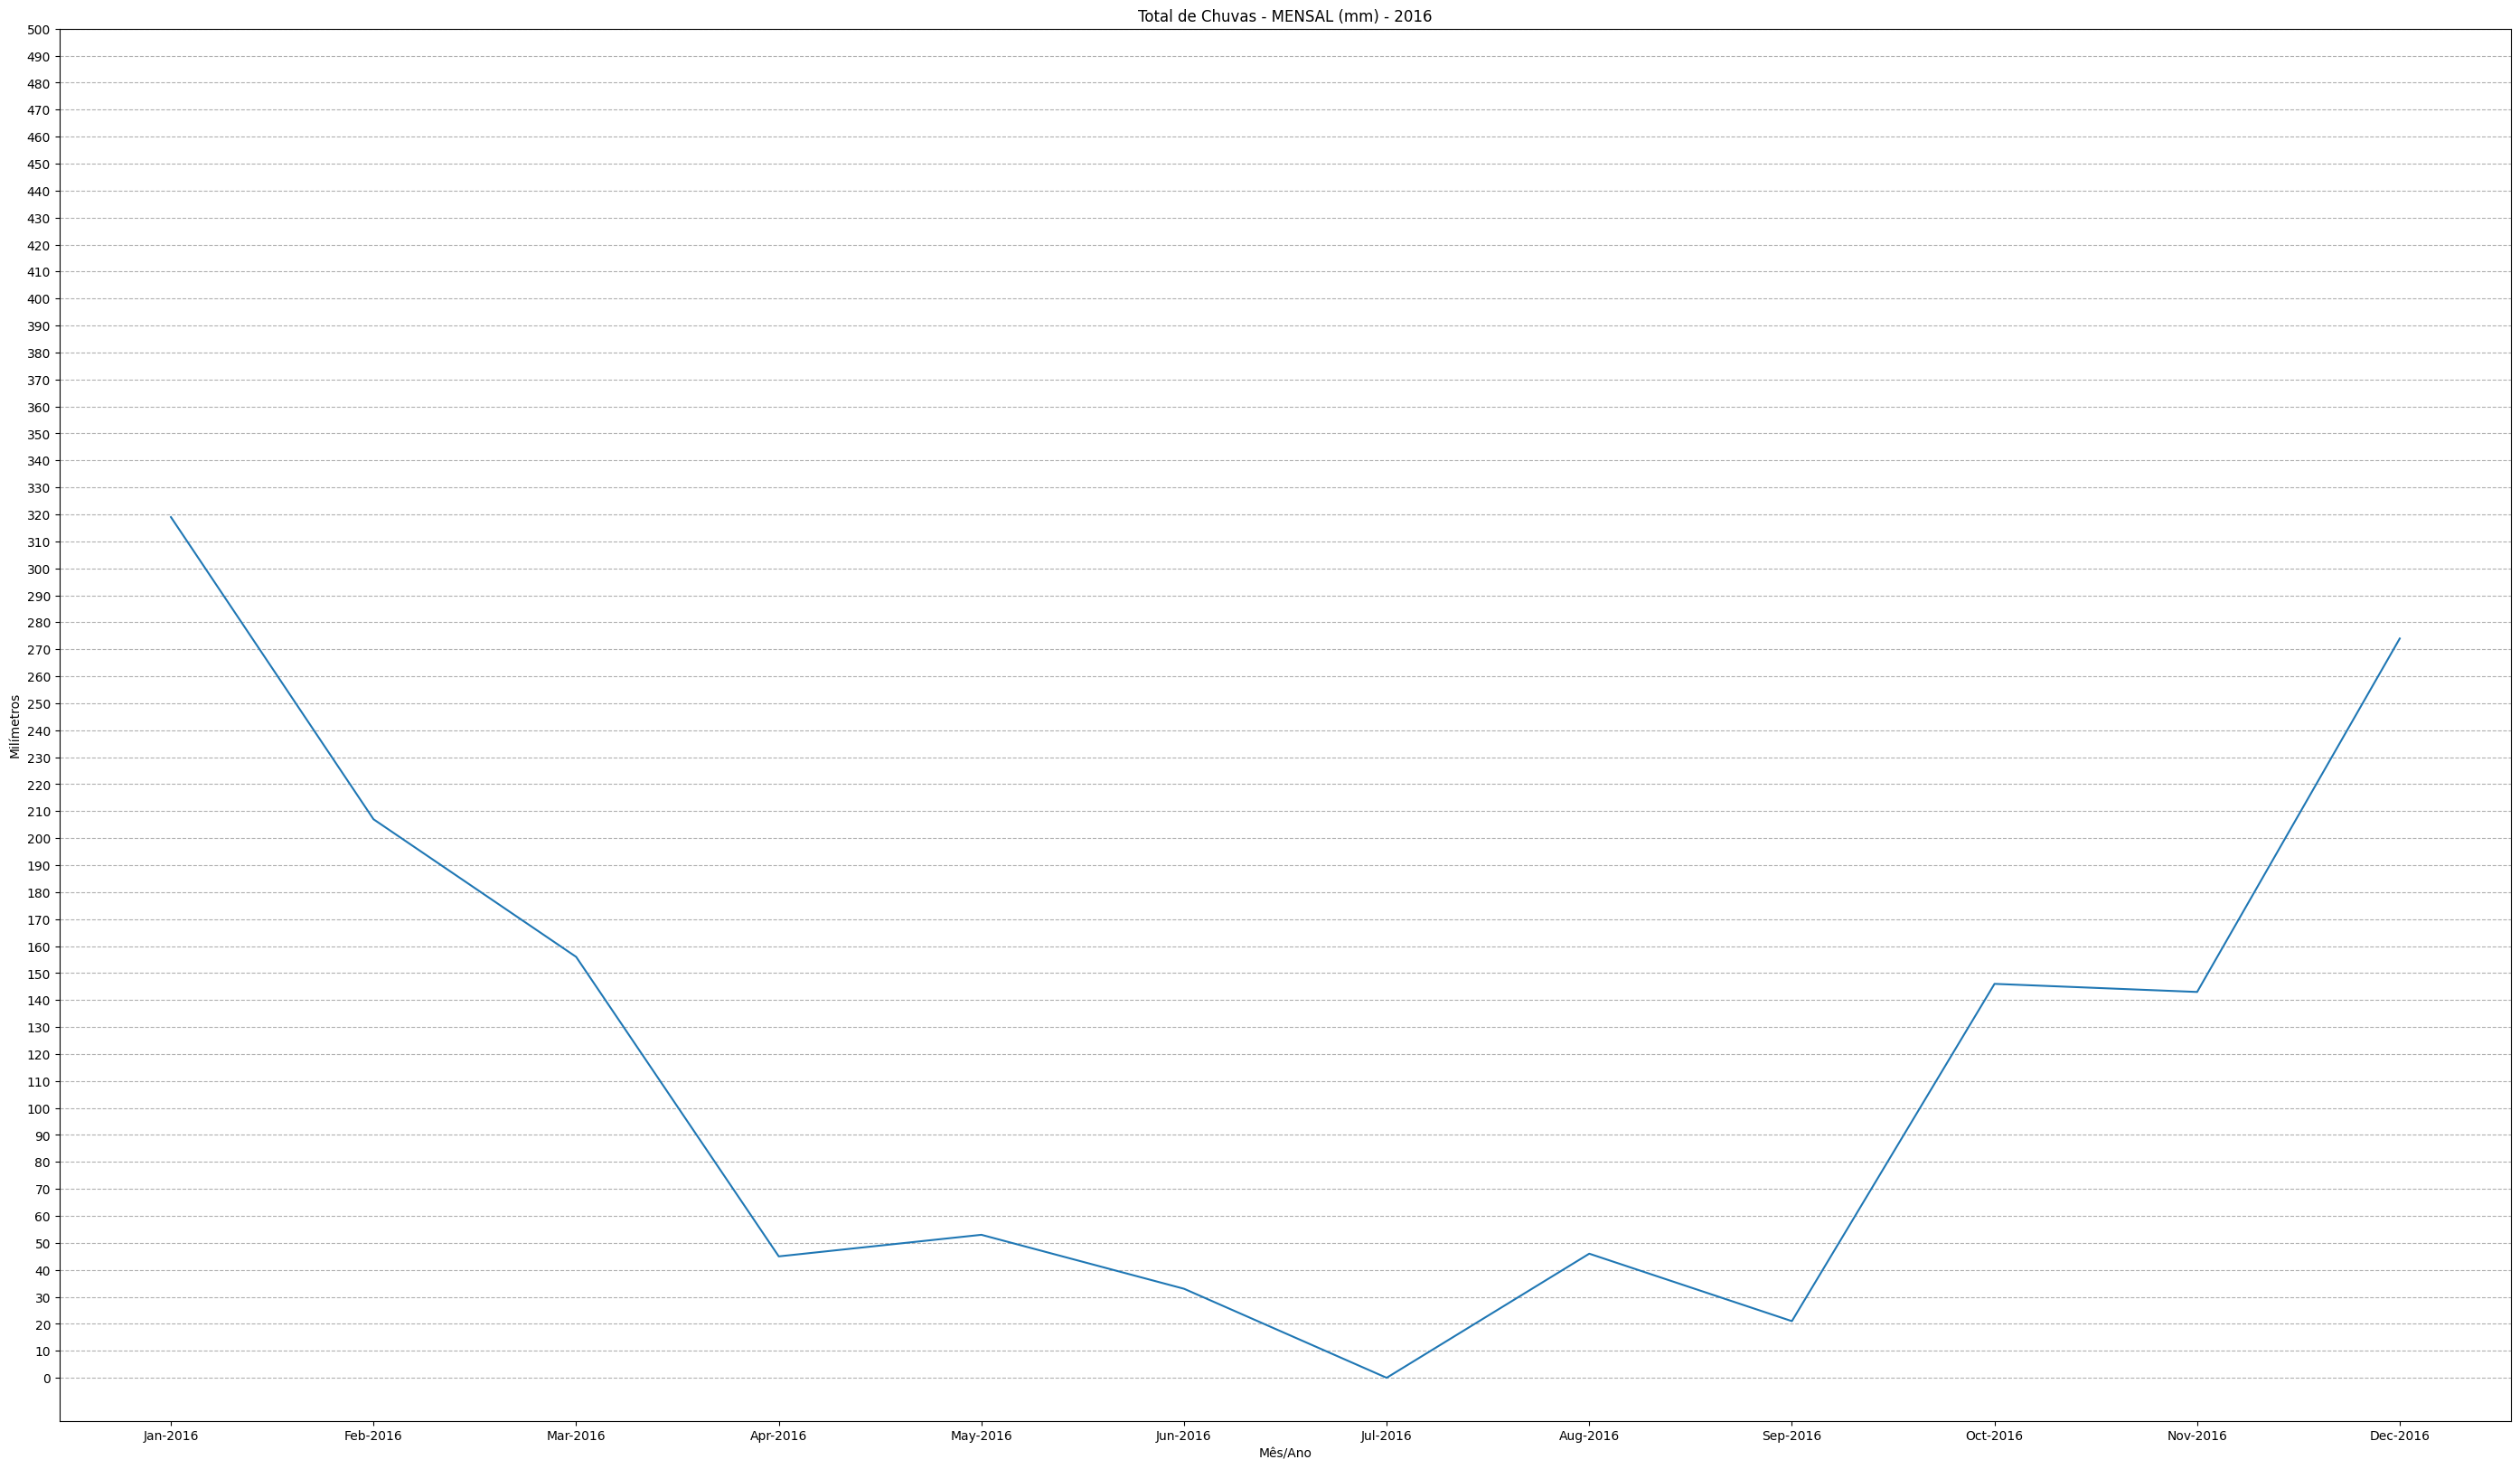

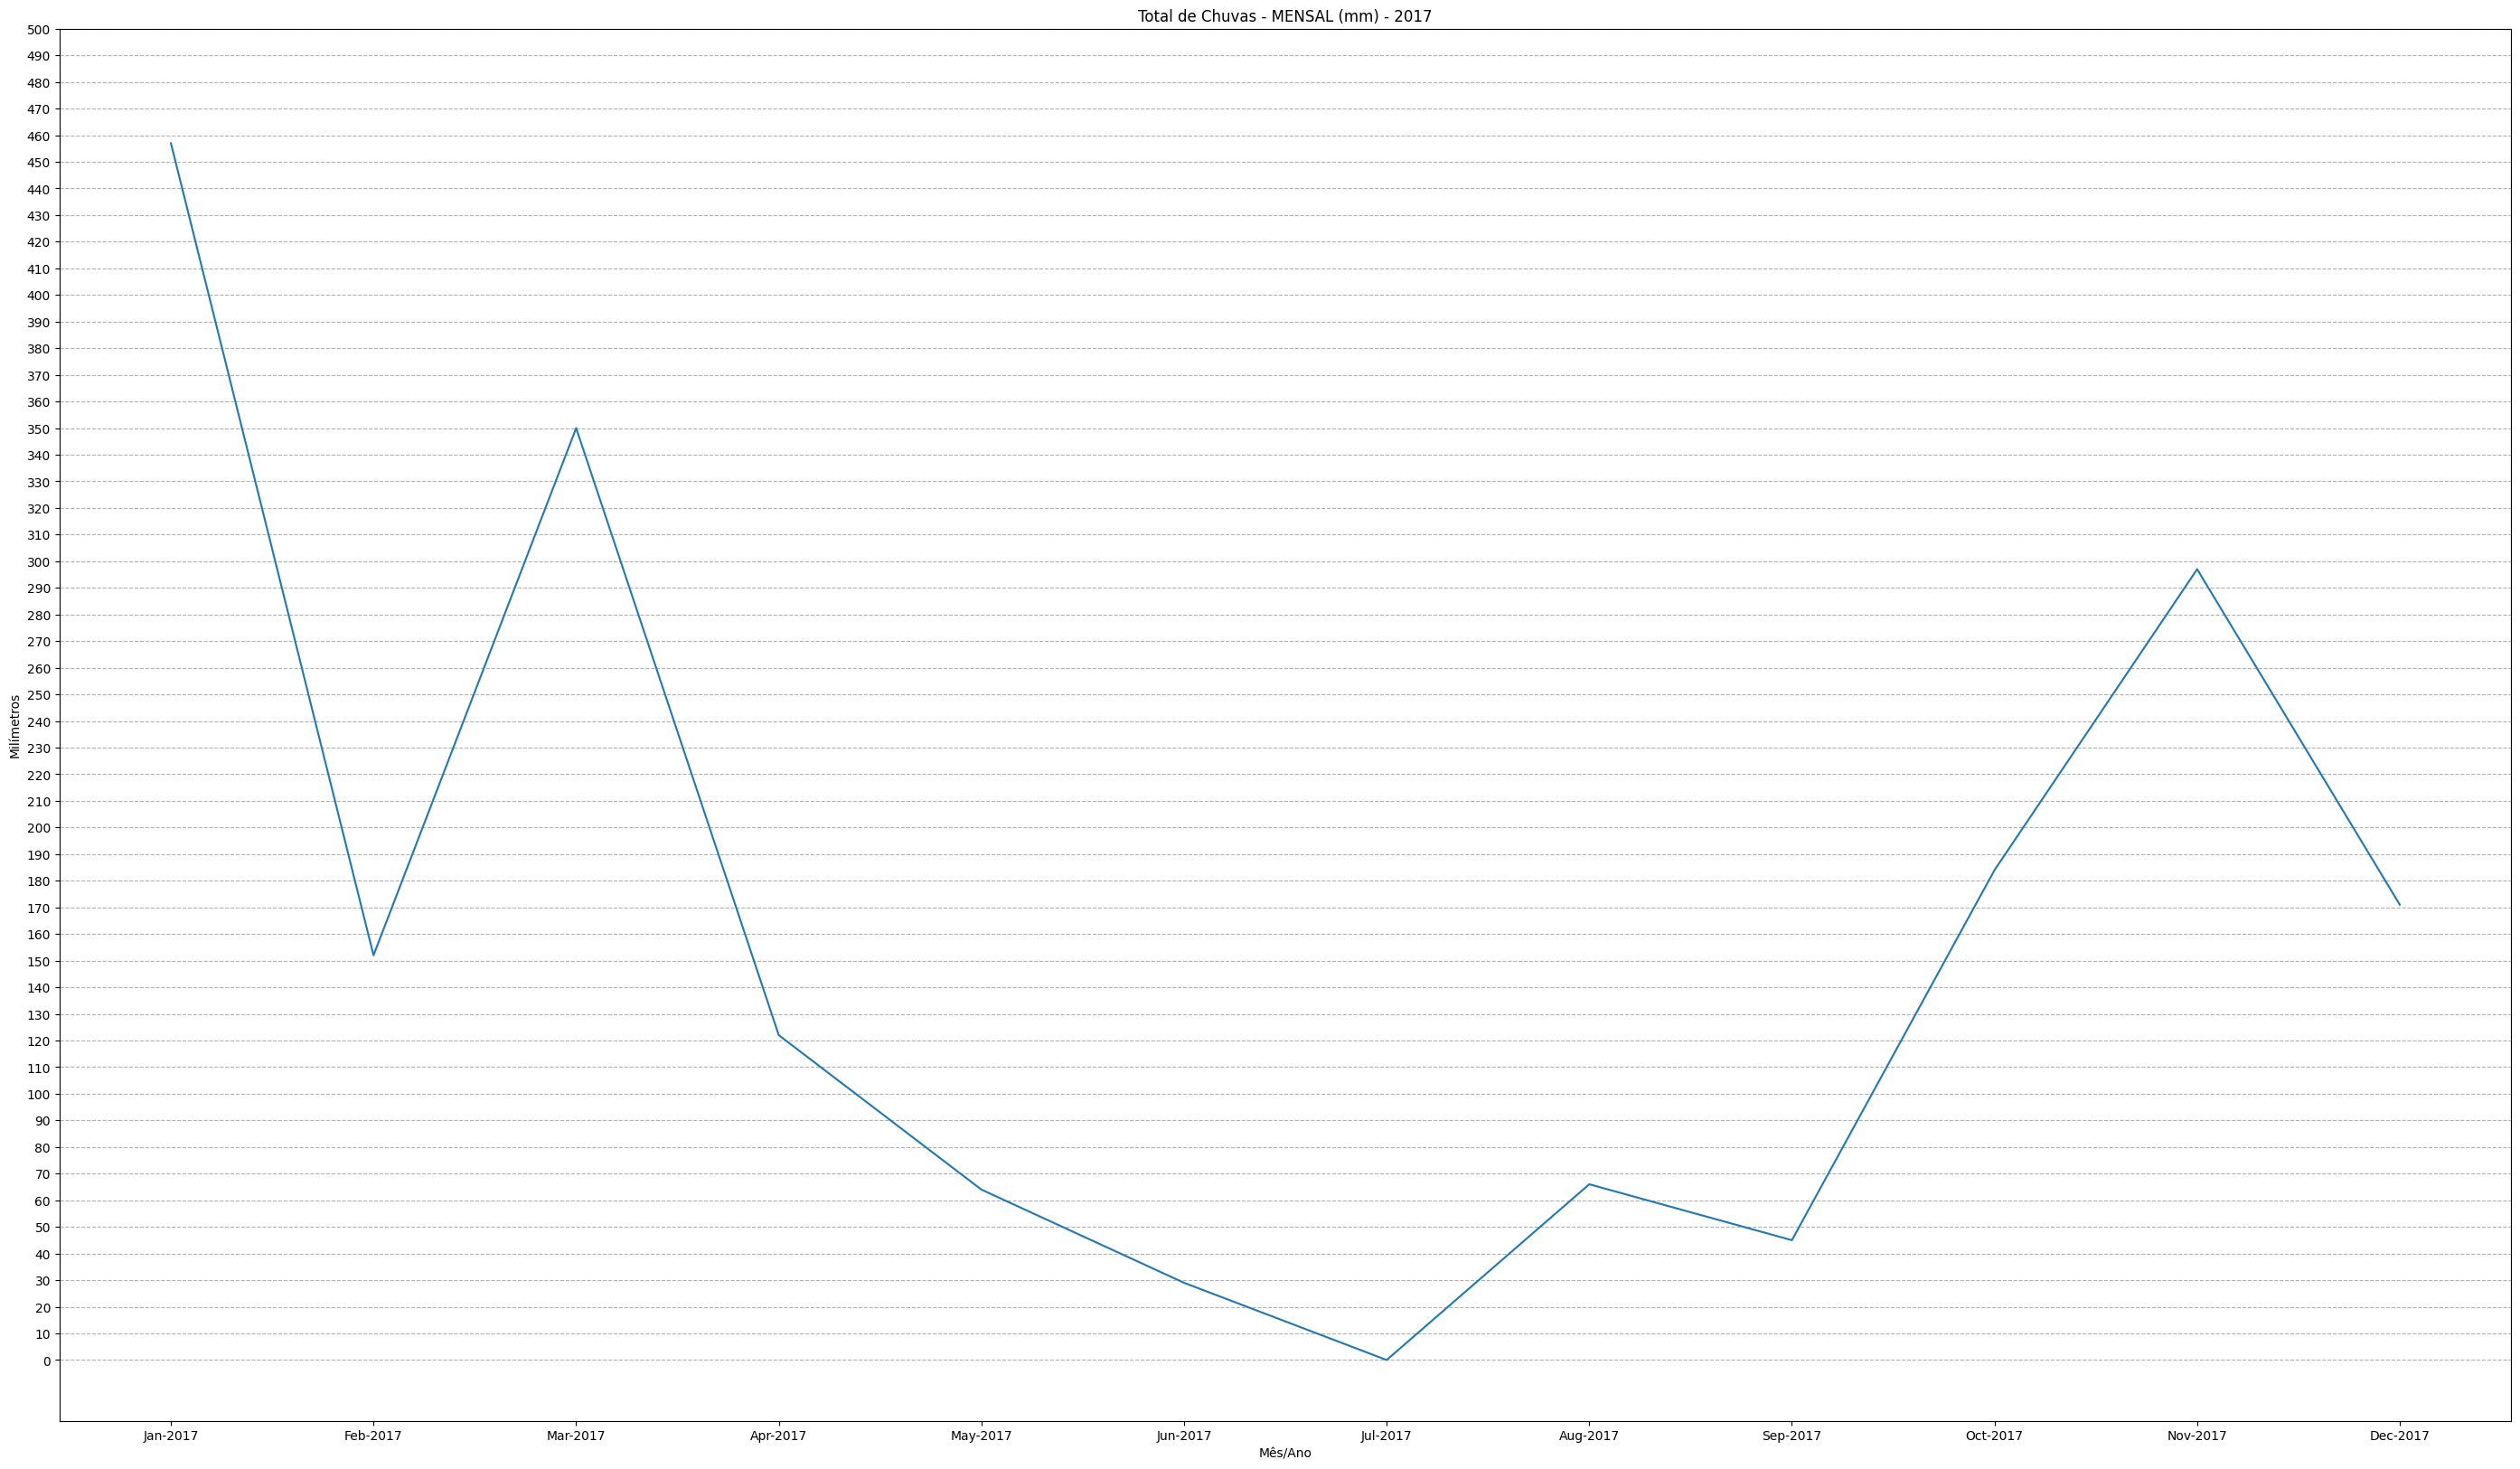

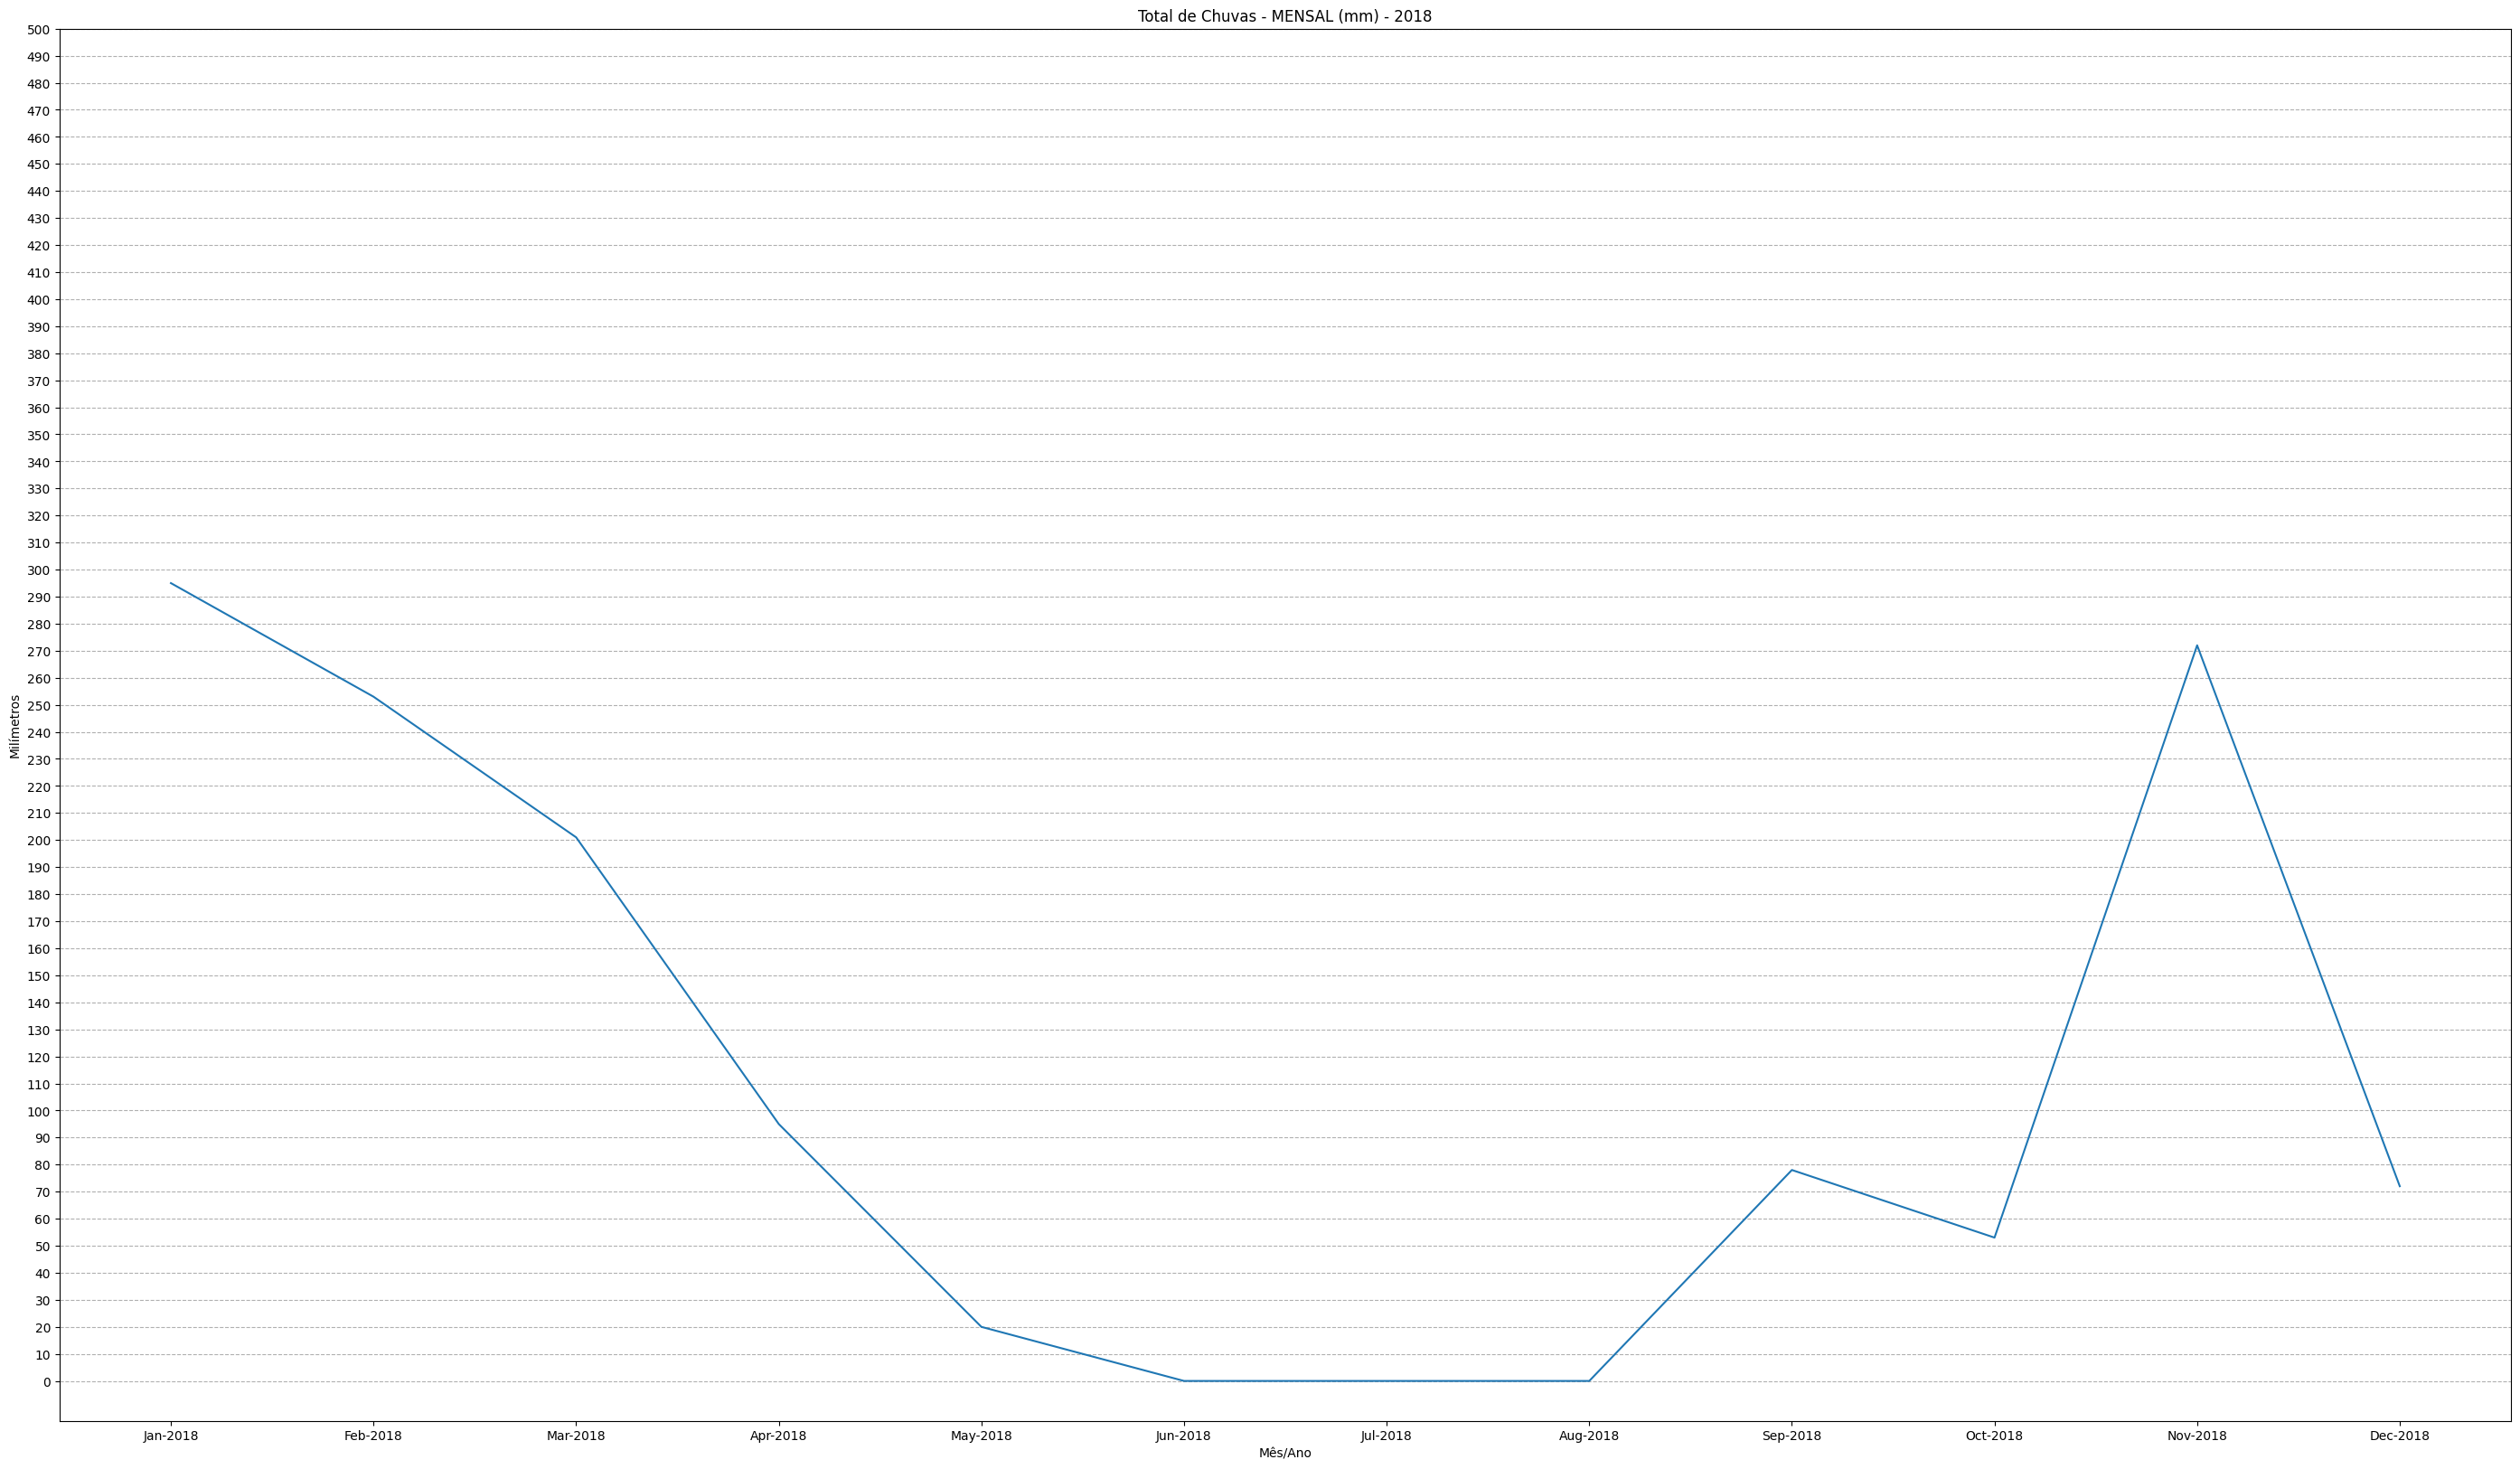

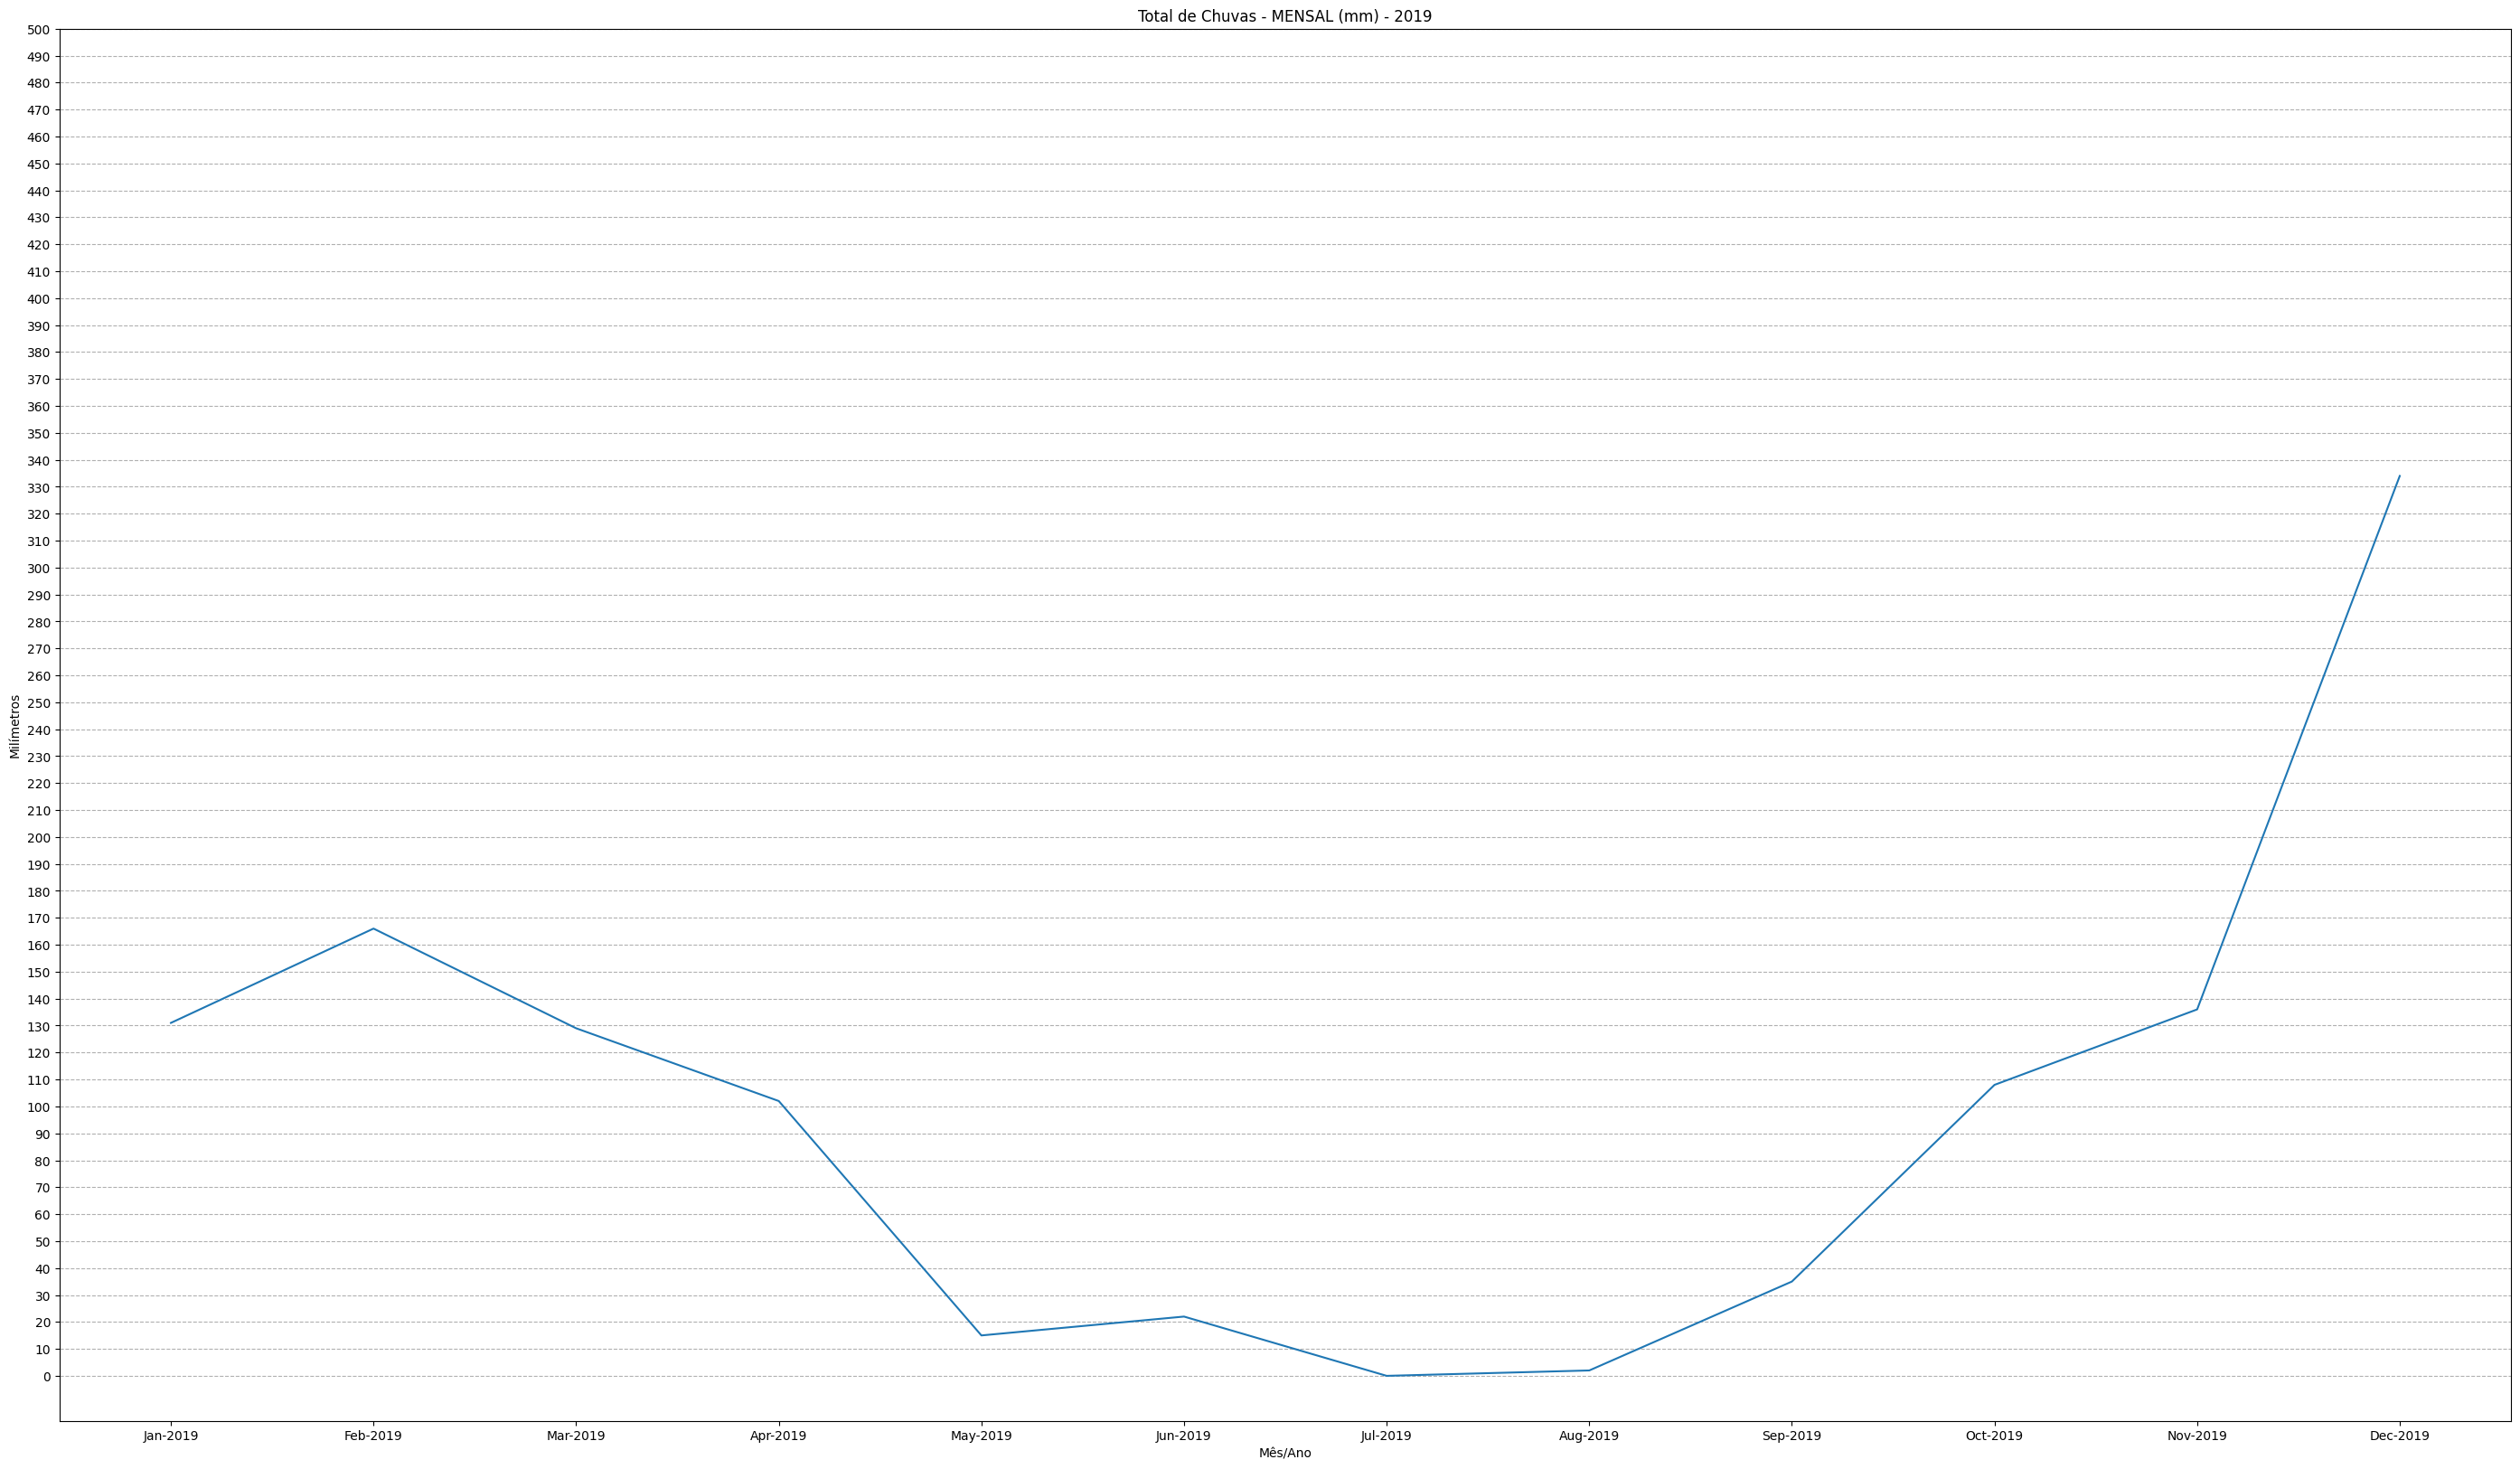

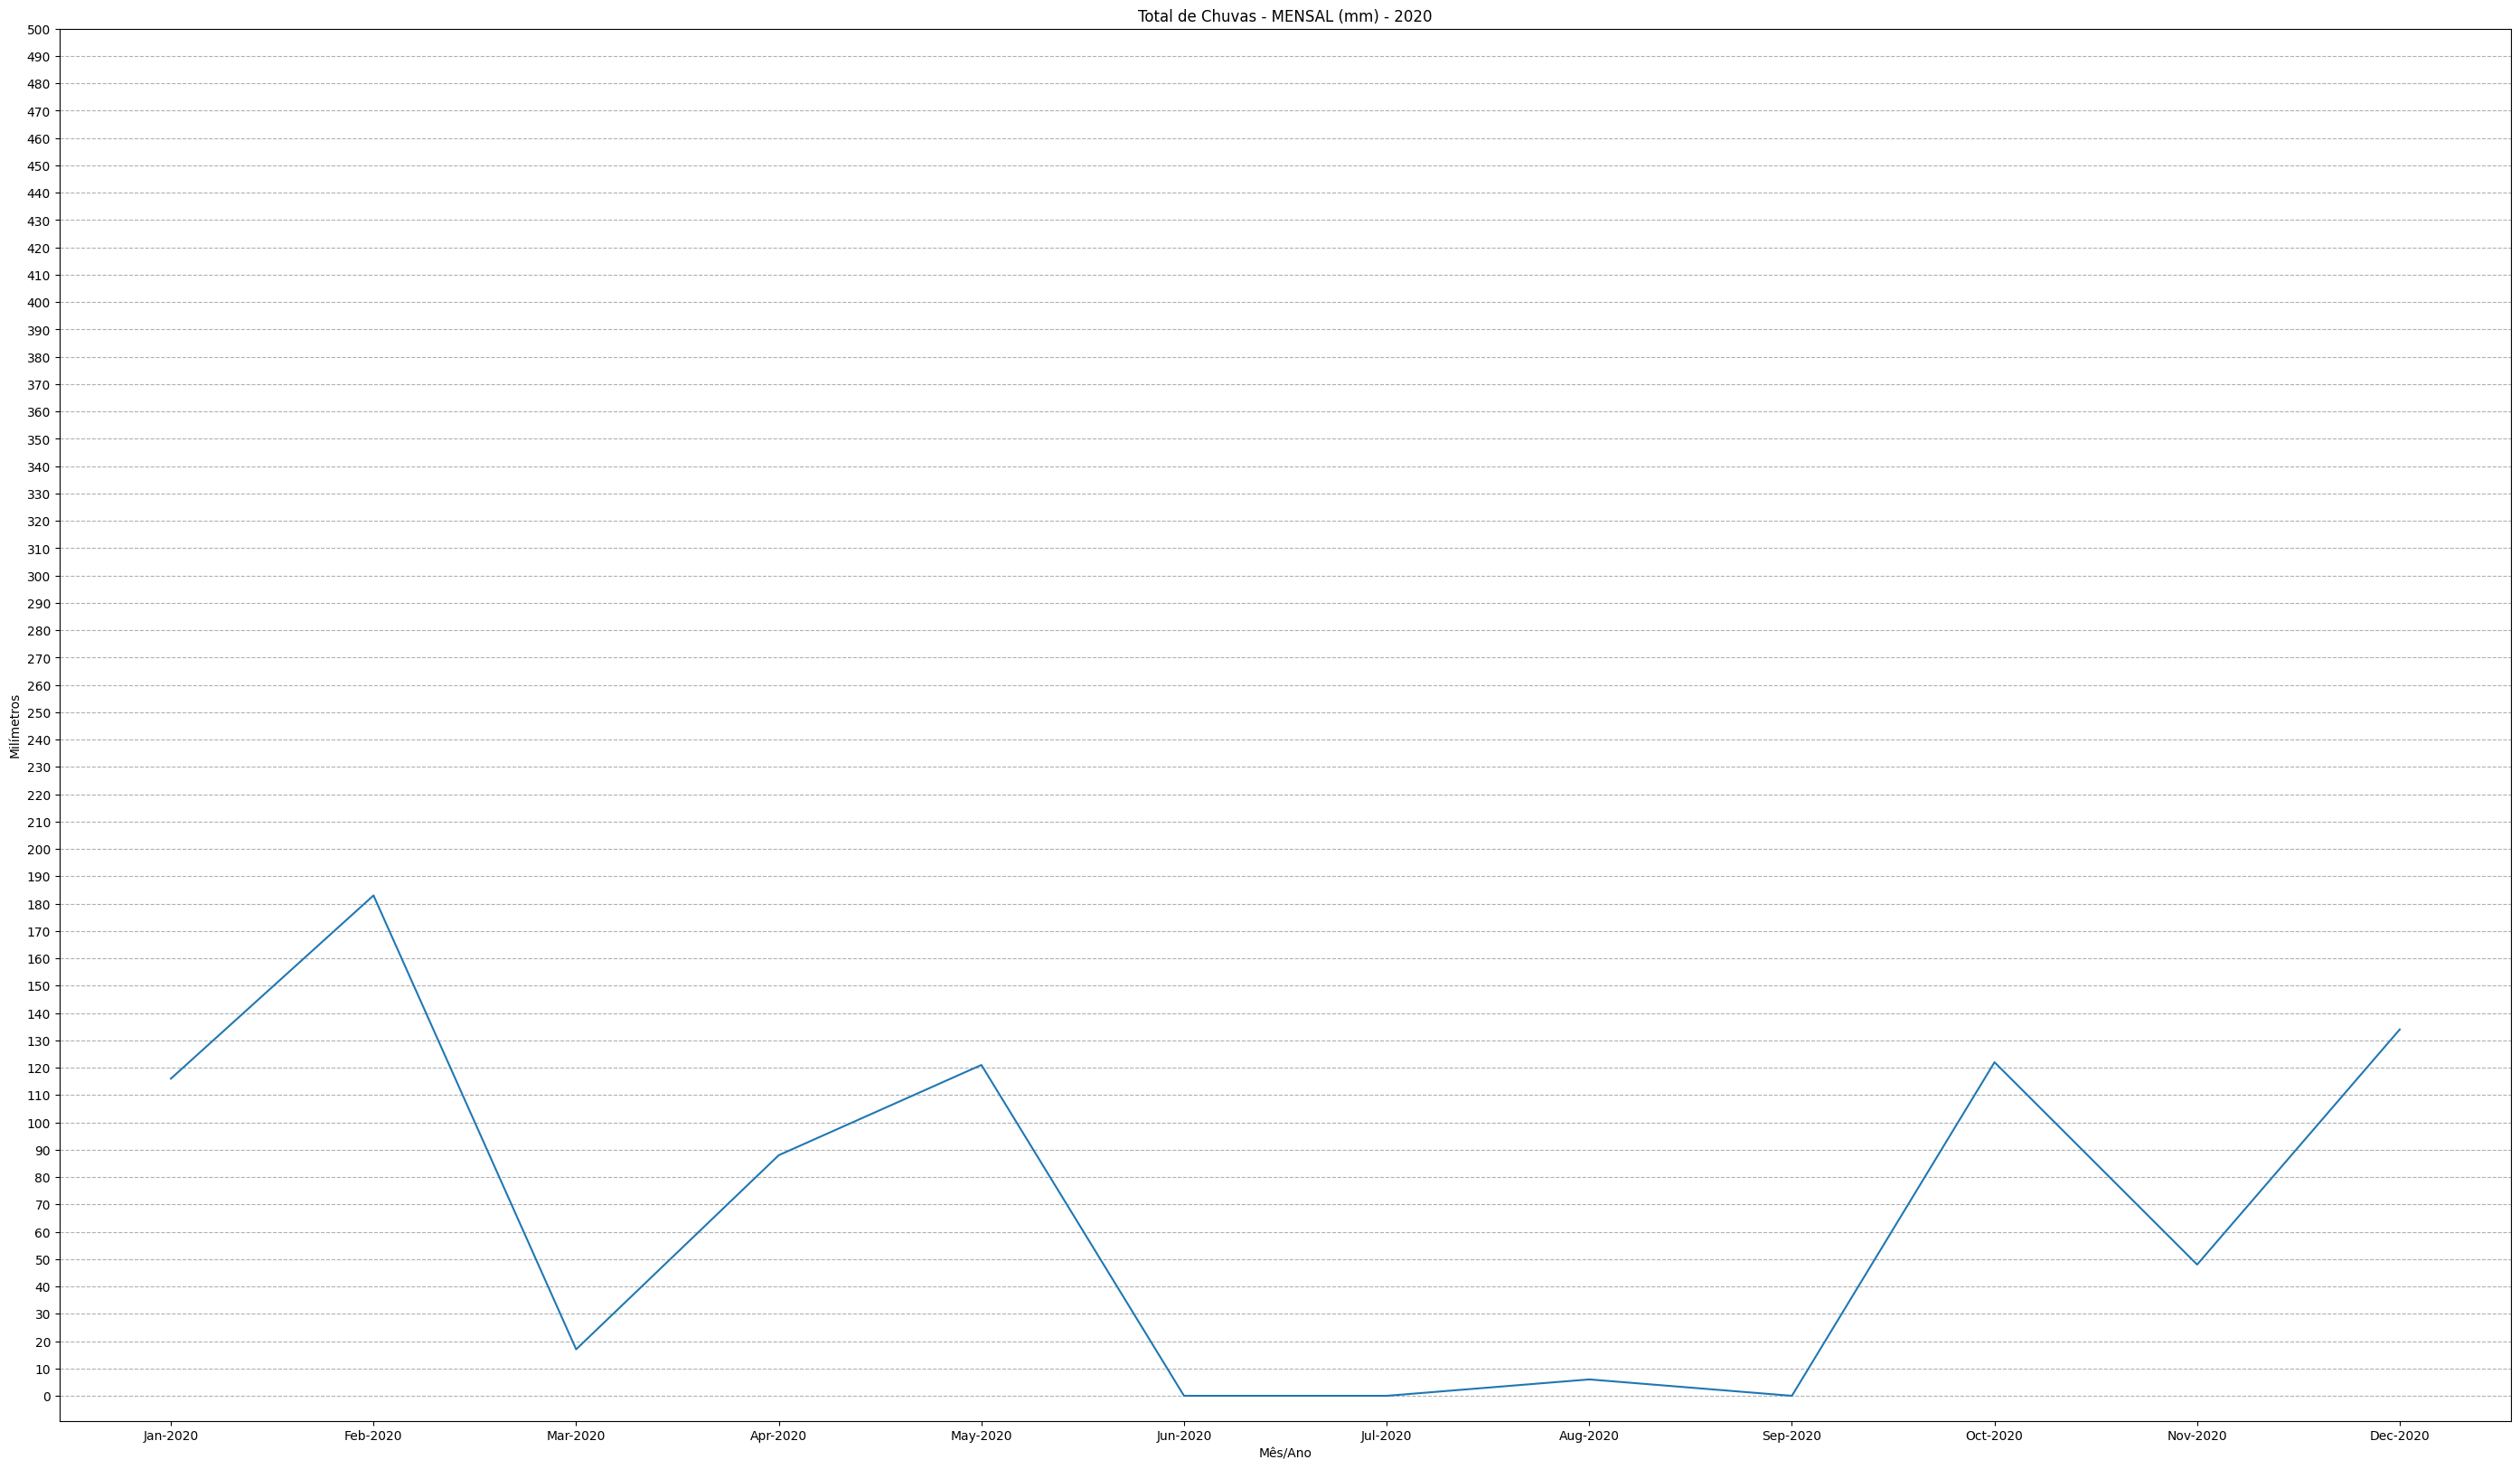

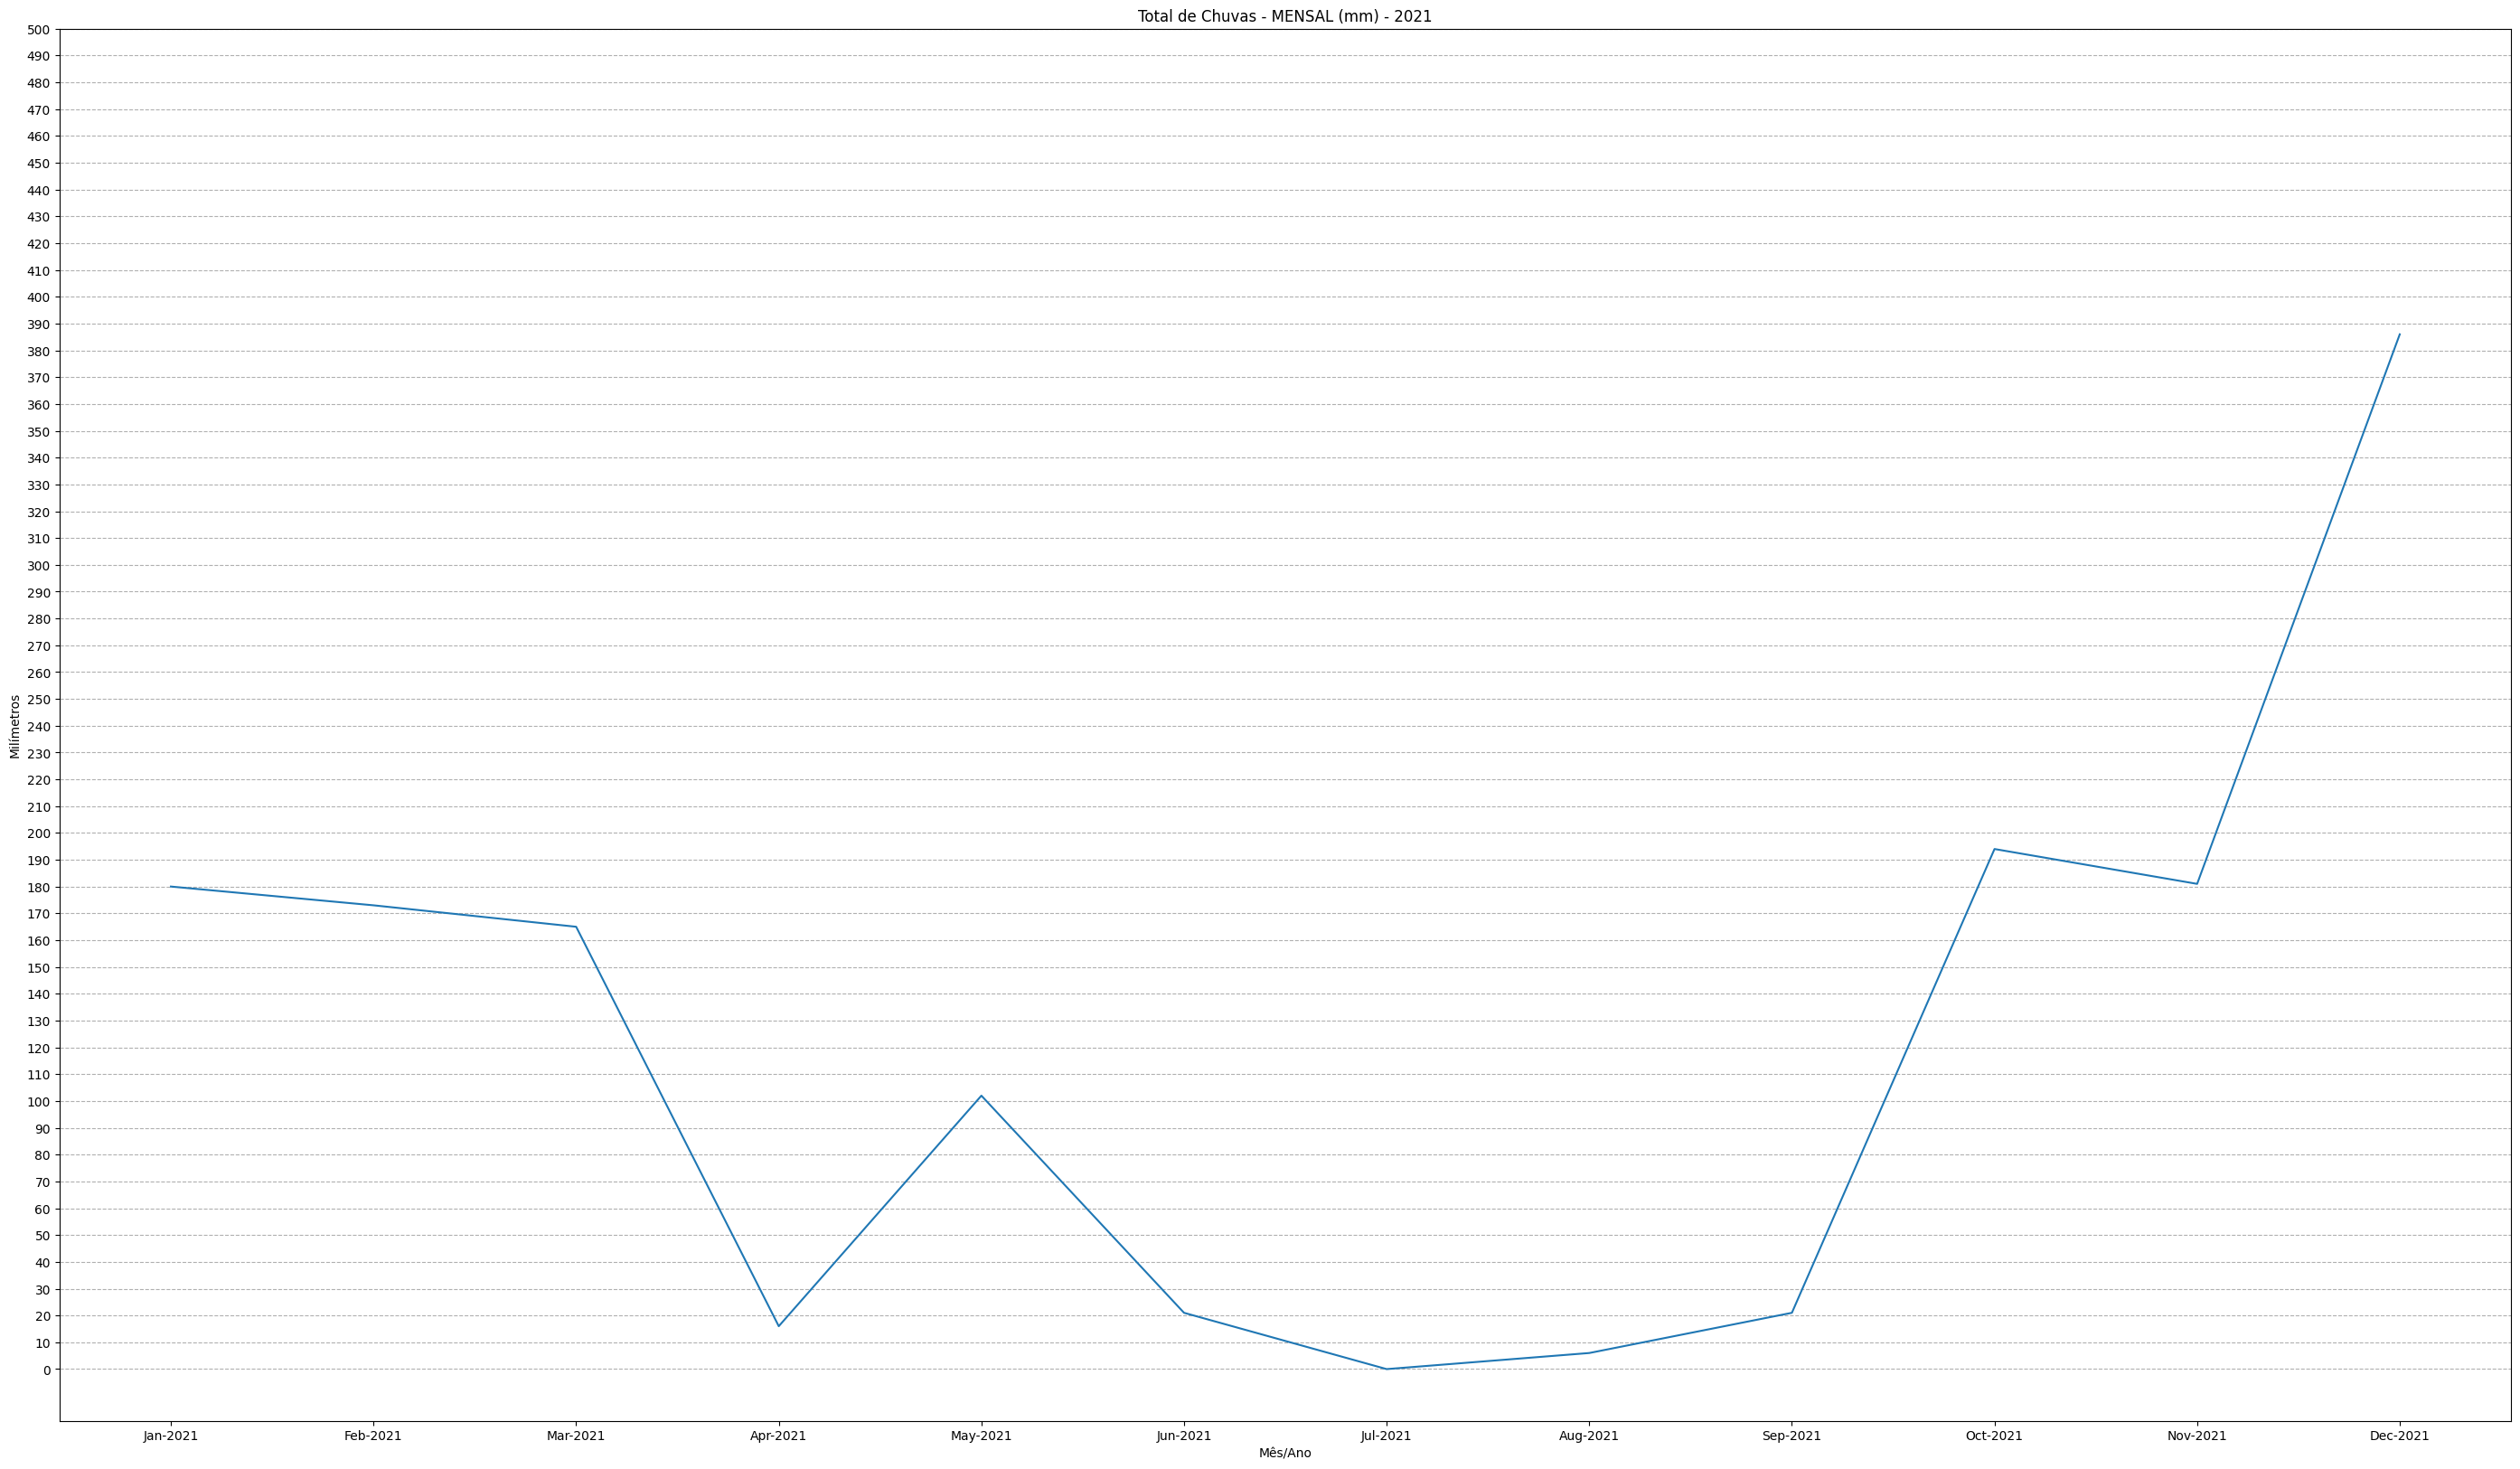

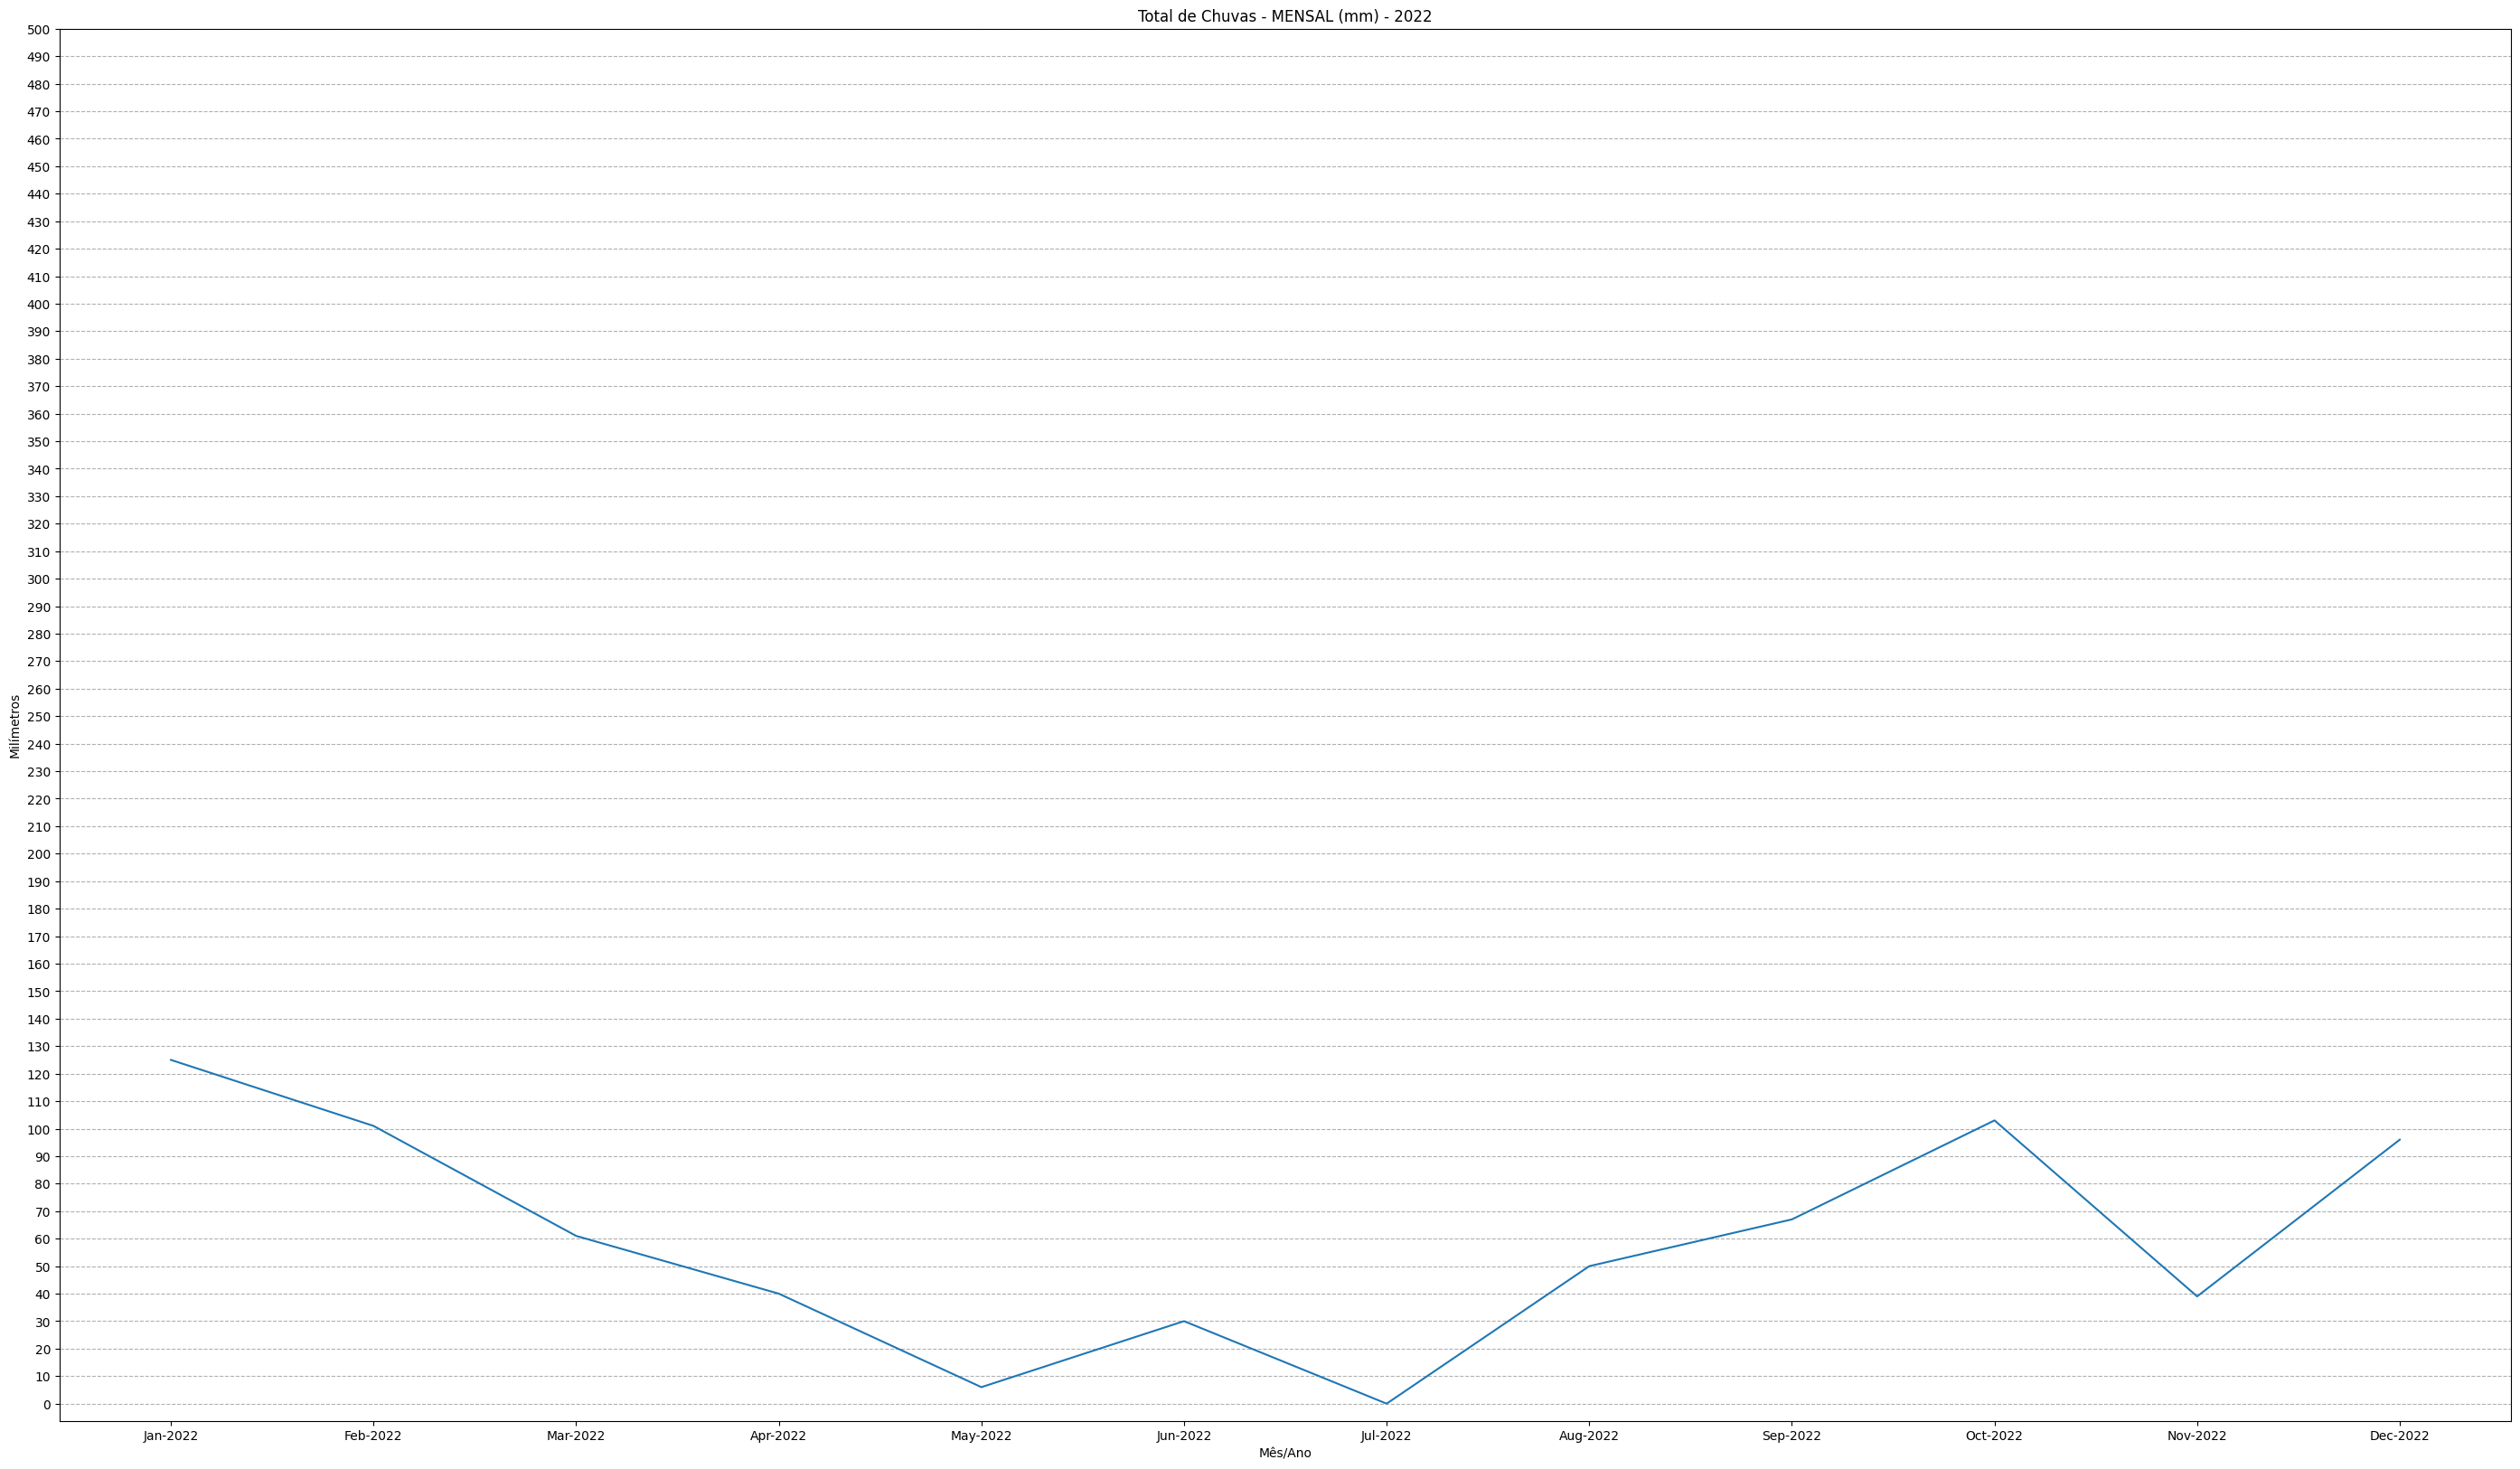

In [63]:
# ---------- VISUALIZAÇÃO TEMPORAL MENSAL SEPARADA POR ANO ---------- #

# Convertendo as colunas de data em um objeto datetime, renomeando para o padrão
df['Data'] = pd.to_datetime(df[['Dia', 'Mes', 'Ano']].rename(columns={'Dia':'Day', 'Mes':'Month', 'Ano':'Year'}))

# Adicionando uma nova coluna com o mês correspondente a cada linha
df['Mes'] = df['Data'].apply(lambda x: x.month)

# Agrupando os dados por mês e calculando a soma da coluna 'Total'
df_mensal = df.groupby(['Ano', 'Mes'])['Total'].sum().reset_index()

# Renomeando as colunas para deixar no formato esperado
df_mensal = df_mensal.rename(columns={'Ano': 'Year', 'Mes': 'Month', 'Total': 'Total_Mensal'})

df_mensal = df.groupby(pd.Grouper(key='Data', freq='M')).sum().reset_index()
df_mensal['Ano'] = df_mensal['Data'].dt.year
df_mensal['Mes_Ano'] = df_mensal['Data'].dt.strftime('%b-%Y')
df_mensal['Total_Mensal'] = df_mensal['Total']

anos = df_mensal['Ano'].unique()

# iterar sobre os anos e gerar um gráfico para cada um
for ano in anos:
    # selecionar somente as linhas correspondentes a um determinado ano
    data_ano = df_mensal.loc[df_mensal['Ano'] == ano]
    
    # gerar o gráfico
    plt.figure(figsize=(35,20))
    ax = sns.lineplot(x='Mes_Ano', y='Total_Mensal', data=data_ano)
    ax.set_yticks(range(0, 501, 10))

    ax.grid(axis='y', linestyle='--')

    ax.set_title(f'Total de Chuvas - MENSAL (mm) - {ano}')
    ax.set_xlabel('Mês/Ano', )
    ax.set_ylabel('Milímetros')
    plt.show()

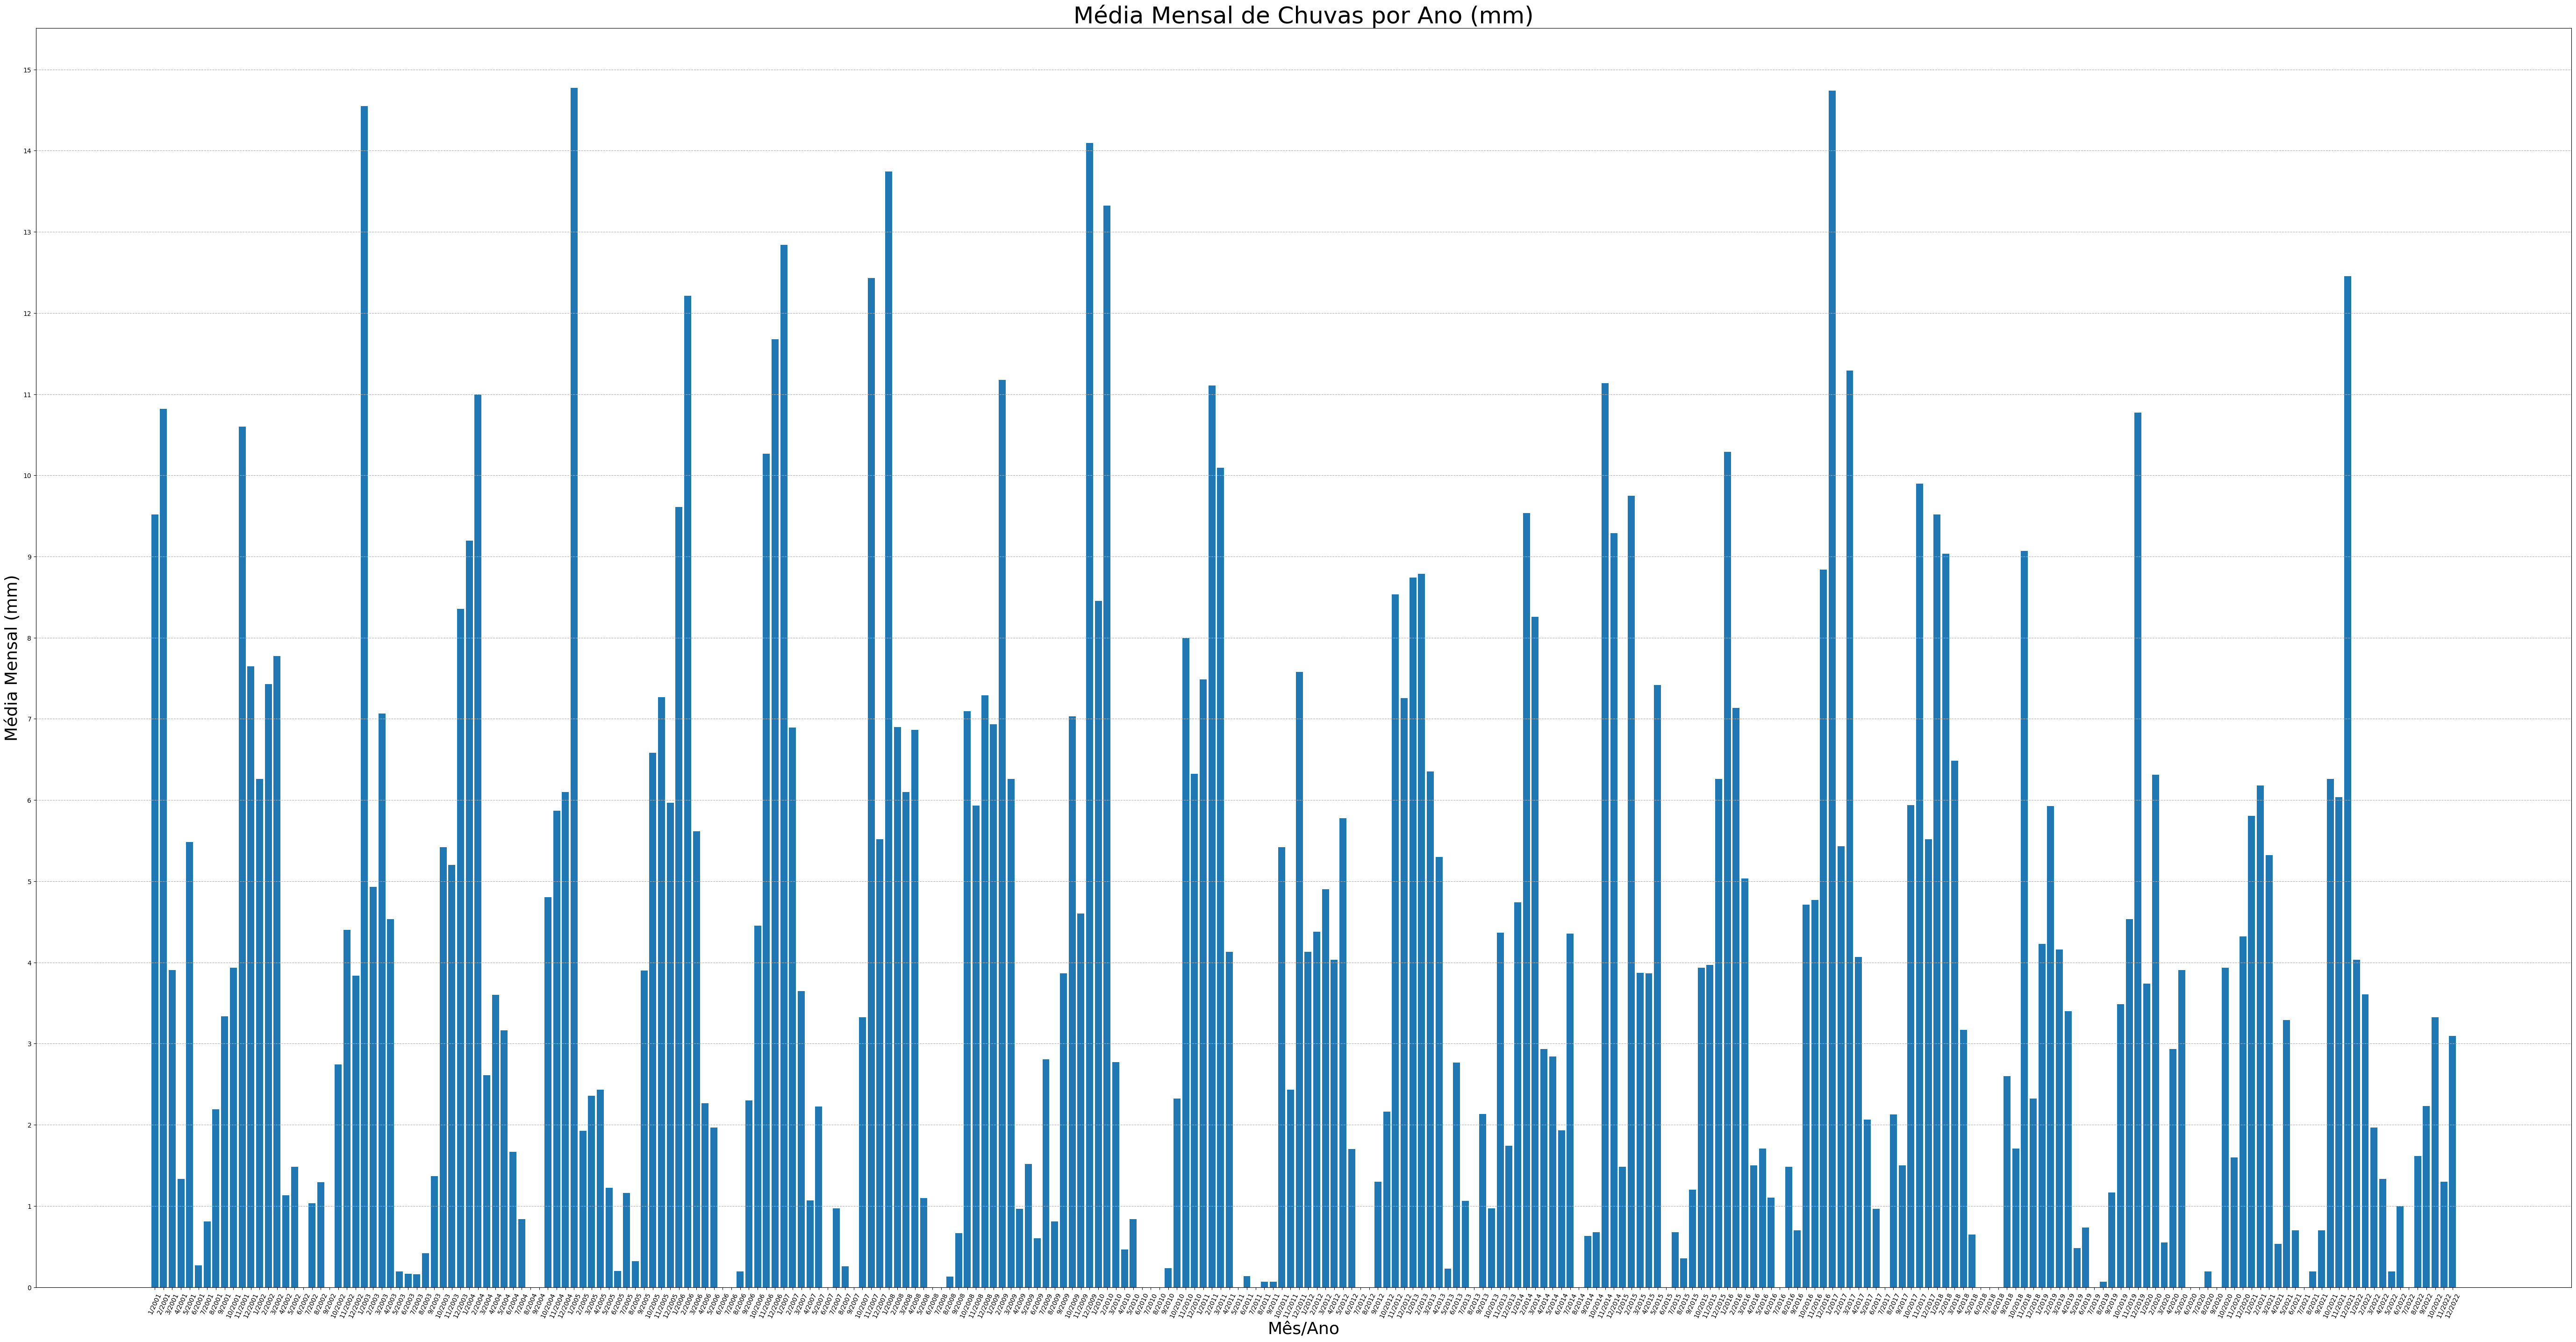

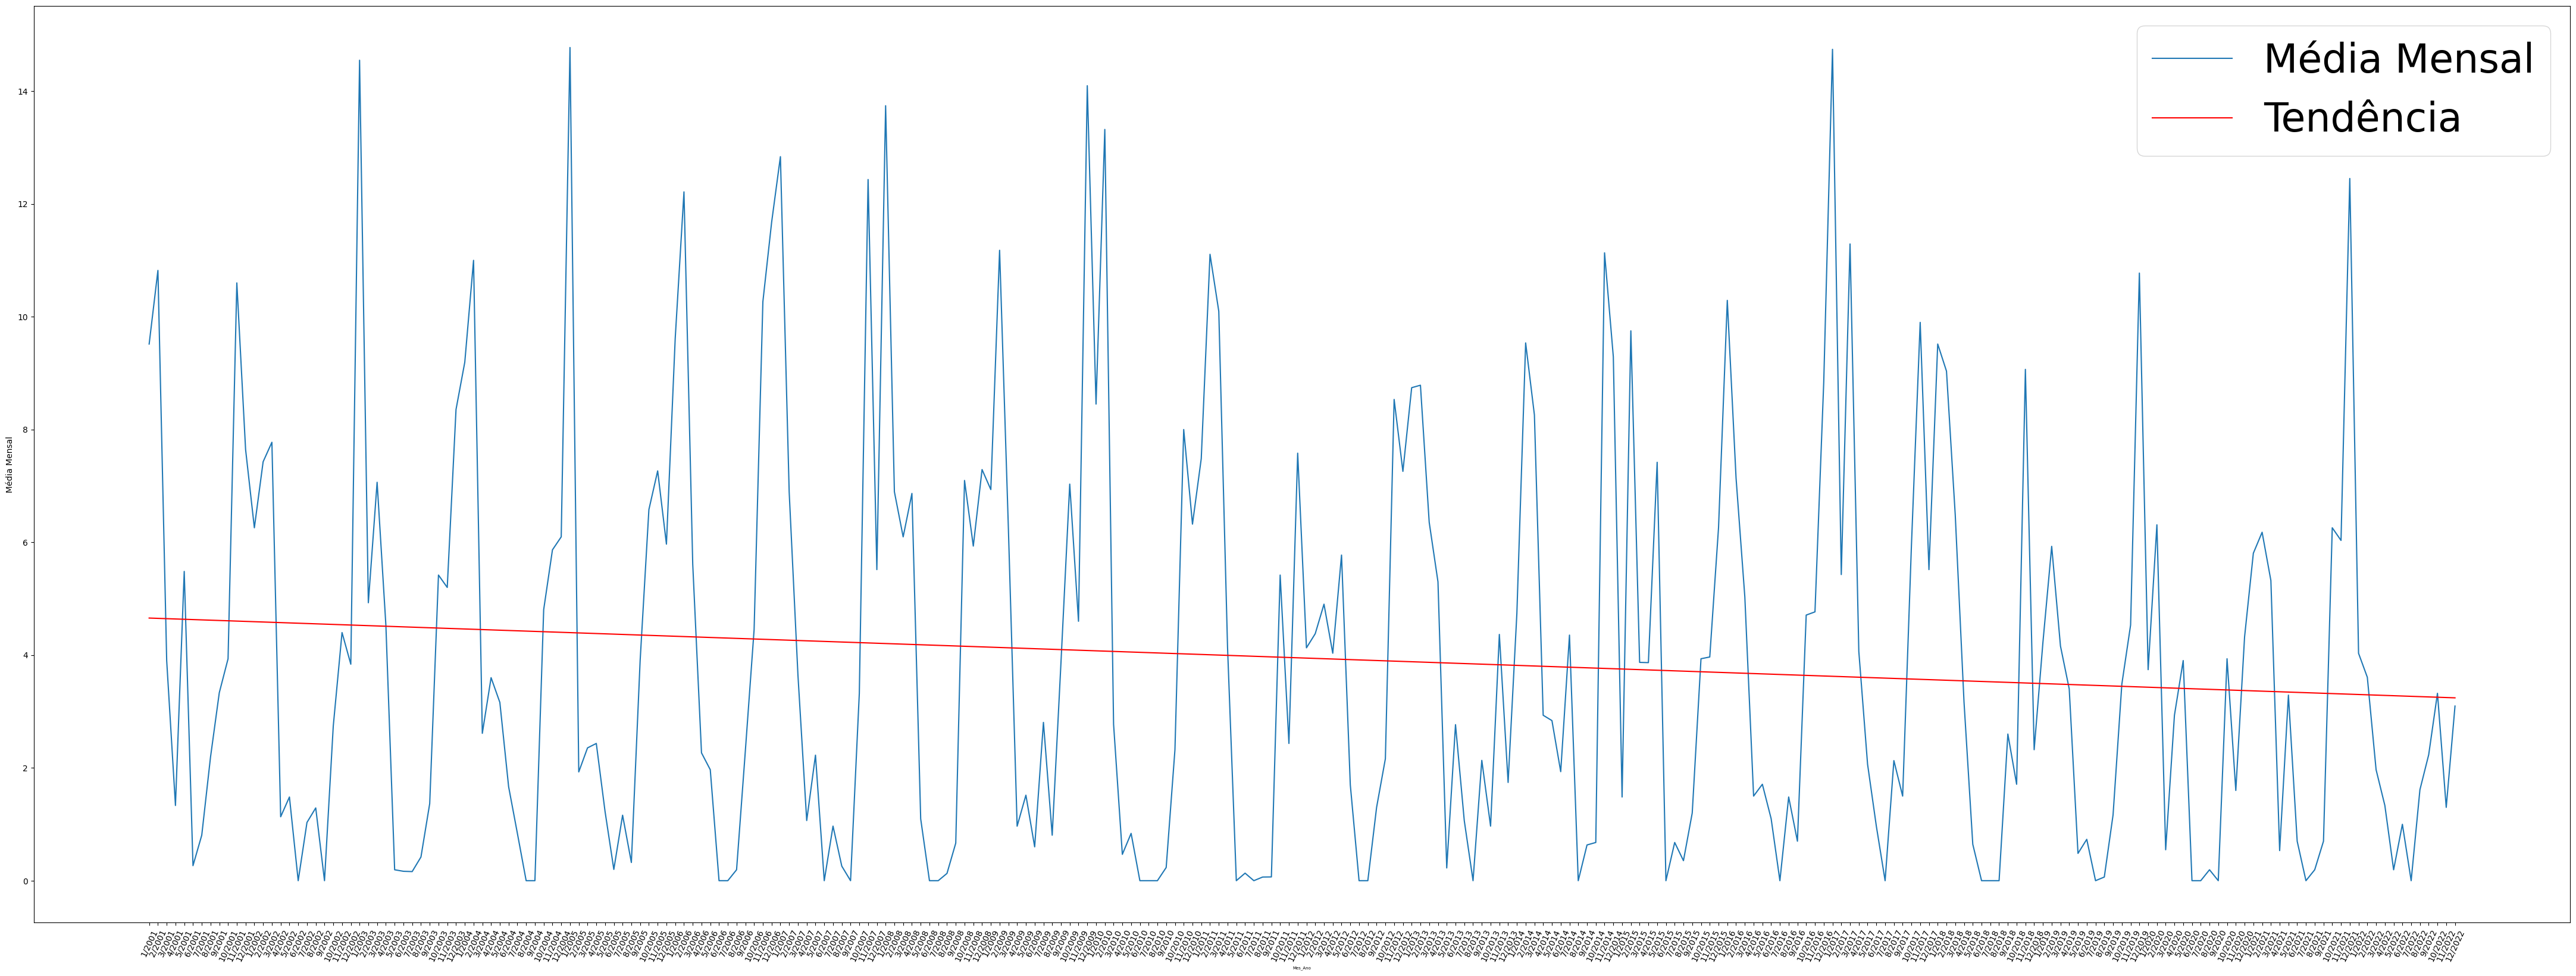

COEFICIENTE DE INCLINAÇÃO: -0.00537912892556888


In [62]:
# ---------- ANÁLISE DE TENDÊNCIAS MENSAL---------- 
# Convertendo as colunas Ano, Mes e Dia em um objeto datetime do pandas
df['Data'] = pd.to_datetime(df[['Dia', 'Mes', 'Ano']].rename(columns={'Dia':'day', 'Mes':'month', 'Ano':'year'}), format='%d-%m-%Y')

# Agrupando os dados por mês e ano
df_mensal = df.groupby(['Ano', 'Mes'])['Total'].agg(['sum', 'mean']).reset_index()

# Renomeando as colunas do novo DataFrame
df_mensal = df_mensal.rename(columns={'year': 'Ano', 'month': 'Mes', 'sum': 'Total_Mensal', 'mean': 'Media_Mensal'})

# Concatenando as Colunas Ano e Mes
df_mensal['Mes_Ano'] = df_mensal['Mes'].astype(str) + '/' + df_mensal['Ano'].astype(str)

# Removendo as colunas Ano e Mes
df_mensal = df_mensal.drop(['Ano', 'Mes'], axis=1)

#Reordenando as colunas
df_mensal = df_mensal[['Mes_Ano', 'Total_Mensal', 'Media_Mensal']]

# Gerando o Grafico de Barras
fig, ax = plt.subplots(figsize=(70,35))
ax.bar(df_mensal['Mes_Ano'], df_mensal['Media_Mensal'], width=0.8)
ax.set_yticks(range(0, 16, 1))
ax.grid(axis='y', linestyle='--')

ax.set_title('Média Mensal de Chuvas por Ano (mm)', fontsize=36)
ax.set_xlabel('Mês/Ano', fontsize=26)
ax.set_ylabel('Média Mensal (mm)', fontsize=26)

plt.xticks(rotation=65)

plt.show()

# Criando um novo DataFrame com a coluna "Ano-Mes" como índice e a coluna "Media_Mensal" como valor
df_tendencia = df_mensal.set_index('Mes_Ano')['Media_Mensal']

# Ajustando um modelo de regressão linear
X = range(len(df_tendencia.index))
X = sm.add_constant(X)
modelo = sm.OLS(df_tendencia.values, X)
resultado = modelo.fit()

# Plotando os dados e a linha de tendência
fig, ax = plt.subplots(figsize=(55, 20))
ax.plot(df_tendencia.index, df_tendencia.values, label='Média Mensal')
ax.plot(df_tendencia.index, resultado.fittedvalues, color='r', label='Tendência')
ax.legend(fontsize=48)

ax.set_xlabel('Mes_Ano', fontsize=5)
ax.set_ylabel('Média Mensal')
plt.xticks(rotation=65)
plt.show()

print('COEFICIENTE DE INCLINAÇÃO:', resultado.params[1])



COEFICIENTE DE INCLINAÇÃO: -0.06032452041395695
A PRECIPITAÇÃO ESTÁ DIMINUINDO AO LONGO DOS ANOS! 



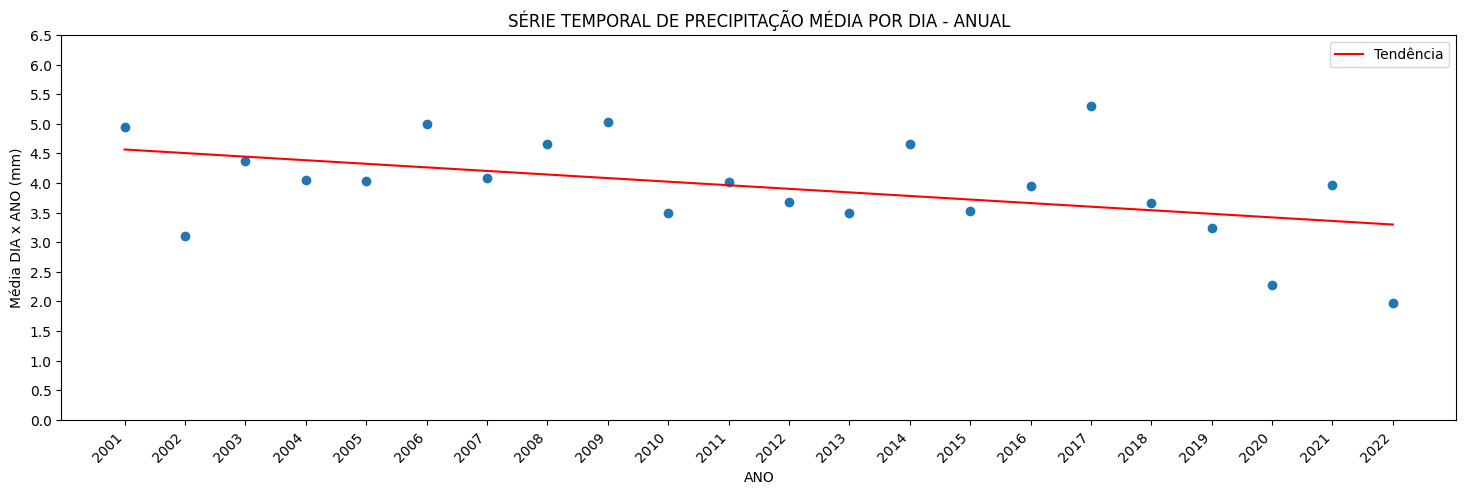

In [61]:
# ---------- ANÁLISE DE TENDÊNCIAS ANUAL ---------- 
# Cálculo do coeficiente de inclinação da reta e representação gráfica

from scipy.stats import linregress

# Agrupando os dados por ano e calculando a média da coluna 'Total'
df_anual = df.groupby(['Ano'])['Total'].mean().reset_index()


# Ajustando um modelo de regressão linear aos dados
slope, intercept, r_value, p_value, std_err = linregress(df_anual['Ano'], df_anual['Total'])

# Imprimindo o valor do coeficiente de inclinação (slope)
print(f"COEFICIENTE DE INCLINAÇÃO: {slope}")

#Verifica se o coeficiente é negativo ou positivo e apresenta a conclusão
if slope > 0:
  print("A PRECIPITAÇÃO ESTÁ AUMENTANDO AO LONGO DOS ANOS! \n")
elif slope < 0:
    print("A PRECIPITAÇÃO ESTÁ DIMINUINDO AO LONGO DOS ANOS! \n")

# Criando a tabela de estatísticas resumidas por ano
df_annual_stats = df.groupby(df['Data'].dt.year).describe()['Total'].reset_index()
df_annual_stats.columns = ['Ano', 'Dias', 'Média', 'Desvio_Padrão', 'Mínimo', '25%', 'Mediana', '75%', 'Máximo']

# Formatando e estilizando a tabela
tabela_formatada = df_annual_stats.style.set_caption('ESTATÍSTICAS RESUMIDAS ANUAIS - (mm X Dia)') \
    .format({'Ano': '{:.0f}', 'Dias': '{:.0f}', 'Média': '{:.2f}', 'Desvio_Padrão': '{:.2f}',
             'Mínimo': '{:.2f}', '25%': '{:.2f}', 'Mediana': '{:.2f}', '75%': '{:.2f}', 'Máximo': '{:.2f}'}) \
    .set_properties(subset=['Ano'], **{'width': '50px'}) \
    .set_properties(subset=['Dias'], **{'width': '70px'}) \
    .set_properties(subset=['Média', 'Desvio_Padrão', 'Mínimo', '25%', 'Mediana', '75%', 'Máximo'], **{'width': '90px'}) \

# Exibindo a tabela
display(tabela_formatada)

# Plotando o gráfico da série temporal com a linha de tendência ANUAL
plt.figure(figsize=(18, 5))
plt.plot(df_anual['Ano'], df_anual['Total'], 'o')
plt.plot(df_anual['Ano'], intercept + slope*df_anual['Ano'], 'r', label='Tendência')

plt.title('SÉRIE TEMPORAL DE PRECIPITAÇÃO MÉDIA POR DIA - ANUAL')
plt.xlabel('ANO')
plt.xticks(df_anual['Ano'], rotation=45, ha='right')
plt.ylabel('Média DIA x ANO (mm)')
plt.yticks(np.arange(0, 7, 0.5))
plt.legend()
plt.show()

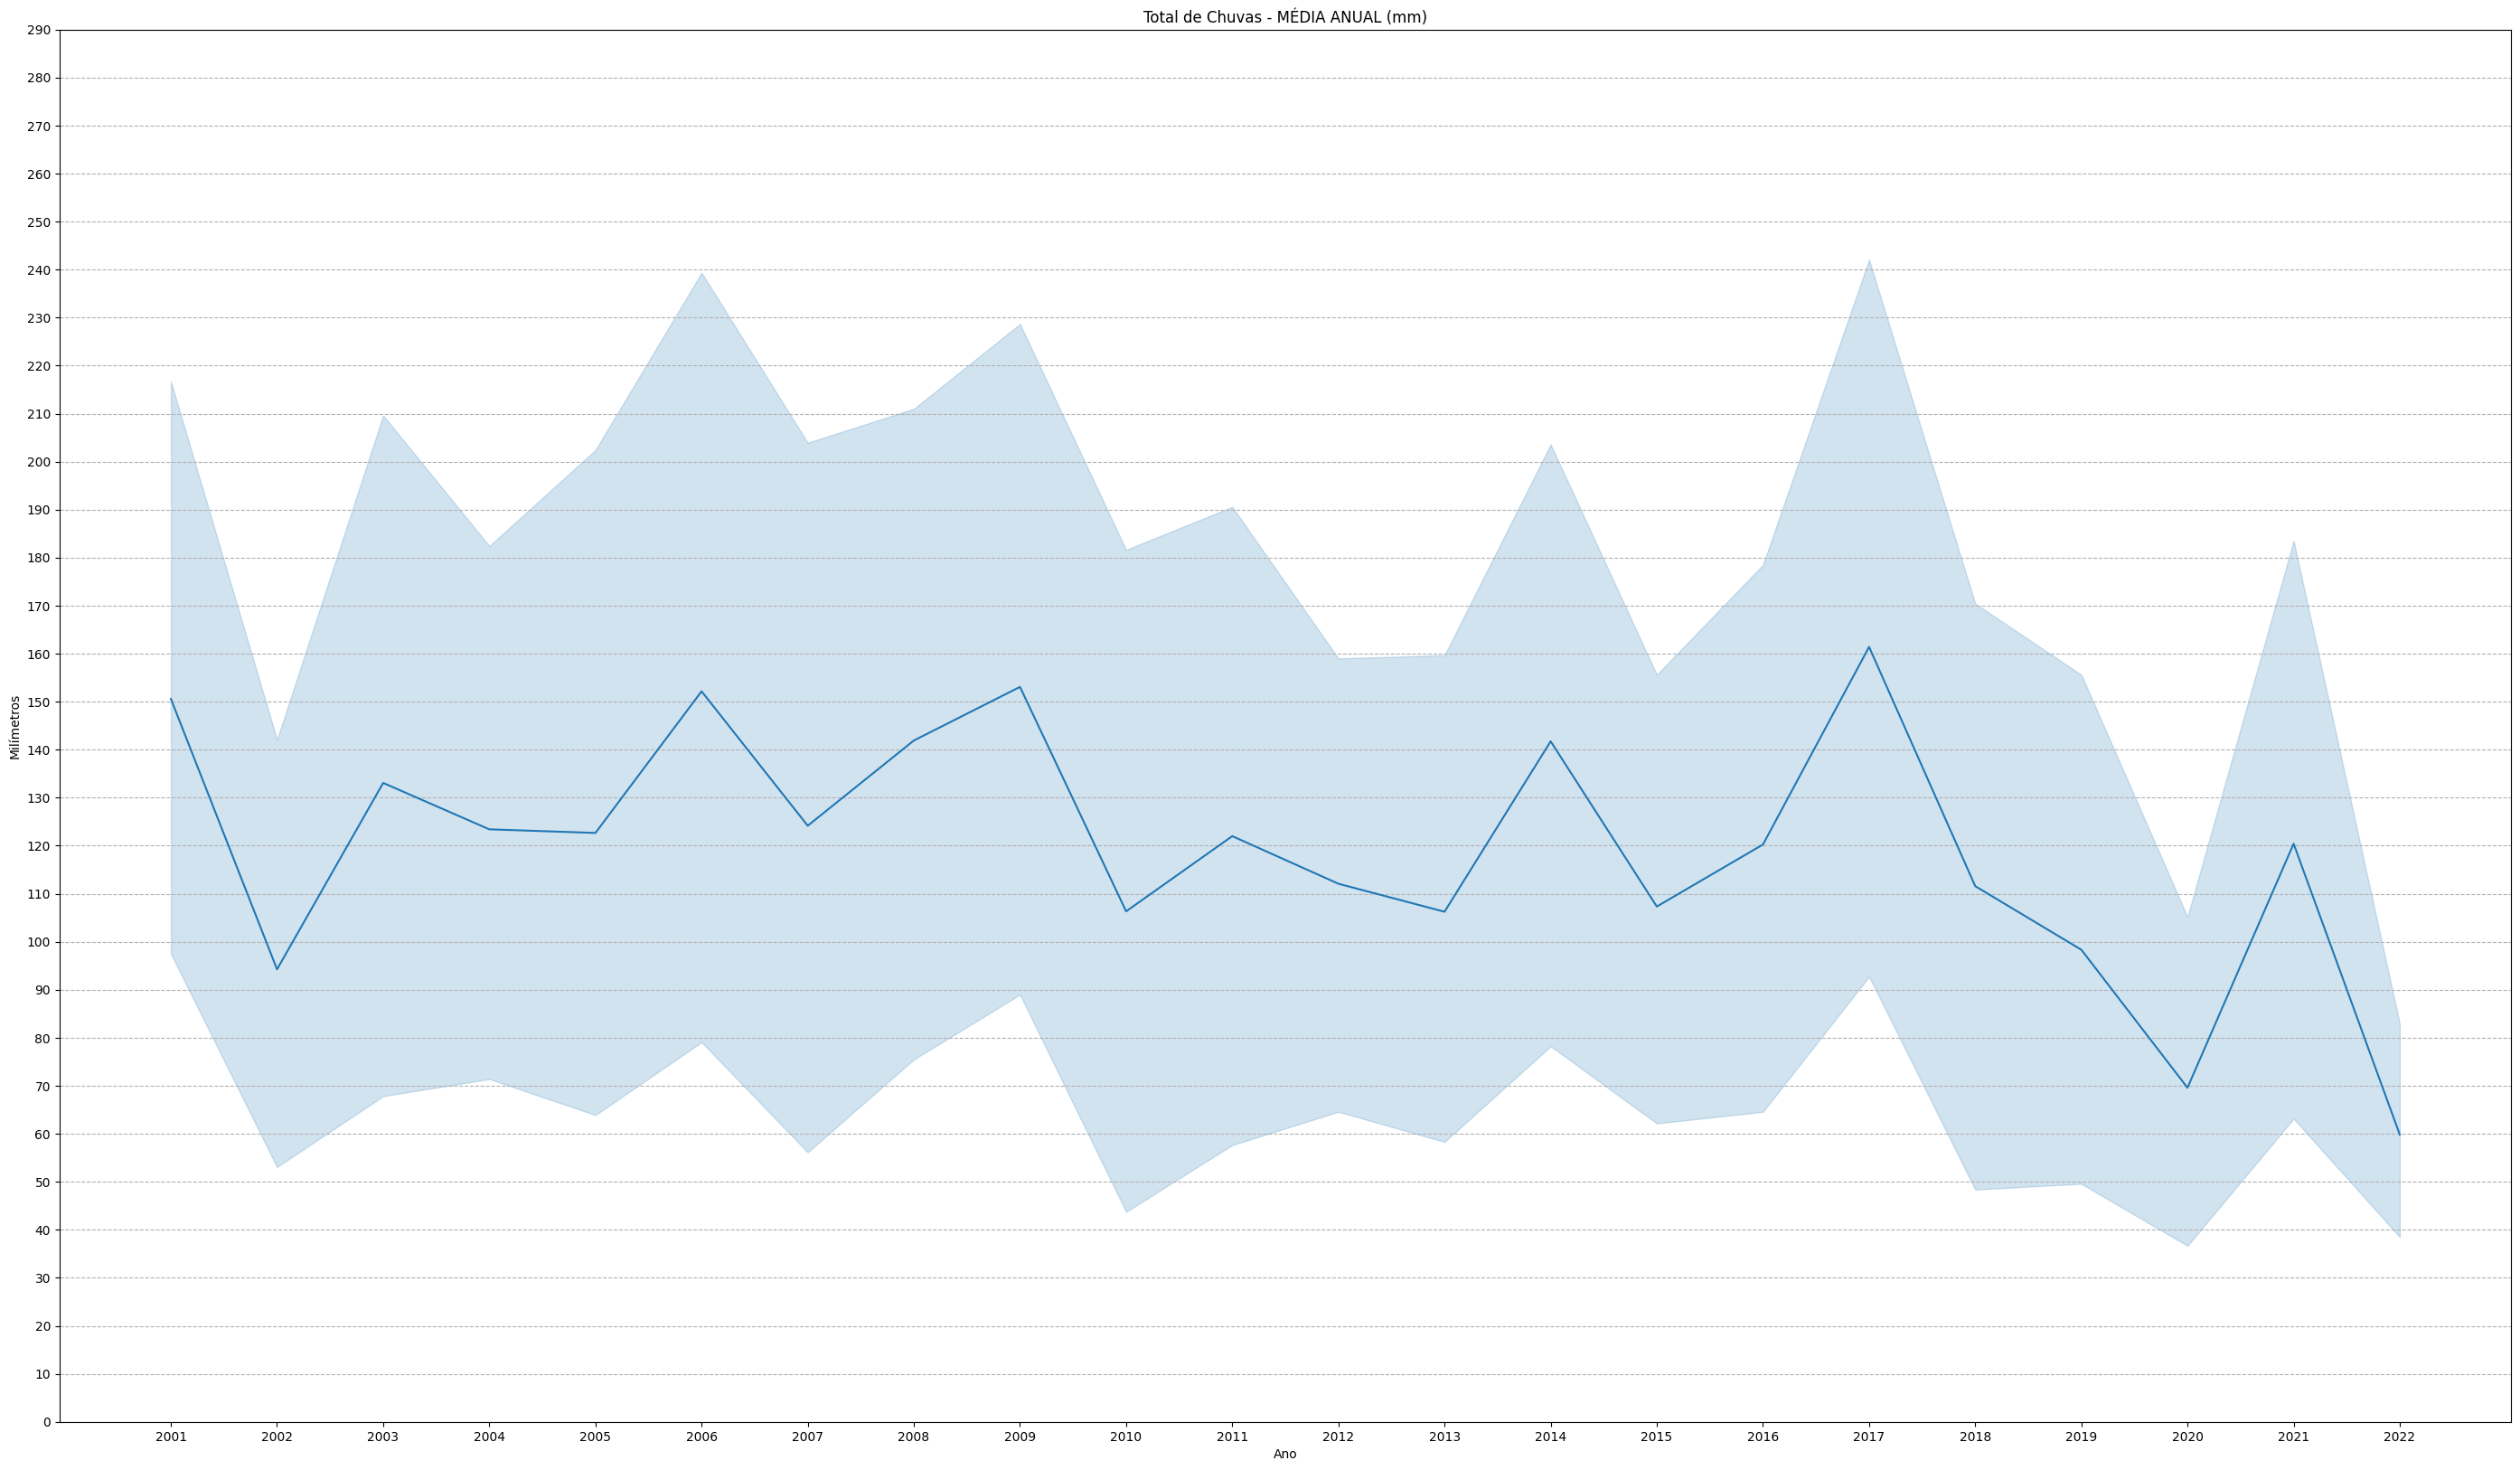

In [60]:
# ---------- VISUALIZAÇÃO TEMPORAL MÉDIA POR ANO ---------- #

# Convertendo as colunas de data em um objeto datetime, renomeando para o padrão
df['Data'] = pd.to_datetime(df[['Dia', 'Mes', 'Ano']].rename(columns={'Dia':'Day', 'Mes':'Month', 'Ano':'Year'}))

# Adicionando uma nova coluna com o mês correspondente a cada linha
df['Mes'] = df['Data'].apply(lambda x: x.month)

# Agrupando os dados por mês e calculando a soma da coluna 'Total'
df_mensal = df.groupby(['Ano', 'Mes'])['Total'].sum().reset_index()

# Renomeando as colunas para deixar no formato esperado
#df_mensal = df_mensal.rename(columns={'Ano': 'Year', 'Mes': 'Month', 'Total': 'Total_Mensal'})

df_mensal = df.groupby(pd.Grouper(key='Data', freq='M')).sum().reset_index()
df_mensal['Ano'] = df_mensal['Data'].dt.year
df_mensal['Mes_Ano'] = df_mensal['Data'].dt.strftime('%b-%Y')
#df_mensal['Total_Mensal'] = df_mensal['Total']
    
# Imprimindo a Tabela de Média Anual
df_mensal

# Gerando o Gráfico por Média Anual
plt.figure(figsize=(35,20))
ax = sns.lineplot(x='Ano', y='Total', data=df_mensal)
ax.set_xticks(range(2001, 2023, 1))
ax.set_yticks(range(0, 300, 10))

ax.grid(axis='y', linestyle='--')

ax.set_title(f'Total de Chuvas - MÉDIA ANUAL (mm)')
ax.set_xlabel('Ano')
ax.set_ylabel('Milímetros')
plt.show()

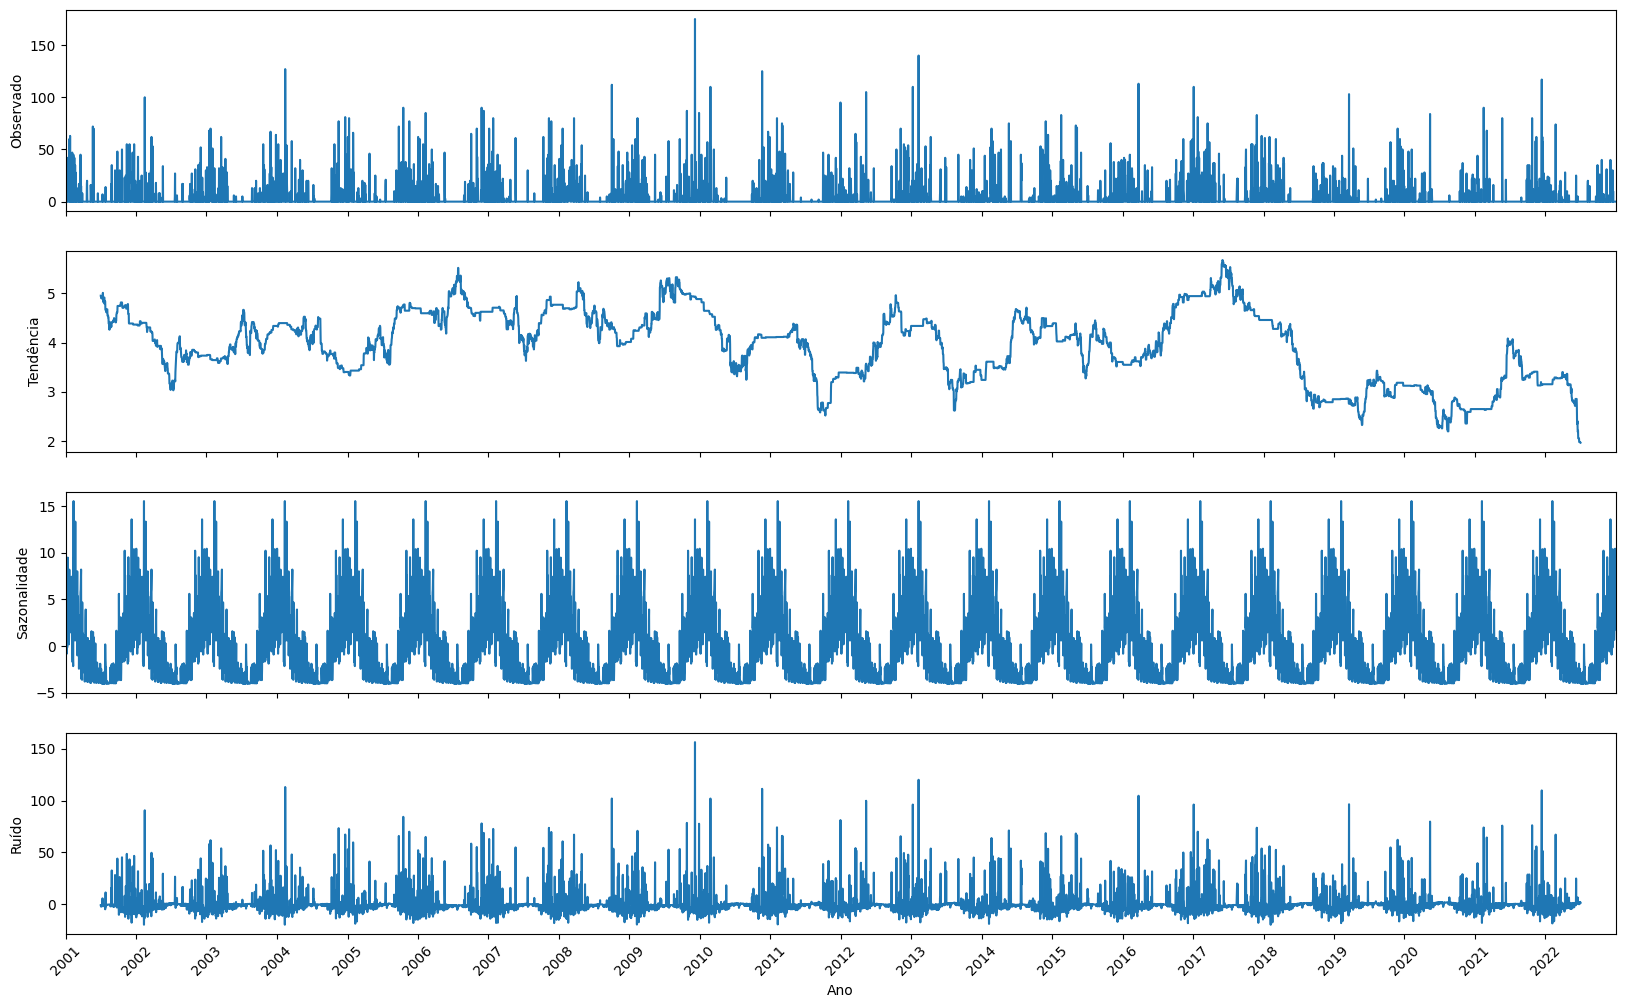

In [59]:
# ---------- ANÁLISE DE SAZONALIDADE ---------- 

from matplotlib.dates import YearLocator
# Convertendo a coluna de datas para o formato correto
df['Data'] = pd.to_datetime(df['Ano'].astype(str) + '-' + df['Mes'].astype(str) + '-' + df['Dia'].astype(str))

# Definindo a data como índice do DataFrame
df = df.set_index('Data')

# Aplicando a decomposição sazonal
decomposition = sm.tsa.seasonal_decompose(df['Total'], model='additive', period=365)

# Plotando os componentes
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(20,12))
decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observado')
decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Tendência')
decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Sazonalidade')
decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Ruído')

# Definindo o intervalo dos ticks do eixo x
years = YearLocator(1)
axes[3].xaxis.set_major_locator(years)

# Formatando o eixo x
import matplotlib.dates as mdates
plt.xticks(rotation=45)
plt.xlabel('Ano')
plt.xlim(df.index[0], df.index[-1])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()


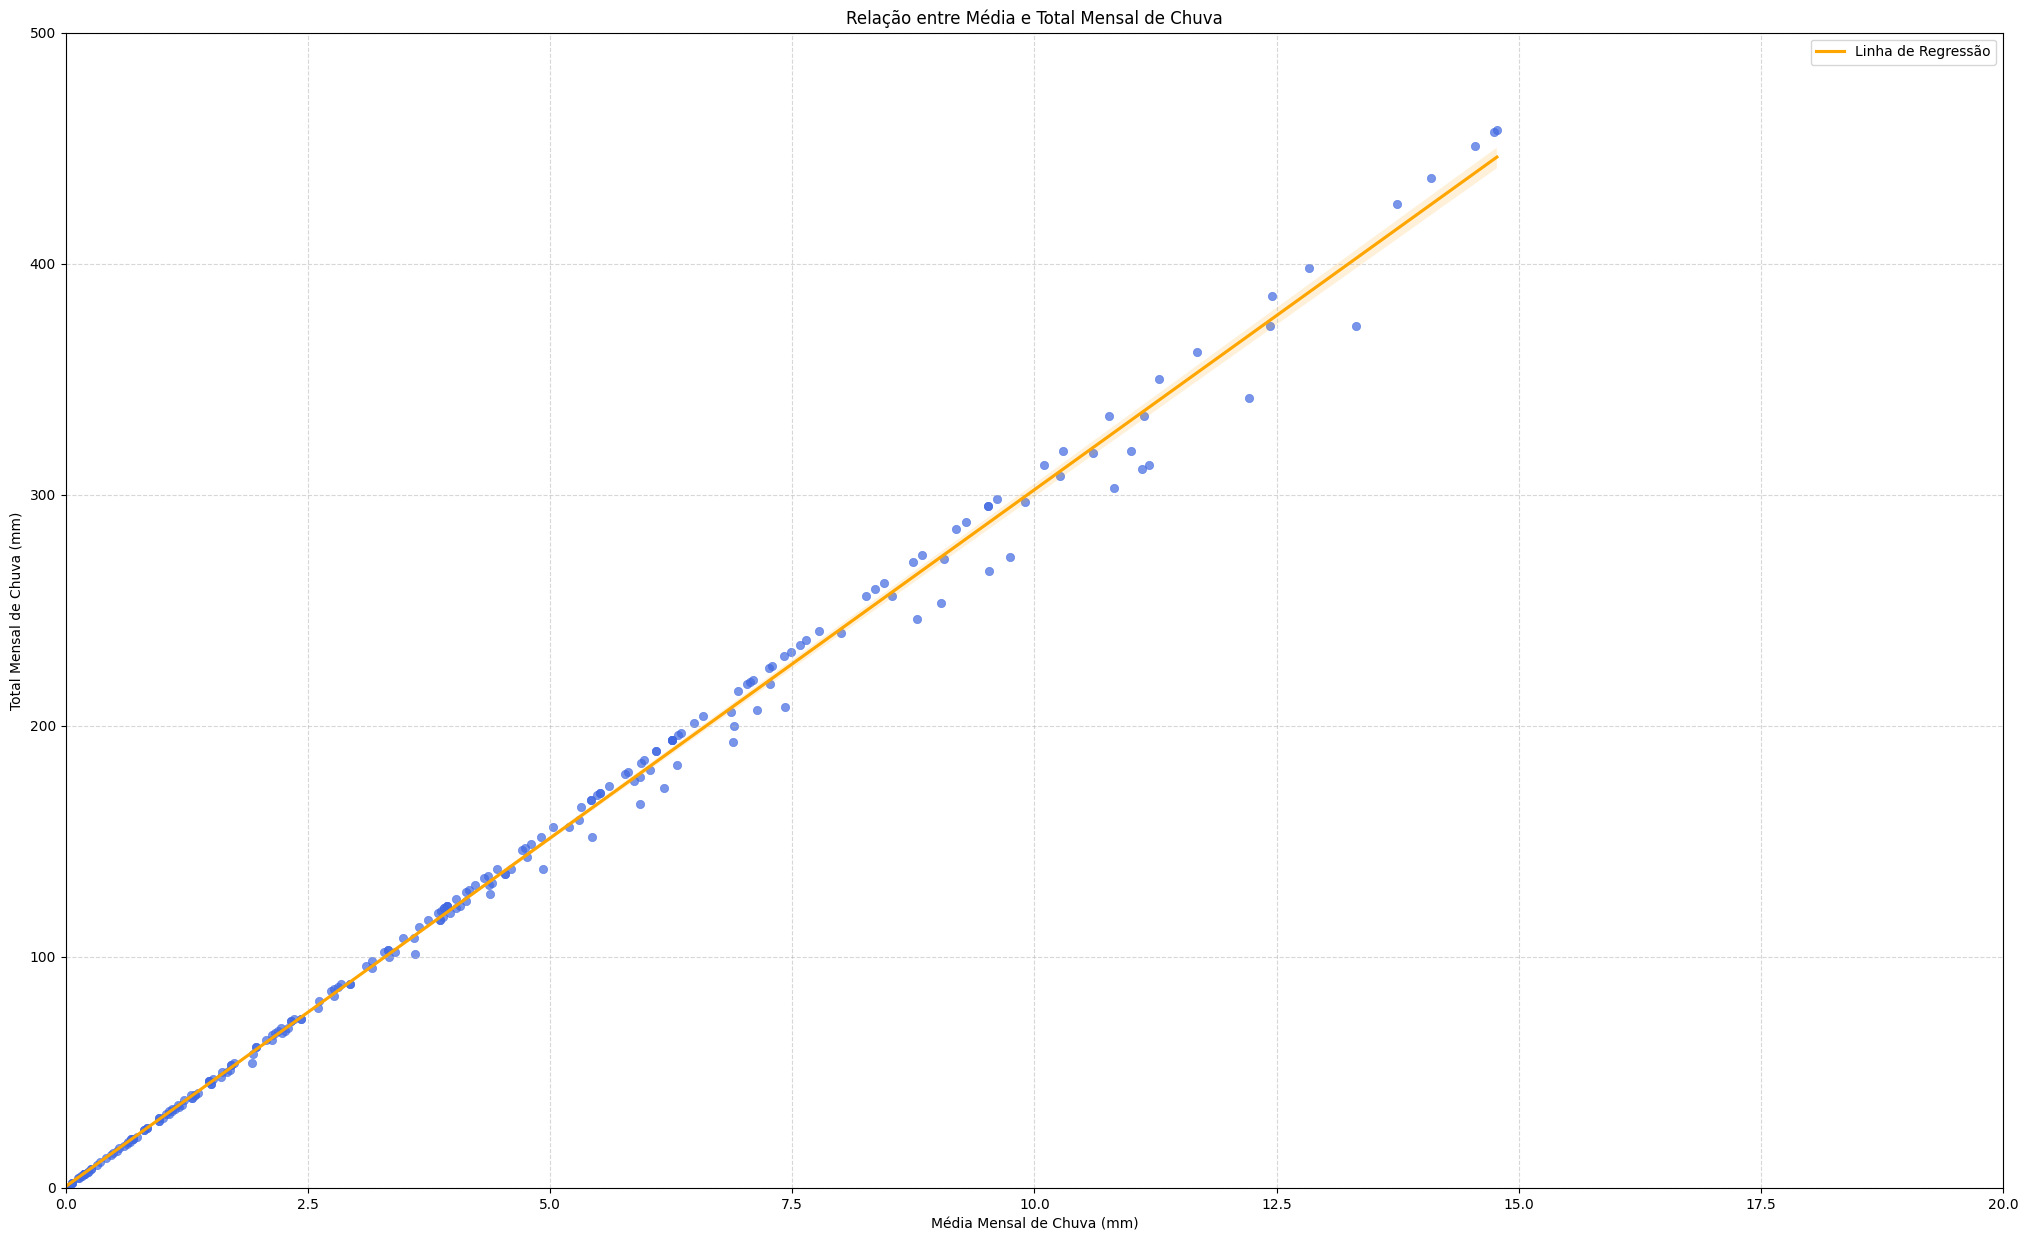

In [58]:
# ---------- ANÁLISE DE REGRESSÃO ---------- 
from sklearn.linear_model import LinearRegression

# Convertendo as colunas Ano, Mes e Dia em um objeto datetime do pandas
df['Data'] = pd.to_datetime(df[['Dia', 'Mes', 'Ano']].rename(columns={'Dia':'day', 'Mes':'month', 'Ano':'year'}), format='%d-%m-%Y')

# Agrupando os dados por mês e ano
df_mensal = df.groupby(['Ano', 'Mes'])['Total'].agg(['sum', 'mean']).reset_index()

# Renomeando as colunas do novo DataFrame
df_mensal = df_mensal.rename(columns={'year': 'Ano', 'month': 'Mes', 'sum': 'Total_Mensal', 'mean': 'Media_Mensal'})


# Definindo as variáveis dependentes e independentes
X = df_mensal['Media_Mensal'] # variável independente (X)
y = df_mensal['Total_Mensal'] # variável dependente (y)

# Criando a figura do gráfico com o tamanho desejado
fig, ax = plt.subplots(figsize=(25, 15))

# Plotando o gráfico de dispersão
sns.scatterplot(x=X, y=y, alpha=0.7, color='royalblue', edgecolor=None)

# Adicionando a linha de regressão
sns.regplot(x=X, y=y, scatter=False, color='orange', label='Linha de Regressão')

# Adicionando um título ao gráfico
plt.title('Relação entre Média e Total Mensal de Chuva')

# Definindo os rótulos dos eixos
plt.xlabel('Média Mensal de Chuva (mm)')
plt.ylabel('Total Mensal de Chuva (mm)')

# Definindo os limites dos eixos x e y
ax.set_xlim(0, 20)
ax.set_ylim(0, 500)

# Adicionando linhas de grade ao gráfico
ax.grid(True, linestyle='--', alpha=0.5)

# Definindo a legenda do gráfico
plt.legend()

# Exibindo o gráfico
plt.show()

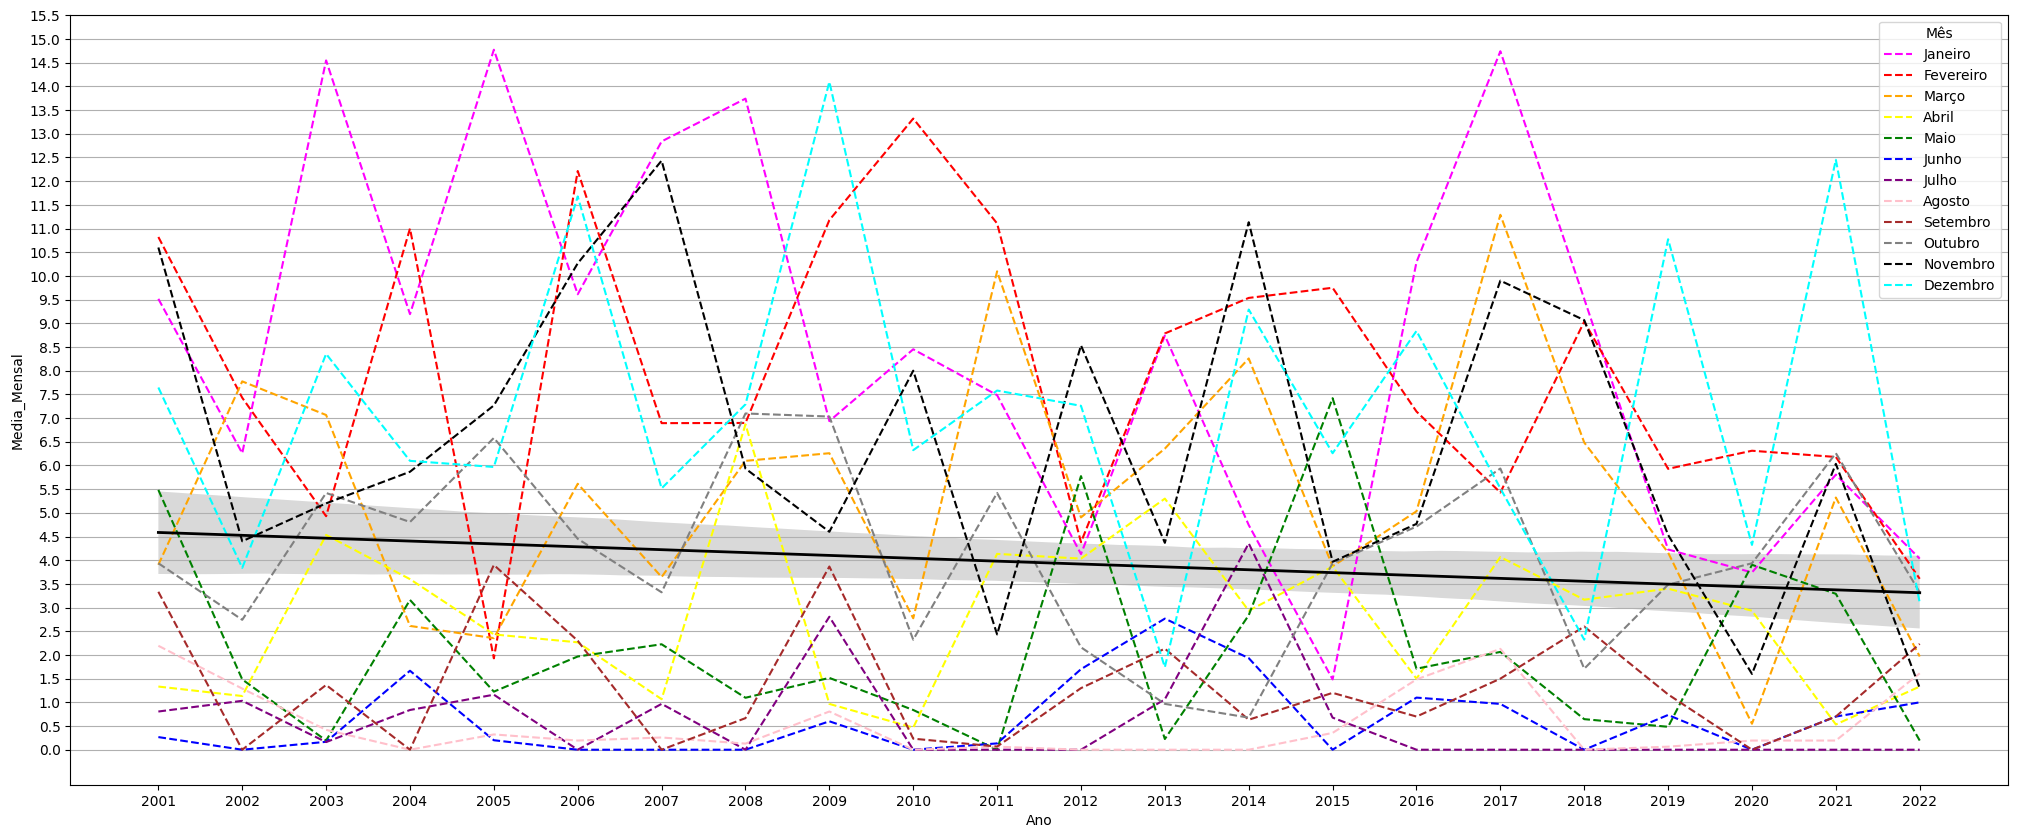

In [57]:
# ---------- ANÁLISE DE REGRESSÃO ---------- 

# Convertendo as colunas Ano, Mes e Dia em um objeto datetime do pandas
df['Data'] = pd.to_datetime(df[['Dia', 'Mes', 'Ano']].rename(columns={'Dia':'day', 'Mes':'month', 'Ano':'year'}), format='%d-%m-%Y')

# Agrupando os dados por mês
df_mensal = df.groupby(['Ano', 'Mes'])['Total'].agg(['sum', 'mean']).reset_index()

# Renomeando as colunas do novo DataFrame
df_mensal = df_mensal.rename(columns={'year': 'Ano', 'month': 'Mes', 'sum': 'Total_Mensal', 'mean': 'Media_Mensal'})

# Criando uma lista de cores para cada mês
cores = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink', 'brown', 'gray', 'black', 'cyan', 'magenta']

# Criando um dicionário que mapeia o número do mês para a cor correspondente
mes_cores = {mes: cores[mes-1] for mes in range(0, 13)}

# Criando o gráfico de linhas colorido por mês
plt.figure(figsize=(25, 10))
plt.grid(axis='y')
plt.xticks(np.arange(2001, 2023, 1))
plt.yticks(np.arange(0, 18, 0.5))

for mes in range(1, 13):
    df_mes = df_mensal[df_mensal['Mes'] == mes]
    sns.lineplot(x='Ano', y='Media_Mensal', color=mes_cores[mes-1], data=df_mes, label=meses[mes-1], linestyle='dashed')

# Adicionando a linha de regressão
sns.regplot(x='Ano', y='Media_Mensal', data=df_mensal, color='black', scatter=False, line_kws={'linestyle':'-', 'linewidth':2})    

# Criando a legenda das cores
meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
plt.legend(title='Mês', loc='upper right')